## Generate Paper Figures

#### 07/23 - 07/26 Validations

In [51]:
import pandas as pd
import numpy as np
from datetime import * 
import matplotlib.pyplot as plt
from run_foco import run_foco
from validation import * 

start_date_time = '2024-07-23 12:30:00'
end_date_time = '2024-07-26 11:30:00'

# set up logging
import logging
filename = 'validation.log'
logging.basicConfig(filename=filename, level=logging.INFO, format='%(asctime)s - %(message)s')
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)
# Clear the log file
with open(filename, 'w'):
    pass  # This opens and immediately closes the file, truncating it

# import, load, and smooth data from raspi
def import_data(path, logging, window_length, polyorder, columns_to_drop = ['sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'fan']):
	from scipy.signal import savgol_filter
	sensor_readings_df = pd.read_csv(path)
	#print(sensor_readings_df.head(5))
	sensor_readings_df = sensor_readings_df.set_index('timestamp')

	# Drop columns with all zeros
	all_zero_cols = sensor_readings_df.columns[(sensor_readings_df == 0).all()]
	print(all_zero_cols)
	sensor_readings_df.index = pd.to_datetime(sensor_readings_df.index)
	for col in columns_to_drop:
		try:
			sensor_readings_df.drop(columns=[col], inplace=True)
		except Exception as e:
			logging.info("error excepted", e)
	sensor_readings_df.index = sensor_readings_df.index.round('s')
	sensor_readings_df.drop(columns=all_zero_cols, inplace=True)

	# Define the window length and polynomial order
	smoothed_df = pd.DataFrame()
	smoothed_df.index = sensor_readings_df.index

	logging.info("*** Data Loaded ***")

	# Apply the Savitzky-Golay filter to each column after cleaning zeros
	for col in sensor_readings_df.columns:
		# Clean the column by removing zeros
		cleaned_col = sensor_readings_df[col].replace(0, np.nan)

		# Apply the Savitzky-Golay filter if there are enough data points
		if len(cleaned_col) >= window_length:
			smoothed_df[col[-1] + '_smooth'] = savgol_filter(cleaned_col, window_length, polyorder)
		else:
			logging.warning("Not enough data points in column %s to apply Savitzky-Golay filter", col)
			smoothed_df[col[-1] + '_smooth'] = pd.NA

	return sensor_readings_df, smoothed_df


Index([], dtype='object')
Fan speed: 0.0
start date 2024-07-23
end date 2024-07-26
wind_speed_factor 1
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


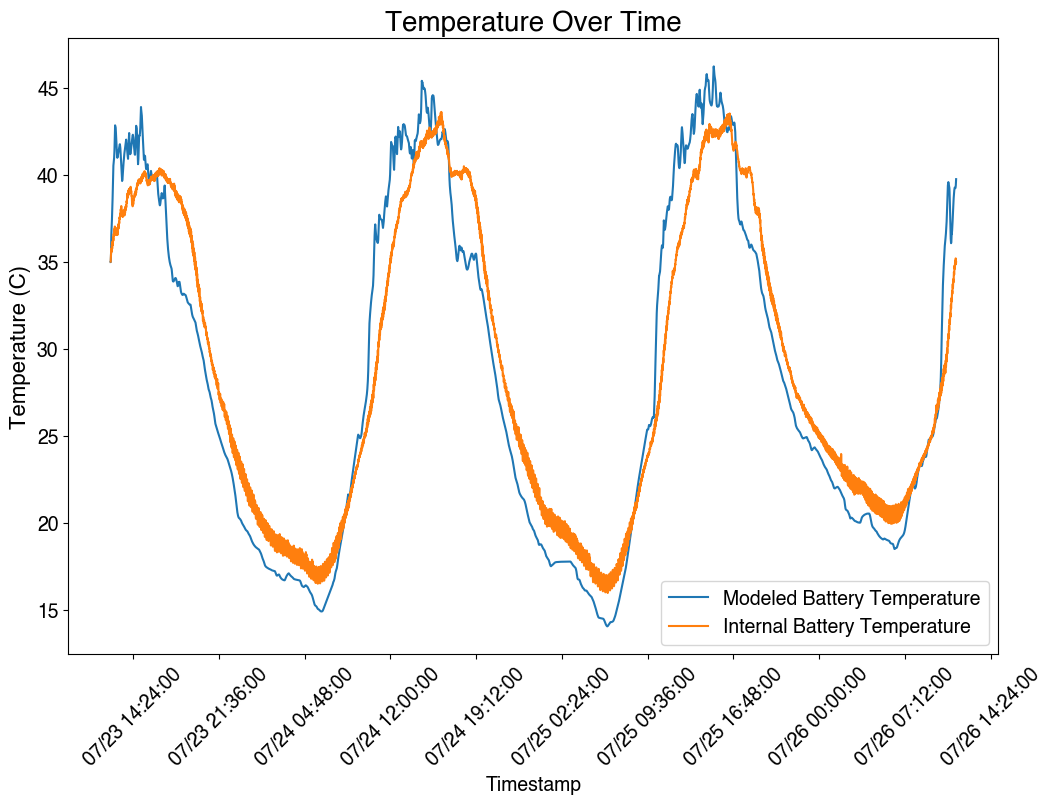

In [52]:
sensor_df, smoothed_df = import_data("../real_data/sensor_readings_2024_07_23_12_28.csv",  logging, 59, 2, columns_to_drop = [
       'sensor_5', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15'])
logging.info("*** Retrieved Raspi Data ***")

results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 4, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=35 + 273.15,fan_threshold = 50, shading = False)

logging.info("Directories: " + results_dir)
model_df = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

plot_comparison(smoothed_df, [{'data':model_df, 'label': "Modeled Battery Temperature"}, 
							  ],
				start_date_time, end_date_time)

Fan speed: 0.0
start date 2024-07-26
end date 2024-07-29
wind_speed_factor 1
mean temp not weighted
0.0


/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83354/678488376.py:56: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  model_dict['data']['outside_temp_rolling'] = model_dict['data']['outside_temp'].rolling('15T').mean()


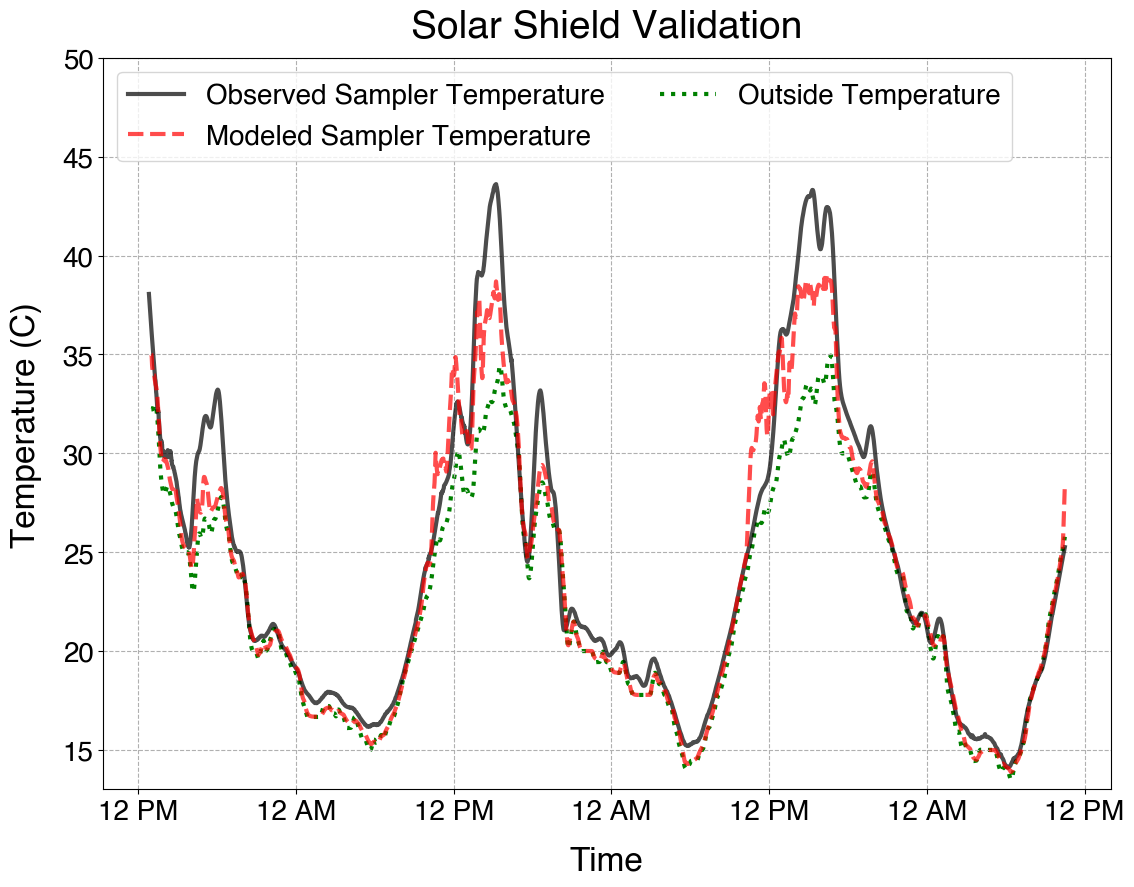

In [94]:
import pandas as pd
import numpy as np
from datetime import * 
import matplotlib.pyplot as plt
from run_foco import run_foco
from validation import * 

start_date_time = '2024-07-26 13:00:00'
end_date_time = '2024-07-29 10:30:00'


sensor_df, smoothed_df = import_data("../real_data/sensor_readings_2024_07_26_12_49.csv",  logging, 59, 2, columns_to_drop = [
       'sensor_0', 'sensor_1', 'sensor_2',
       'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7','sensor_13', 'sensor_15'])
logging.info("*** Retrieved Raspi Data ***")

results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 4, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=35 + 273.15,fan_threshold = 50, shading = True)

logging.info("Directories: " + results_dir)
model_df = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

def plot_comparison(smoothed_df, model_dfs, start_date_time, end_date_time, col1='2_smooth', col2='3_smooth', title="Temperature Over Time"):
    """
    Plot a comparison of real-world smoothed sensor data and modeled temperature data.

    Parameters:
    smoothed_df (pd.DataFrame): DataFrame with smoothed sensor readings.
    model_dfs (list): List of dictionaries with model data and their labels.
    start_date_time (datetime): Start time for the comparison plot.
    end_date_time (datetime): End time for the comparison plot.
    col1 (str): Column name for the first sensor reading for battery temperature averaging.
    col2 (str): Column name for the second sensor reading for battery temperature averaging.
    title (str): Title of the plot.

    Returns:
    None

    Notes:
    The Celsius data is converted to Fahrenheit, and the plot is saved as a PNG file.
    """

    def to_F(num):
        return num

    import matplotlib.dates as mdates
    from matplotlib import rc
    rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

    smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])

    fig, ax = plt.subplots(figsize=(13, 9.5))

    # Iterate through model data to plot lines and add shading
    for model_dict in model_dfs:
        model_dict['data']['outside_temp_rolling'] = model_dict['data']['outside_temp'].rolling('15T').mean()

        # Plot the rolling average for outside temperature and model internal temperature
        outside_temp_F = to_F(model_dict['data']['outside_temp_rolling'] - 273.15)
        internal_temp_F = to_F(model_dict['data']['internal'] - 273.15)

        plt.plot(to_F(smoothed_df['batt_avg']), label="Observed Sampler Temperature", color="black", linewidth=3, alpha=0.7, linestyle='-', zorder=2)
        plt.plot(internal_temp_F, label='Modeled Sampler Temperature', color='red', linewidth=3, alpha=0.7, linestyle='--', zorder=3)
        plt.plot(outside_temp_F, label="Outside Temperature", color="green", linewidth=3, linestyle=':', zorder=1)

        # # Add shading between the red (model) and green (outside temperature) lines
        # ax.fill_between(model_dict['data'].index, outside_temp_F, internal_temp_F, 
        #                 where=(internal_temp_F > outside_temp_F),
        #                 facecolor='red', alpha=0.3, zorder=0.5)

    # Set date and time format for the x-axis
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 12]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%I %p'))
    ax.xaxis.grid(True, linestyle='dashed', alpha=1, zorder=0.3)
    ax.yaxis.grid(True, linestyle='dashed', alpha=1, zorder=0.3)

    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Temperature (C)', fontsize=24, labelpad=15)
    plt.ylim([13, 50])
    plt.xlabel("Time", fontsize=24, labelpad=15)
    plt.title(title, fontsize=28, pad=15)
    plt.legend(fontsize=20, loc='upper left', ncol=2)
    #plt.savefig("graphical_abstract.png", dpi=600)  # Specify the file name and desired DPI

    plt.show()


# # Example usage
# plot_comparison(smoothed_others_df[(smoothed_others_df.index >= "2024-07-27 06:00:00") & (smoothed_others_df.index <= "2024-07-29 06:00:00")], [
#     {'data': model_df_pvc[(model_df_pvc.index >= "2024-07-27 06:00:00") & (model_df_pvc.index <= "2024-07-29 06:00:00")], 'label': "Model Prediction"},
# ],
#                start_date_time, end_date_time, col1='9_smooth', col2='9_smooth',
#                title="Highly Accurate Predictive Heat Transfer Model")

plot_comparison(smoothed_df, [{'data':model_df, 'label': "Modeled Battery Temperature"}, 
							  ],
				start_date_time, end_date_time, col1 = '9_smooth', col2 = '9_smooth', title = "Solar Shield Validation")


In [91]:
smoothed_df

0_smooth   1_smooth   2_smooth   3_smooth   4_smooth  \
timestamp                                                                    
2024-07-26 12:49:00  40.988319  38.113879  38.228080  37.285362  38.466237   
2024-07-26 12:50:00  40.906651  38.037895  38.197287  37.291556  38.361721   
2024-07-26 12:51:00  40.820830  37.959651  38.164825  37.293976  38.255026   
2024-07-26 12:52:00  40.730855  37.879148  38.130693  37.292623  38.146153   
2024-07-26 12:53:00  40.636728  37.796385  38.094892  37.287495  38.035102   
...                        ...        ...        ...        ...        ...   
2024-07-29 10:26:00  34.655354  26.641721  24.844356  23.892180  25.357903   
2024-07-29 10:27:00  34.653030  26.696756  24.902359  23.942249  25.415134   
2024-07-29 10:28:00  34.650587  26.751739  24.960363  23.992266  25.472337   
2024-07-29 10:29:00  34.648027  26.806670  25.018368  24.042232  25.529513   
2024-07-29 10:30:00  34.645348  26.861549  25.076375  24.092145  25.586660   

                      6_smooth   7_smooth   batt_avg  
timestamp                                             
2024-07-26 12:49:00  42.368086  38.226026  37.756721  
2024-07-26 12:50:00  42.199383  38.148179  37.744422  
2024-07-26 12:51:00  42.027327  38.068509  37.729401  
2024-07-26 12:52:00  41.851918  37.987015  37.711658  
2024-07-26 12:53:00  41.673156  37.903698  37.691194  
...                        ...        ...        ...  
2024-07-29 10:26:00  24.704150  26.589814  24.368268  
2024-07-29 10:27:00  24.766692  26.648354  24.422304  
2024-07-29 10:28:00  24.828957  26.706889  24.476315  
2024-07-29 10:29:00  24.890944  26.765420  24.530300  
2024-07-29 10:30:00  24.952655  26.823945  24.584260  

[4182 rows x 8 columns]

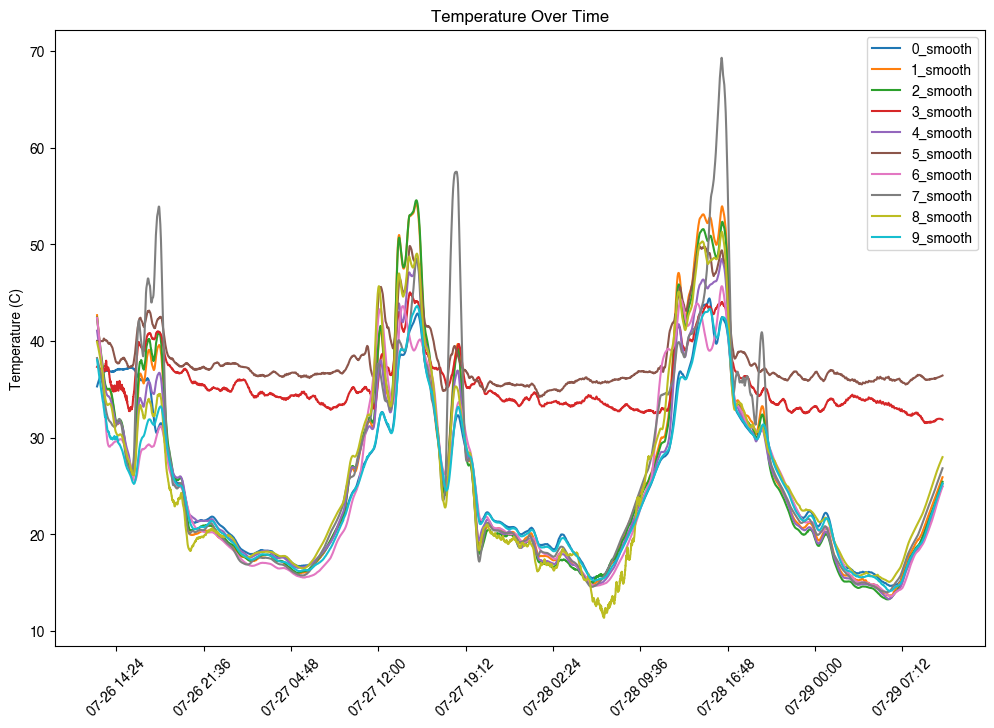

In [96]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

others_df, smoothed_others_df = import_data("../real_data/sensor_readings_2024_07_26_12_49.csv",  logging, 59, 2, columns_to_drop = [
       'sensor_0', 'sensor_1', 'sensor_2',
       'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7','sensor_13', 'sensor_15'])

fig, ax = plt.subplots(figsize = (12,8))
for col in smoothed_others_df:
	plt.plot(smoothed_others_df[col], label = col)

ax.xaxis.set_major_locator(plt.MaxNLocator(12))  # Limit to 12 date labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylabel('Temperature (C)')
plt.title("Temperature Over Time")
plt.legend()
plt.show()


Fan speed: 0.0
start date 2024-07-23
end date 2024-07-26
wind_speed_factor 1
mean temp not weighted
0.0


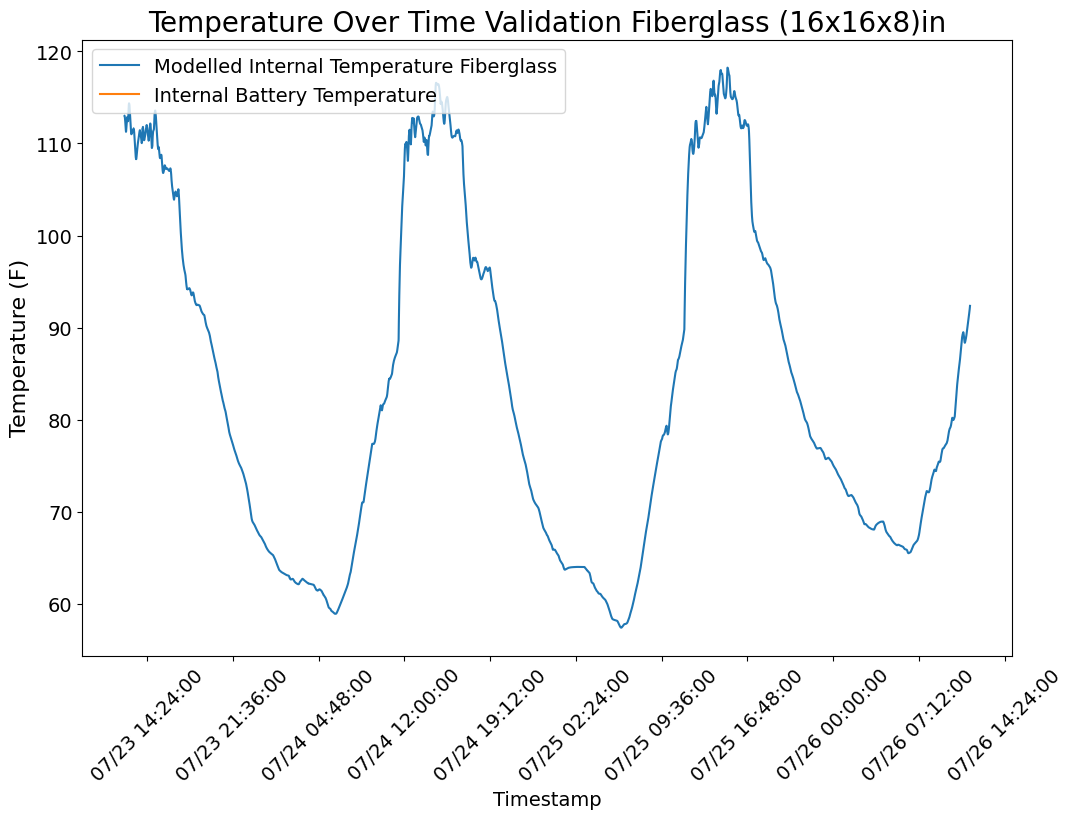

In [4]:

results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 8, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
						k=0.216,
						rho=1370,
						Cp=1300,
						emissivity=0.92,
                        L = 0.4,
                        H = 0.2,
                        W = 0.4,
                        thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
						shading_ranges = [('10:00:00', '11:30:00')],)

logging.info("Directories: " + results_dir)
model_df_fiberglass = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

plot_comparison(smoothed_others_df, [{'data':model_df_fiberglass, 'label': "Modelled Internal Temperature Fiberglass"}],
				start_date_time, end_date_time, col1 = '4_smooth', col2 = '4_smooth',
				title = "Temperature Over Time Validation Fiberglass (16x16x8)in")

#### Fig for graphical abstract

In [13]:
import pandas as pd
import numpy as np
from datetime import * 
import matplotlib.pyplot as plt
from run_foco import run_foco
from validation import * 

start_date_time = '2024-07-26 12:30:00'
end_date_time = '2024-07-30 11:30:00'

# set up logging
import logging
filename = 'validation.log'
logging.basicConfig(filename=filename, level=logging.INFO, format='%(asctime)s - %(message)s')
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)
# Clear the log file
with open(filename, 'w'):
    pass  # This opens and immediately closes the file, truncating it

# import, load, and smooth data from raspi
def import_data(path, logging, window_length, polyorder, columns_to_drop = ['sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'fan']):
	from scipy.signal import savgol_filter
	sensor_readings_df = pd.read_csv(path)
	#print(sensor_readings_df.head(5))
	sensor_readings_df = sensor_readings_df.set_index('timestamp')

	# Drop columns with all zeros
	all_zero_cols = sensor_readings_df.columns[(sensor_readings_df == 0).all()]
	print(all_zero_cols)
	sensor_readings_df.index = pd.to_datetime(sensor_readings_df.index)
	for col in columns_to_drop:
		try:
			sensor_readings_df.drop(columns=[col], inplace=True)
		except Exception as e:
			logging.info("error excepted", e)
	sensor_readings_df.index = sensor_readings_df.index.round('s')
	sensor_readings_df.drop(columns=all_zero_cols, inplace=True)

	# Define the window length and polynomial order
	smoothed_df = pd.DataFrame()
	smoothed_df.index = sensor_readings_df.index

	logging.info("*** Data Loaded ***")

	# Apply the Savitzky-Golay filter to each column after cleaning zeros
	for col in sensor_readings_df.columns:
		# Clean the column by removing zeros
		cleaned_col = sensor_readings_df[col].replace(0, np.nan)

		# Apply the Savitzky-Golay filter if there are enough data points
		if len(cleaned_col) >= window_length:
			smoothed_df[col[-1] + '_smooth'] = savgol_filter(cleaned_col, window_length, polyorder)
		else:
			logging.warning("Not enough data points in column %s to apply Savitzky-Golay filter", col)
			smoothed_df[col[-1] + '_smooth'] = pd.NA

	return sensor_readings_df, smoothed_df


Fan speed: 0.0
start date 2024-07-26
end date 2024-07-30
wind_speed_factor 1
mean temp not weighted
0.0


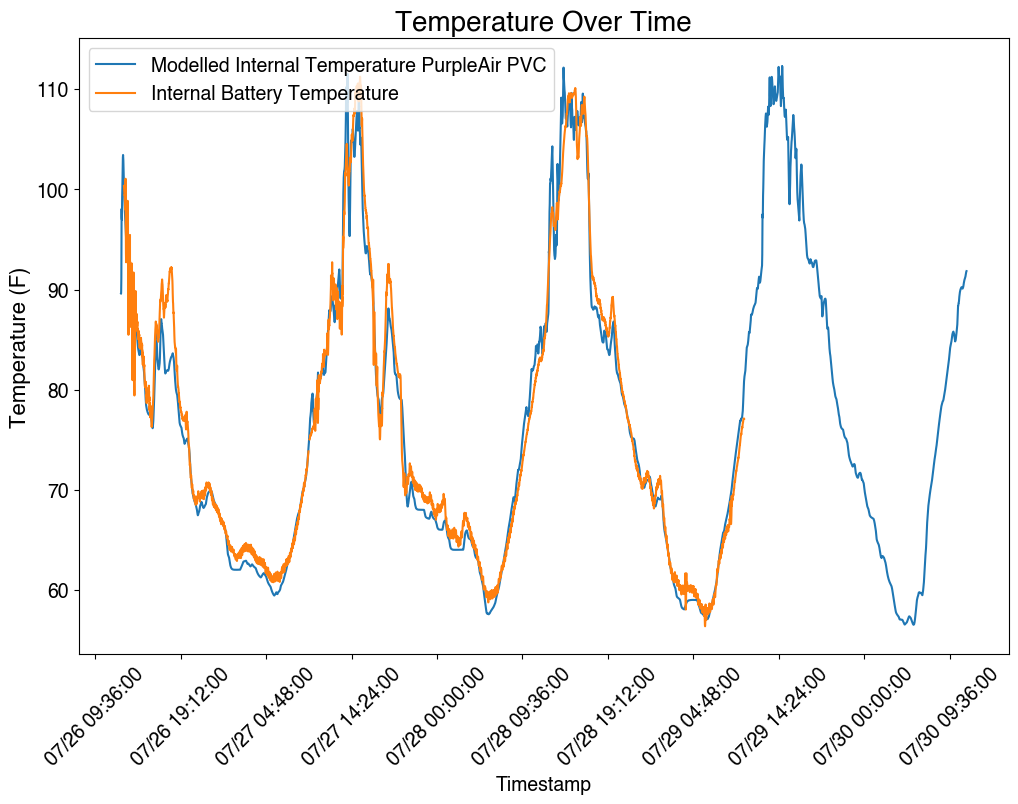

In [14]:

results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=32 + 273.15,fan_threshold = 50,
						k=0.157,
						rho=900,
						Cp=1390,
						emissivity=0.92,
                        L = 0.08,
                        H = 0.08,
                        W = 0.08,
                        thicknesses=[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
						shading_ranges = [('10:00:00', '12:30:00')])

logging.info("Directories: " + results_dir)
model_df_pvc = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

plot_comparison(smoothed_others_df, [{'data':model_df_pvc, 'label': "Modelled Internal Temperature PurpleAir PVC"}, 
							  ],
				start_date_time, end_date_time, col1 = '9_smooth', col2 = '9_smooth')

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83354/4051740894.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])
/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83354/4051740894.py:34: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  model_dict['data']['outside_temp_rolling'] = model_dict['data']['outside_temp'].rolling('15T').mean()
/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83354/4051740894.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

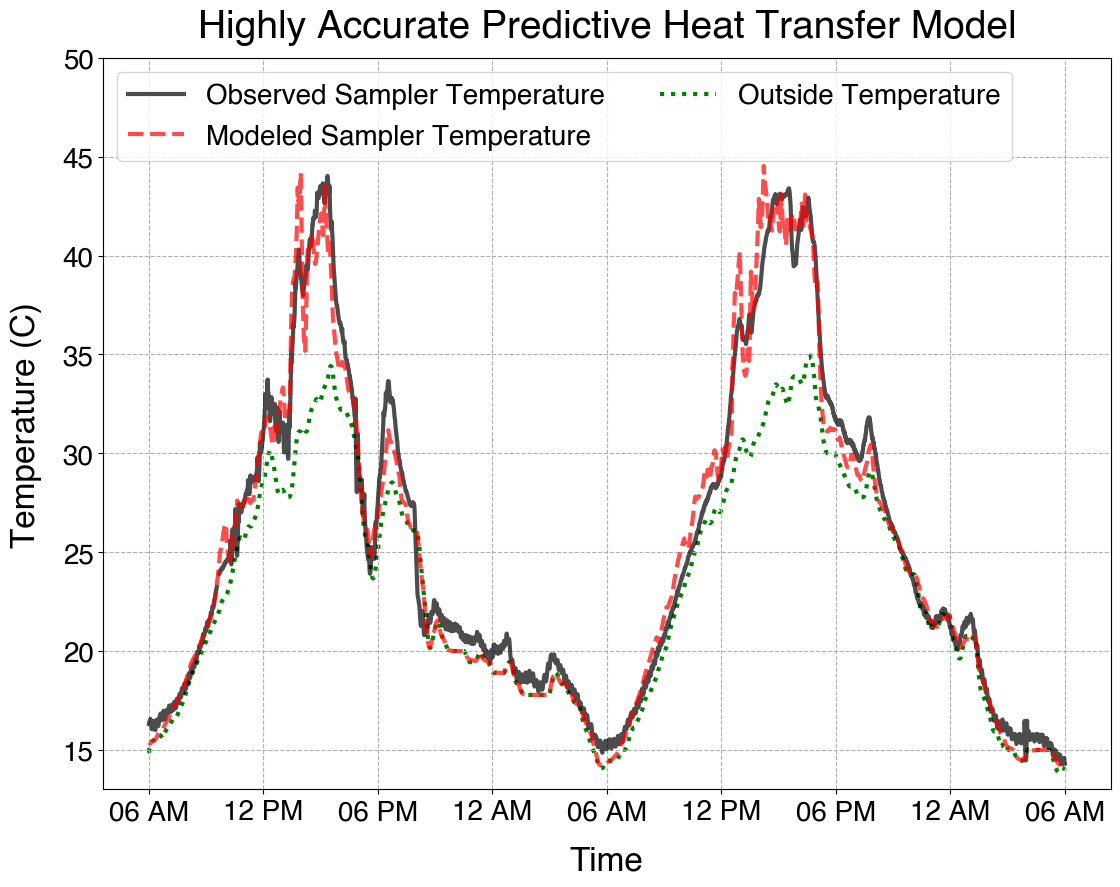

In [60]:
def plot_comparison(smoothed_df, model_dfs, start_date_time, end_date_time, col1='2_smooth', col2='3_smooth', title="Temperature Over Time"):
    """
    Plot a comparison of real-world smoothed sensor data and modeled temperature data.

    Parameters:
    smoothed_df (pd.DataFrame): DataFrame with smoothed sensor readings.
    model_dfs (list): List of dictionaries with model data and their labels.
    start_date_time (datetime): Start time for the comparison plot.
    end_date_time (datetime): End time for the comparison plot.
    col1 (str): Column name for the first sensor reading for battery temperature averaging.
    col2 (str): Column name for the second sensor reading for battery temperature averaging.
    title (str): Title of the plot.

    Returns:
    None

    Notes:
    The Celsius data is converted to Fahrenheit, and the plot is saved as a PNG file.
    """

    def to_F(num):
        return num

    import matplotlib.dates as mdates
    from matplotlib import rc
    rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

    smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])

    fig, ax = plt.subplots(figsize=(13, 9.5))

    # Iterate through model data to plot lines and add shading
    for model_dict in model_dfs:
        model_dict['data']['outside_temp_rolling'] = model_dict['data']['outside_temp'].rolling('15T').mean()

        # Plot the rolling average for outside temperature and model internal temperature
        outside_temp_F = to_F(model_dict['data']['outside_temp_rolling'] - 273.15)
        internal_temp_F = to_F(model_dict['data']['internal'] - 273.15)

        plt.plot(to_F(smoothed_df['batt_avg']), label="Observed Sampler Temperature", color="black", linewidth=3, alpha=0.7, linestyle='-', zorder=2)
        plt.plot(internal_temp_F, label='Modeled Sampler Temperature', color='red', linewidth=3, alpha=0.7, linestyle='--', zorder=3)
        plt.plot(outside_temp_F, label="Outside Temperature", color="green", linewidth=3, linestyle=':', zorder=1)

        # # Add shading between the red (model) and green (outside temperature) lines
        # ax.fill_between(model_dict['data'].index, outside_temp_F, internal_temp_F, 
        #                 where=(internal_temp_F > outside_temp_F),
        #                 facecolor='red', alpha=0.3, zorder=0.5)

    # Set date and time format for the x-axis
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%I %p'))
    ax.xaxis.grid(True, linestyle='dashed', alpha=1, zorder=0.3)
    ax.yaxis.grid(True, linestyle='dashed', alpha=1, zorder=0.3)

    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Temperature (C)', fontsize=24, labelpad=15)
    plt.ylim([13, 50])
    plt.xlabel("Time", fontsize=24, labelpad=15)
    plt.title(title, fontsize=28, pad=15)
    plt.legend(fontsize=20, loc='upper left', ncol=2)
    #plt.savefig("graphical_abstract.png", dpi=600)  # Specify the file name and desired DPI

    plt.show()


# Example usage
plot_comparison(smoothed_others_df[(smoothed_others_df.index >= "2024-07-27 06:00:00") & (smoothed_others_df.index <= "2024-07-29 06:00:00")], [
    {'data': model_df_pvc[(model_df_pvc.index >= "2024-07-27 06:00:00") & (model_df_pvc.index <= "2024-07-29 06:00:00")], 'label': "Model Prediction"},
],
               start_date_time, end_date_time, col1='9_smooth', col2='9_smooth',
               title="Highly Accurate Predictive Heat Transfer Model")


In [54]:
smoothed_others_df

2_smooth   3_smooth   8_smooth   9_smooth   0_smooth  \
timestamp                                                                    
2024-07-31 12:09:13  39.113712  35.390358        NaN  33.425577  33.494151   
2024-07-31 12:09:21  39.190201  35.438258        NaN  33.478308  33.520998   
2024-07-31 12:09:29  39.267026  35.485628        NaN  33.529114  33.547804   
2024-07-31 12:09:37  39.344187  35.532467        NaN  33.577995  33.574569   
2024-07-31 12:09:45  39.421684  35.578776        NaN  33.624951  33.601292   
...                        ...        ...        ...        ...        ...   
2024-08-14 13:33:38        NaN        NaN  41.999462  35.738726  36.375126   
2024-08-14 13:33:39        NaN        NaN  41.971439  35.733434  36.343041   
2024-08-14 13:33:40        NaN        NaN  41.941638  35.727334  36.309723   
2024-08-14 13:33:45        NaN        NaN  41.910059  35.720427  36.275171   
2024-08-14 13:33:53        NaN        NaN  41.876702  35.712712  36.239386   

                      1_smooth   4_smooth  
timestamp                                  
2024-07-31 12:09:13  41.164087  36.372909  
2024-07-31 12:09:21  41.261870  36.416857  
2024-07-31 12:09:29  41.358561  36.460622  
2024-07-31 12:09:37  41.454161  36.504204  
2024-07-31 12:09:45  41.548669  36.547604  
...                        ...        ...  
2024-08-14 13:33:38  42.684146        NaN  
2024-08-14 13:33:39  42.293928        NaN  
2024-08-14 13:33:40  41.890171        NaN  
2024-08-14 13:33:45  41.472875        NaN  
2024-08-14 13:33:53  41.042039        NaN  

[151836 rows x 7 columns]

In [12]:
model_df_pvc

seconds_past    internal  battery_temp  \
datetime                                                              
2024-07-23 12:30:00.000000       0.000000  305.149994    305.149994   
2024-07-23 12:30:03.634709       3.634709  305.149994    305.149994   
2024-07-23 12:30:07.269418       7.269418  305.149994    305.149994   
2024-07-23 12:30:10.904127      10.904127  305.149994    305.149994   
2024-07-23 12:30:14.538836      14.538836  305.149994    305.149994   
...                                   ...         ...           ...   
2024-07-26 11:29:45.468750  255585.468750  305.978790    305.978790   
2024-07-26 11:29:49.093750  255589.093750  305.986969    305.986969   
2024-07-26 11:29:52.734375  255592.734375  305.995148    305.995148   
2024-07-26 11:29:56.359375  255596.359375  306.003326    306.003326   
2024-07-26 11:30:00.000000  255600.000000  306.012604    306.012604   

                            outside_temp  
datetime                                  
2024-07-23 12:30:00.000000    303.149994  
2024-07-23 12:30:03.634709    303.149994  
2024-07-23 12:30:07.269418    303.149994  
2024-07-23 12:30:10.904127    303.149994  
2024-07-23 12:30:14.538836    303.149994  
...                                  ...  
2024-07-26 11:29:45.468750    304.844452  
2024-07-26 11:29:49.093750    304.851105  
2024-07-26 11:29:52.734375    304.857758  
2024-07-26 11:29:56.359375    304.864410  
2024-07-26 11:30:00.000000    304.816711  

[70323 rows x 4 columns]

In [11]:
model_df_pvc[(model_df_pvc.index >= "2024-07-27 06:00:00") & (model_df_pvc.index <= "2024-07-29 06:00:00")]

Empty DataFrame
Columns: [seconds_past, internal, battery_temp, outside_temp]
Index: []

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83354/190235251.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])
/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83354/190235251.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  model_dict['data']['outside_temp_rolling'] = model_dict['data']['outside_temp'].rolling('15T').mean()


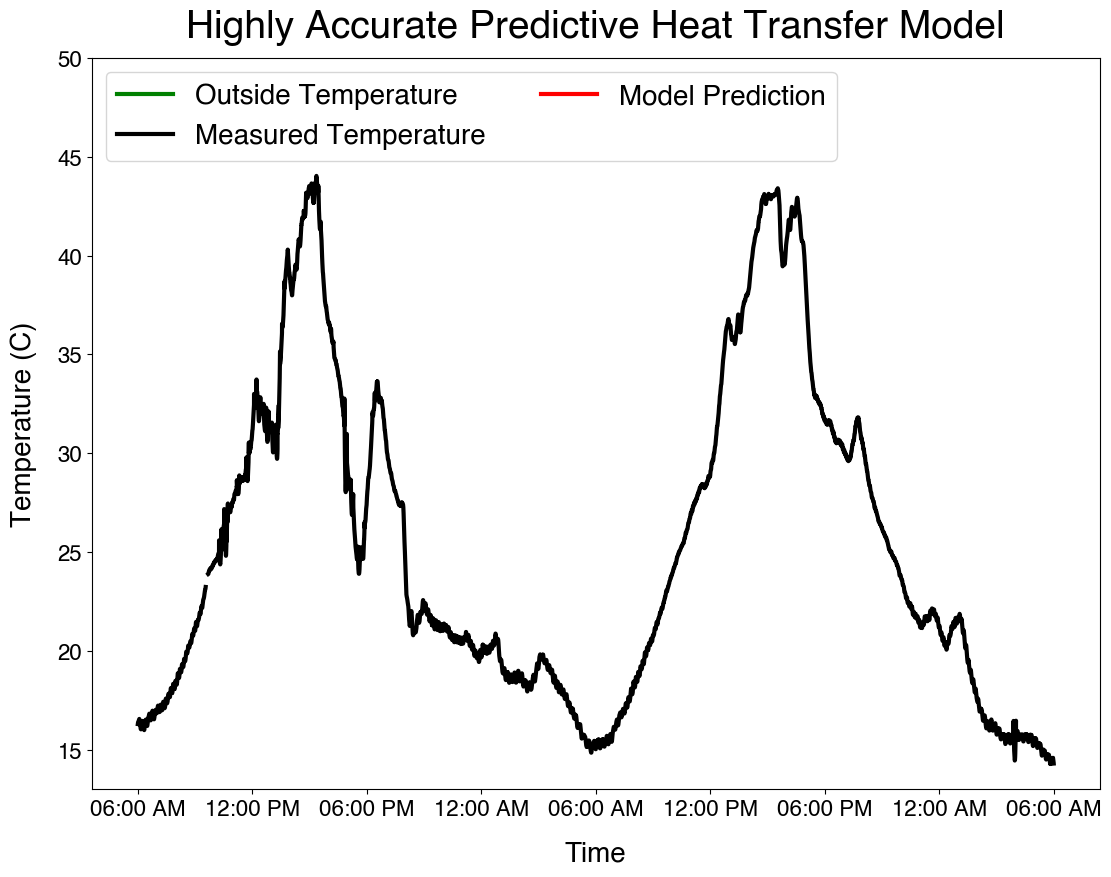

In [7]:
def plot_comparison(smoothed_df, model_dfs, start_date_time, end_date_time, col1='2_smooth', col2='3_smooth', title="Temperature Over Time"):
    """
    Plot a comparison of real-world smoothed sensor data and modeled temperature data.

    Parameters:
    smoothed_df (pd.DataFrame): DataFrame with smoothed sensor readings.
    model_dfs (list): List of dictionaries with model data and their labels.
    start_date_time (datetime): Start time for the comparison plot.
    end_date_time (datetime): End time for the comparison plot.
    col1 (str): Column name for the first sensor reading for battery temperature averaging.
    col2 (str): Column name for the second sensor reading for battery temperature averaging.
    title (str): Title of the plot.

    Returns:
    None

    Notes:
    The Celsius data is converted to Fahrenheit, and the plot is saved as a PNG file.
    """

    def to_F(num):
        return num

    import matplotlib.dates as mdates
    from matplotlib import rc
    rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

    smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])

    fig, ax = plt.subplots(figsize=(13, 9.5))

    # Add horizontal line at 40 degrees
    #ax.axhline(y=40, color='blue', linestyle='--', linewidth=3, label="Common Sampler Failure")

    # Iterate through model data to plot lines and add shading
    for model_dict in model_dfs:
        model_dict['data']['outside_temp_rolling'] = model_dict['data']['outside_temp'].rolling('15T').mean()

        # Plot the rolling average for outside temperature and model internal temperature
        outside_temp_F = to_F(model_dict['data']['outside_temp_rolling'] - 273.15)
        internal_temp_F = to_F(model_dict['data']['internal'] - 273.15)

        plt.plot(outside_temp_F, label="Outside Temperature", color="green", linewidth=3)
        plt.plot(to_F(smoothed_df['batt_avg']), label="Measured Temperature", color="black", linewidth=3)
        plt.plot(internal_temp_F, label=model_dict['label'], color='red', linewidth=3)

        # Add shading between the red (model) and green (outside temperature) lines
        ax.fill_between(model_dict['data'].index, outside_temp_F, internal_temp_F, 
                        where=(internal_temp_F > outside_temp_F),
                        facecolor='red', alpha=0.3)

    # Set date and time format for the x-axis
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%I:%M %p'))

    plt.xticks(rotation=0, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('Temperature (C)', fontsize=20, labelpad=15)
    plt.ylim([13, 50])
    plt.xlabel("Time", fontsize=20, labelpad=15)
    plt.title(title, fontsize=28, pad=15)
    plt.legend(fontsize=20, loc='upper left', ncol=2)

    plt.show()


# Example usage
plot_comparison(smoothed_others_df[(smoothed_others_df.index >= "2024-07-27 06:00:00") & (smoothed_others_df.index <= "2024-07-29 06:00:00")], [
    {'data': model_df_pvc[(model_df_pvc.index >= "2024-07-27 06:00:00") & (model_df_pvc.index <= "2024-07-29 06:00:00")], 'label': "Model Prediction"},
],
               start_date_time, end_date_time, col1='9_smooth', col2='9_smooth',
               title="Highly Accurate Predictive Heat Transfer Model")

In [9]:
outside_temp_F

NameError: name 'outside_temp_F' is not defined

In [ ]:

results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=32 + 273.15,fan_threshold = 50,
						k=92,
						rho=2823,
						Cp=963,
						emissivity=0.9,
                        L = 0.074,
                        H = 0.052,
                        W = 0.08,
                        thicknesses=[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
						shading_ranges = [('10:00:00', '12:30:00')])

logging.info("Directories: " + results_dir)
model_df_pvc = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

plot_comparison(smoothed_others_df, [{'data':model_df_pvc, 'label': "Modelled Internal Temperature Aluminum"}, 
							  ],
				start_date_time, end_date_time, col1 = '8_smooth', col2 = '8_smooth')#

Fan speed: 0.0
start date 2024-07-26
end date 2024-07-29
mean temp not weighted
0.0


#### Combine thermocouple data

In [35]:
import glob
import os
import pandas as pd

# Directory where the files are located
directory = '../real_data/'


dfs_real = []

# Iterate over files matching the pattern in the specified directory
for filepath in glob.glob(os.path.join(directory, 'sensor_readings_2024_*.csv')):
    filename = os.path.basename(filepath)
    df_sensors = pd.read_csv(filepath)
    print(f"Processing {filename}, {len(df_sensors.columns)}")
    if len(df_sensors.columns) >= 17 and filename != "sensor_readings_2024_07_23_12_28.csv":
        dfs_real.append(df_sensors)

    # Add your processing logic here
sensor_readings_all = pd.concat(dfs_real)
#sensor_readings_all['timestamp'] = pd.to_datetime(sensor_readings_all['timestamp'])
sensor_readings_all = sensor_readings_all.sort_values('timestamp')
sensor_readings_all.to_csv("sensor_readings_all.csv")

Processing sensor_readings_2024_06_24_16_28.csv, 13
Processing sensor_readings_2024_07_01_15_12.csv, 14
Processing sensor_readings_2024_06_21_16_23.csv, 13
Processing sensor_readings_2024_06_26_16_45.csv, 14
Processing sensor_readings_2024_07_23_12_28.csv, 17
Processing sensor_readings_2024_06_28_15_52.csv, 14
Processing sensor_readings_2024_07_02_16_14.csv, 14
Processing sensor_readings_2024_07_26_12_49.csv, 17
Processing sensor_readings_2024_07_30_13_48.csv, 17
Processing sensor_readings_2024_07_16_15_05.csv, 17
Processing sensor_readings_2024_07_31_12_09.csv, 17
Processing sensor_readings_2024_07_15_10_05.csv, 17


In [28]:
df = pd.read_csv("../real_data/sensor_readings_2024_07_16_15_05.csv")
del df['Unnamed: 0']
df.to_csv("../real_data/sensor_readings_2024_07_16_15_05.csv", index=False)

#### Combine weather station data

In [116]:
import pandas as pd 
import os

data_20208 = []

# Directory containing CSV files
directory = '../real_data/reweatherstationdata/'

# List to store DataFrames
dataframes = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Optionally add the filename to the DataFrame (e.g., to track sources)
        df['source_file'] = filename
        # Append DataFrame to list
        data_20208.append(df)
        
data_20208_df = pd.concat(data_20208)

In [118]:
data_20208_df['datetime'] = pd.to_datetime(data_20208_df['sampleTime'])
data_20208_df['temp_out_F'] = data_20208_df['temp_out_F'].astype(float)
data_20208_df['Temperature'] = round( ( data_20208_df['temp_out_F'] -32 )*  5/9, 4)
data_20208_df['Wind Speed'] = data_20208_df['windspeed'].astype(float)
data_20208_df['DNI'] = data_20208_df['solarrad_Wm2'].astype(float)
data_20208_df['seconds'] = (data_20208_df['datetime'] - data_20208_df['datetime'].iloc[-1]).dt.total_seconds()
data_20208_df.sort_values(by='datetime', inplace=True)

In [119]:
data_20208_df.to_csv('data_20208.csv')

In [121]:
from numerical_modelling import *
df_20209 = get_local_data("2024-06-05", "2024-06-05")
df_20209.to_csv('data_20209.csv')

In [16]:
import pandas as pd

# Load the CSV files into DataFrames
df_20206 = pd.read_csv('data_20206.csv')
df_20208 = pd.read_csv('data_20208.csv')
df_20209 = pd.read_csv('data_20209.csv')

# Convert 'datetime' column to pandas datetime object
df_20206['datetime'] = pd.to_datetime(df_20206['datetime'])
df_20208['datetime'] = pd.to_datetime(df_20208['datetime'])
df_20209['datetime'] = pd.to_datetime(df_20209['datetime'])

# Step 1: Remove overlapping rows between df_20206 and df_20208
overlap_06_08 = df_20206['datetime'].isin(df_20208['datetime'])
df_20206_no_overlap = df_20206[~overlap_06_08]

# Step 2: Remove overlapping rows between combined df_20206_no_overlap + df_20208 and df_20209
combined_06_08 = pd.concat([df_20206_no_overlap, df_20208], ignore_index=True)

overlap_combined_09 = combined_06_08['datetime'].isin(df_20209['datetime'])
combined_06_08_no_overlap = combined_06_08[~overlap_combined_09]

# Step 3: Concatenate df_20209 with the combined DataFrame
final_combined_df = pd.concat([combined_06_08_no_overlap, df_20209], ignore_index=True)

# Sort by datetime if needed
final_combined_df = final_combined_df.sort_values(by='datetime')
final_combined_df['seconds'] = (final_combined_df['datetime'] - final_combined_df['datetime'].iloc[0]).dt.total_seconds()

# final_combined_df now contains data from all three CSV files without overlapping datetime values
#final_combined_df.to_csv("combined.csv")

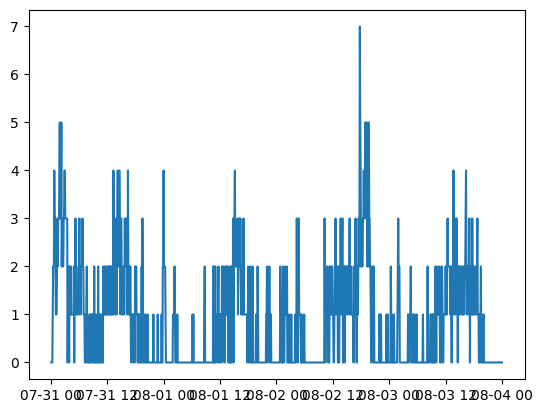

In [17]:
final_combined_df = final_combined_df.loc[(final_combined_df['datetime'] >= "2024-07-31 00:00:00")\
										  &(final_combined_df['datetime'] <= "2024-08-04 00:00:00")]
plt.plot(final_combined_df['datetime'], final_combined_df['windspeed'])


#### Validate data (scatterplot figure)

In [71]:
import pandas as pd
import numpy as np
from datetime import * 
import matplotlib.pyplot as plt
from run_foco import run_foco
from validation import * 

start_date_time = '2024-07-15 10:00:00'
end_date_time = '2024-08-14 13:30:00'

import logging
filename = 'validation.log'
logging.basicConfig(filename=filename, level=logging.INFO, format='%(asctime)s - %(message)s')
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)
# Clear the log file
with open(filename, 'w'):
    pass  # This opens and immediately closes the file, truncating it



# import, load, and smooth data from raspi
def import_data(path, logging, window_length, polyorder, columns_to_drop = ['sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'fan']):
	from scipy.signal import savgol_filter
	sensor_readings_df = pd.read_csv(path)
	#print(sensor_readings_df.head(5))
	sensor_readings_df = sensor_readings_df.set_index('timestamp')

	# Drop columns with all zeros
	all_zero_cols = sensor_readings_df.columns[(sensor_readings_df == 0).all()]
	print(all_zero_cols)
	sensor_readings_df.index = pd.to_datetime(sensor_readings_df.index)
	for col in columns_to_drop:
		try:
			sensor_readings_df.drop(columns=[col], inplace=True)
		except Exception as e:
			logging.info("error excepted", e)
	sensor_readings_df.index = sensor_readings_df.index.round('s')
	sensor_readings_df.drop(columns=all_zero_cols, inplace=True)

	# Define the window length and polynomial order
	smoothed_df = pd.DataFrame()
	smoothed_df.index = sensor_readings_df.index

	logging.info("*** Data Loaded ***")

	# Apply the Savitzky-Golay filter to each column after cleaning zeros
	for col in sensor_readings_df.columns:
		# Clean the column by removing zeros
		cleaned_col = sensor_readings_df[col].replace(0, np.nan)

		# Apply the Savitzky-Golay filter if there are enough data points
		if len(cleaned_col) >= window_length:
			smoothed_df[col[-1] + '_smooth'] = savgol_filter(cleaned_col, window_length, polyorder)
		else:
			logging.warning("Not enough data points in column %s to apply Savitzky-Golay filter", col)
			smoothed_df[col[-1] + '_smooth'] = pd.NA

	return sensor_readings_df, smoothed_df


Index([], dtype='object')
Fan speed: 0.0
start date 2024-07-15
end date 2024-08-14
wind_speed_factor 1
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


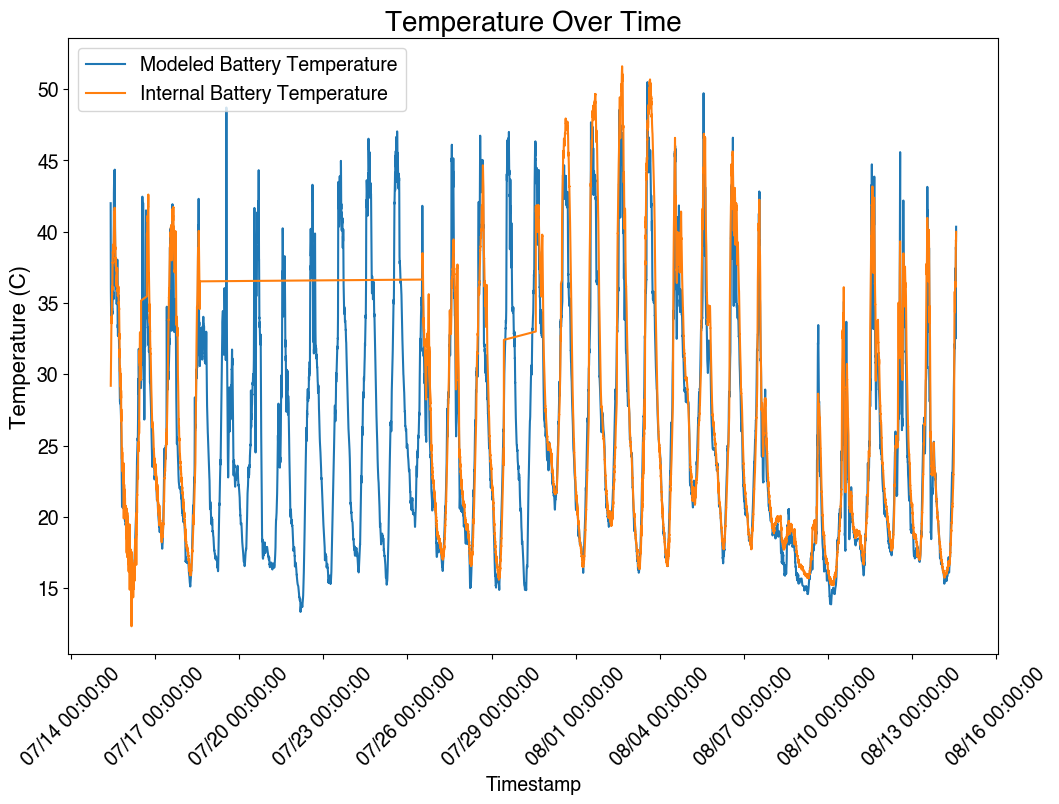

In [72]:
sensor_df, smoothed_df = import_data("sensor_readings_all.csv",  logging, 59, 2, columns_to_drop = [
       'sensor_5', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15'
	   ])
logging.info("*** Retrieved Raspi Data ***")

results_dir = run_foco(logging = log, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad =  True, h_max = 100, 
					   emissivity = 0.92, absorptivity=0.94, rho = 1070, Cp = 1990, k = 0.162,
						heat_generation = 0, fan_flow = 0, T_initial=42 + 273.15,fan_threshold = 50, shading = False, 
						shading_ranges = [('10:00:00', '12:30:00')])

logging.info("Directories: " + results_dir)
model_df_ABS = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

import validation

validation.plot_comparison(smoothed_df, [{'data':model_df_ABS, 'label': "Modeled Battery Temperature"}],
				start_date_time, end_date_time, col1 = "2_smooth", col2 = "2_smooth")

Index([], dtype='object')


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


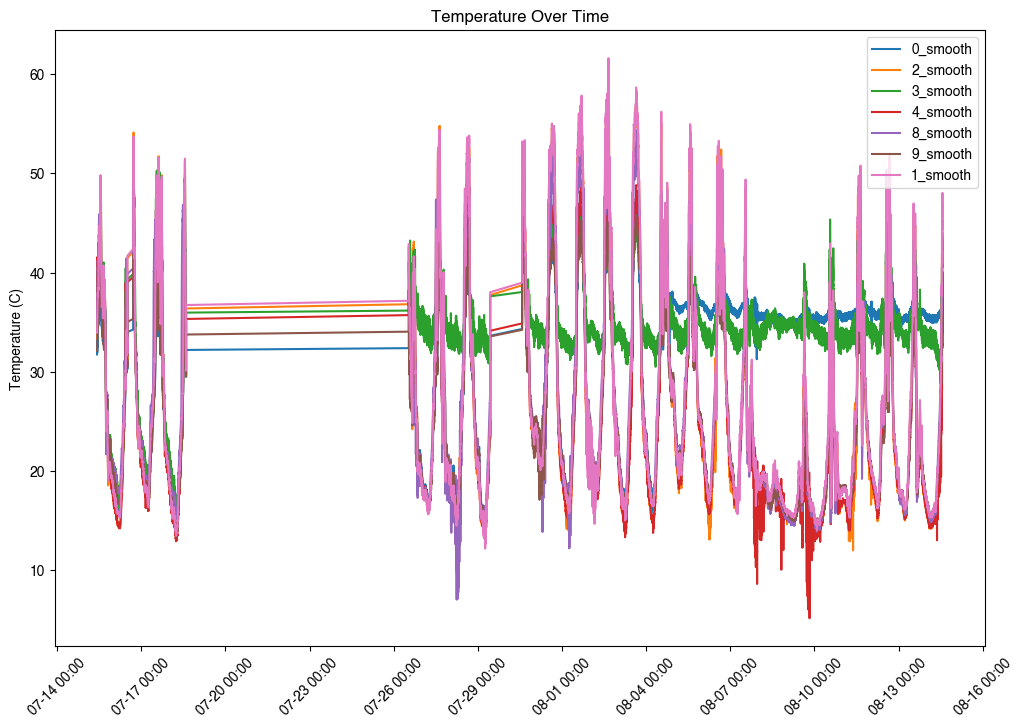

In [73]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

others_df, smoothed_others_df = import_data("sensor_readings_all.csv",  logging, 59, 2, columns_to_drop = [
       'sensor_0', 'sensor_1',  
	'sensor_5', 'sensor_6', 'sensor_7','sensor_15'])

fig, ax = plt.subplots(figsize = (12,8))
for col in smoothed_others_df:
	plt.plot(smoothed_others_df[col], label = col)

ax.xaxis.set_major_locator(plt.MaxNLocator(12))  # Limit to 12 date labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylabel('Temperature (C)')
plt.title("Temperature Over Time")
plt.legend()
plt.show()


Fan speed: 0.0
start date 2024-07-15
end date 2024-08-14
wind_speed_factor 1
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


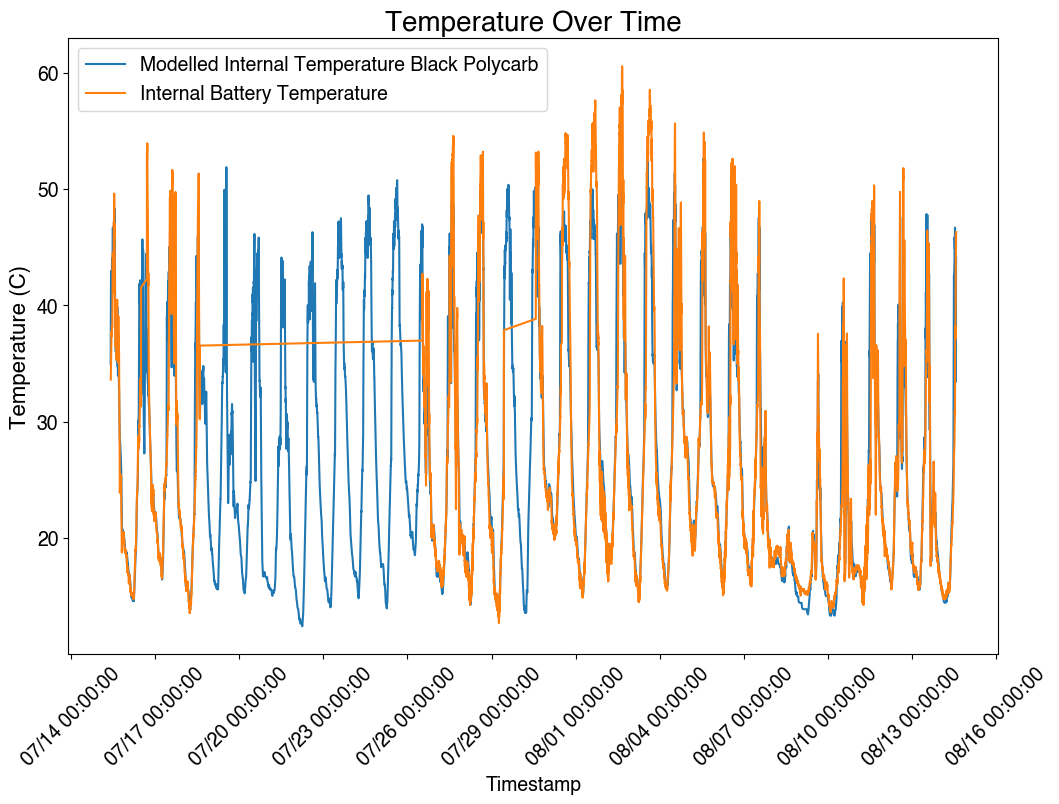

In [74]:
results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=35 + 273.15,fan_threshold = 50,
						k=0.216,
						rho=1200,
						Cp=1650,
						emissivity=2,
						absorptivity=2,
                        L = 0.183,
                        H = 0.109,
                        W = 0.133,
                        thicknesses=[0.006, 0.006, 0.006, 0.006, 0.006, 0.006])

logging.info("Directories: " + results_dir)
model_df_polycarb = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

plot_comparison(smoothed_others_df, [{'data':model_df_polycarb, 'label': "Modelled Internal Temperature Black Polycarb"}, 
							  ],
				start_date_time, end_date_time, col1 = '1_smooth', col2 = '2_smooth')

Fan speed: 0.0
start date 2024-07-15
end date 2024-08-14
wind_speed_factor 1
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


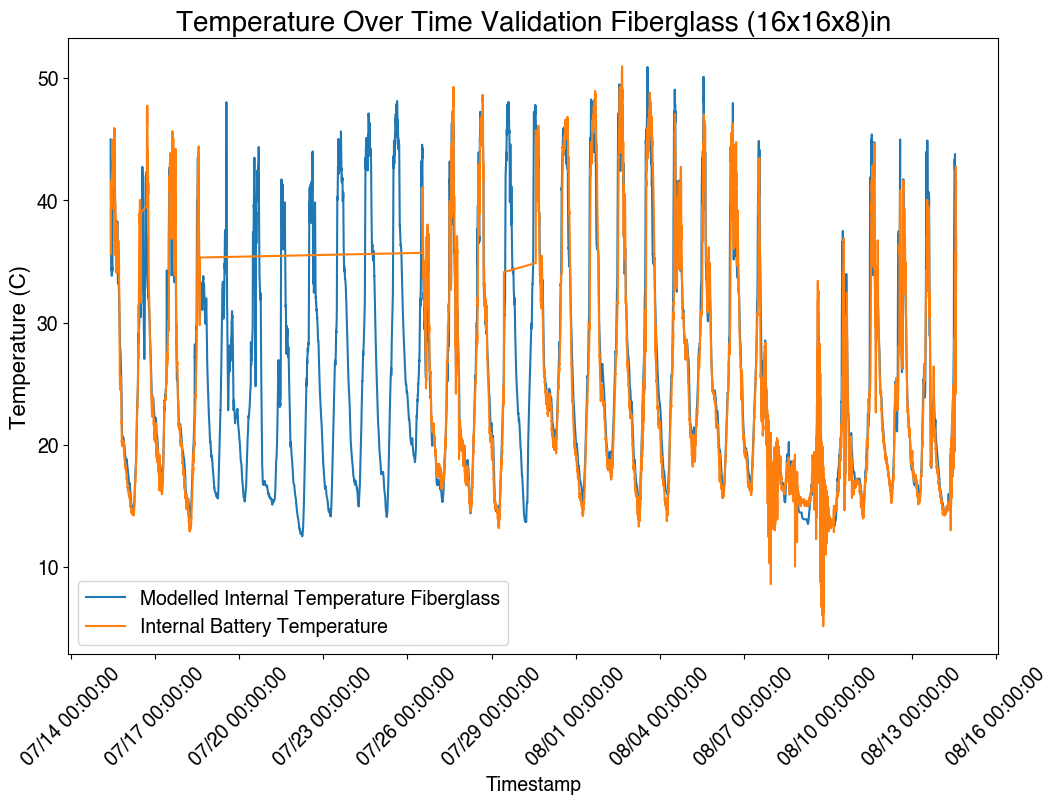

In [75]:
# start_date_time = '2024-07-31 12:10:00'
# end_date_time = '2024-08-03 13:30:00'

import validation

results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
						k=0.216,
						rho=1370,
						Cp=1300,
						emissivity=0.92,
                        L = 0.4,
                        H = 0.2,
                        W = 0.4,
                        thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
						shading_ranges = [('10:00:00', '11:30:00')],
						#shading=False,
						#shading_ranges = []
						)

logging.info("Directories: " + results_dir)
model_df_fiberglass = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

validation.plot_comparison(smoothed_others_df, [{'data':model_df_fiberglass, 'label': "Modelled Internal Temperature Fiberglass"}],
				start_date_time, end_date_time, col1 = '4_smooth', col2 = '4_smooth',
				title = "Temperature Over Time Validation Fiberglass (16x16x8)in")

Fan speed: 0.0
start date 2024-07-15
end date 2024-08-14
wind_speed_factor 1
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


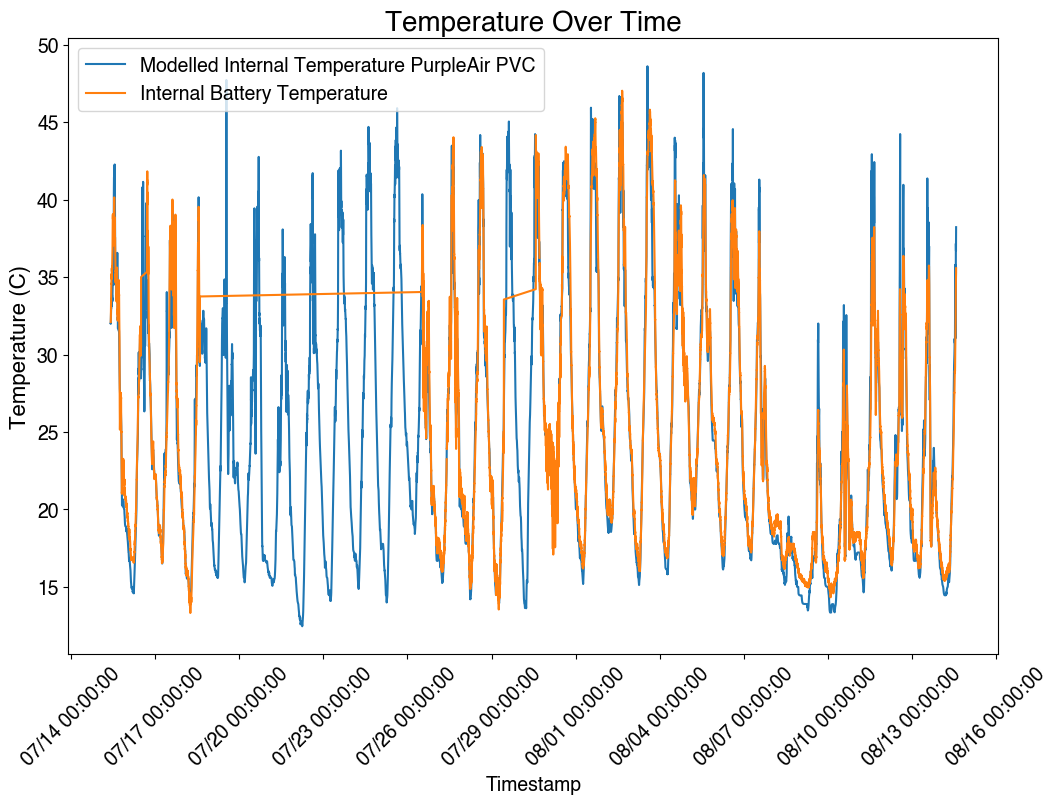

In [76]:

results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=32 + 273.15,fan_threshold = 50,
						k=0.157,
						rho=900,
						Cp=1390,
						emissivity=0.92,
                        L = 0.08,
                        H = 0.08,
                        W = 0.08,
                        thicknesses=[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
						shading_ranges = [('10:00:00', '12:30:00')])

logging.info("Directories: " + results_dir)
model_df_pvc = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

plot_comparison(smoothed_others_df, [{'data':model_df_pvc, 'label': "Modelled Internal Temperature PurpleAir PVC"}, 
							  ],
				start_date_time, end_date_time, col1 = '9_smooth', col2 = '9_smooth')

In [77]:

results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=32 + 273.15,fan_threshold = 50,
						k=92,
						rho=2823,
						Cp=963,
						emissivity=0.9,
                        L = 0.074,
                        H = 0.052,
                        W = 0.08,
                        thicknesses=[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
						shading_ranges = [('10:00:00', '12:30:00')])

logging.info("Directories: " + results_dir)
model_df_aluminum = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

plot_comparison(smoothed_others_df, [{'data':model_df_pvc, 'label': "Modelled Internal Temperature Aluminum"}, 
							  ],
				start_date_time, end_date_time, col1 = '8_smooth', col2 = '8_smooth')

Fan speed: 0.0
start date 2024-07-15
end date 2024-08-14


KeyboardInterrupt: 

In [78]:
# model_df_aluminum = model_df_pvc
# model_df_aluminum.to_pickle("aluminum.pkl")

model_df_aluminum = pd.read_pickle("aluminum.pkl")

In [79]:
#Resampling
def kelvin_to_fahrenheit(kelvin):
    return (kelvin - 273.15) 

resample_period = '15min'

#model_df_fiberglass =  model_df_fiberglass.loc[(model_df_fiberglass.index >= start_date_time) & (model_df_fiberglass.index <= end_date_time)] 


model_df_aluminum_10 = kelvin_to_fahrenheit(model_df_aluminum.resample(resample_period).mean())
model_df_ABS_10 = kelvin_to_fahrenheit(model_df_ABS.resample(resample_period).mean())
model_df_pvc_10 = kelvin_to_fahrenheit(model_df_pvc.resample(resample_period).mean())
model_df_fiberglass_10 = kelvin_to_fahrenheit(model_df_fiberglass.resample(resample_period).mean())

start_date_time = '2024-07-15 12:10:00'
end_date_time = '2024-08-14 13:33:00'

others_df = others_df.loc[(others_df.index >= start_date_time) & (others_df.index <= end_date_time)] 
others_df_10 = others_df.resample(resample_period).mean()
real_aluminum_10 = others_df_10['sensor_8'].dropna()
real_fiberglass_10 = others_df_10['sensor_14'].dropna()
real_ABS_10 = (others_df_10['sensor_2'] + others_df_10['sensor_3']).dropna() * 0.5
real_pvc_10 = others_df_10['sensor_9'].dropna() #+ others_df_10['sensor_10']) * 0.5

In [80]:
# model_df_fiberglass_10 = model_df_fiberglass_10[(model_df_fiberglass_10.index >= "2024-08-07 08:00:00") & (model_df_fiberglass_10.index <= "2024-08-10 00:00:00")]
# real_fiberglass_10 = real_fiberglass_10[(real_fiberglass_10.index >= "2024-08-07 08:00:00") & (real_fiberglass_10.index <= "2024-08-10 00:00:00")]
model_df_aluminum_10 = model_df_aluminum_10.loc[model_df_aluminum_10.index.intersection(real_aluminum_10.index)]
model_df_ABS_10 = model_df_ABS_10.loc[model_df_ABS_10.index.intersection(real_ABS_10.index)]
model_df_pvc_10 = model_df_pvc_10.loc[model_df_pvc_10.index.intersection(real_pvc_10.index)]
model_df_fiberglass_10 = model_df_fiberglass_10.loc[model_df_fiberglass_10.index.intersection(real_fiberglass_10.index)]


In [81]:
real_fiberglass_10.index

DatetimeIndex(['2024-07-15 12:00:00', '2024-07-15 12:15:00',
               '2024-07-15 12:30:00', '2024-07-15 12:45:00',
               '2024-07-15 13:00:00', '2024-07-15 13:15:00',
               '2024-07-15 13:30:00', '2024-07-15 13:45:00',
               '2024-07-15 14:00:00', '2024-07-15 14:15:00',
               ...
               '2024-08-14 11:15:00', '2024-08-14 11:30:00',
               '2024-08-14 11:45:00', '2024-08-14 12:00:00',
               '2024-08-14 12:15:00', '2024-08-14 12:30:00',
               '2024-08-14 12:45:00', '2024-08-14 13:00:00',
               '2024-08-14 13:15:00', '2024-08-14 13:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=1997, freq=None)

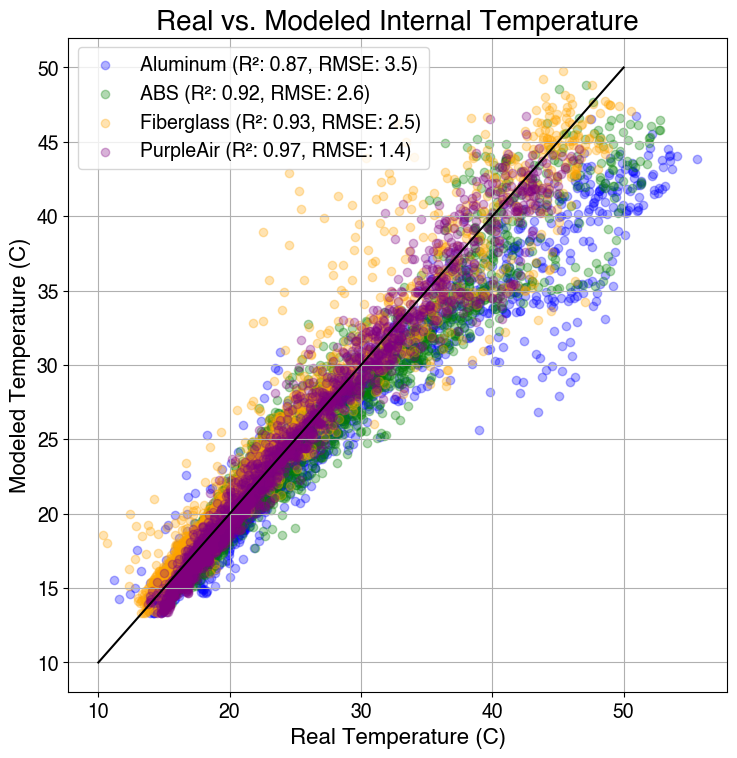

<Figure size 640x480 with 0 Axes>

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define RMSE function
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 1)

# Define R² function
def r_squared(y_true, y_pred):
    return round(r2_score(y_true, y_pred), 2)

def r_squared_slope1_intercept0(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return round(1 - (ss_res / ss_tot),2)

# Calculate RMSE for each test
rmse_values = {}
rmse_values['pvc'] = rmse(real_pvc_10, model_df_pvc_10['internal'])
rmse_values['ABS'] = rmse(real_ABS_10, model_df_ABS_10['internal'])
rmse_values['fiberglass'] = rmse(real_fiberglass_10, model_df_fiberglass_10['internal'])
rmse_values['aluminum'] = rmse(real_aluminum_10, model_df_aluminum_10['internal'])

# Calculate R² assuming slope = 1 and intercept = 0
r2_values = {}
r2_values['pvc'] = r_squared_slope1_intercept0(real_pvc_10, model_df_pvc_10['internal'])
r2_values['ABS'] = r_squared_slope1_intercept0(real_ABS_10, model_df_ABS_10['internal'])
r2_values['fiberglass'] = r_squared_slope1_intercept0(real_fiberglass_10, model_df_fiberglass_10['internal'])
r2_values['aluminum'] = r_squared_slope1_intercept0(real_aluminum_10, model_df_aluminum_10['internal'])

# Create scatter plot
plt.figure(figsize=(8.5, 8.5))

battery_failure = 40
alpha = 0.3

# Plot with RMSE and R² in labels
plt.scatter(real_aluminum_10, model_df_aluminum_10['internal'], color="blue", alpha=alpha, 
            label=f"Aluminum (R²: {r2_values['aluminum']}, RMSE: {rmse_values['aluminum']})")
plt.scatter(real_ABS_10, model_df_ABS_10['internal'], color="green", alpha=alpha, 
            label=f"ABS (R²: {r2_values['ABS']}, RMSE: {rmse_values['ABS']})")
plt.scatter(real_fiberglass_10, model_df_fiberglass_10['internal'], color="orange", alpha=alpha, 
            label=f"Fiberglass (R²: {r2_values['fiberglass']}, RMSE: {rmse_values['fiberglass']})")
plt.scatter(real_pvc_10, model_df_pvc_10['internal'], color="purple", alpha=alpha, 
            label=f"PurpleAir (R²: {r2_values['pvc']}, RMSE: {rmse_values['pvc']})")

# Plot the identity line (real = modeled) and battery failure threshold
plt.plot(np.linspace(10, 50), np.linspace(10, 50), color='black')
#plt.plot(np.full(50, battery_failure), np.linspace(10, 50), color='red', label='Battery Failure')
#plt.plot(np.linspace(10, 50), np.full(50, battery_failure), color='red')

# Labels and formatting
plt.xlabel('Real Temperature (C)', fontsize=16)
plt.ylabel('Modeled Temperature (C)', fontsize=16)
plt.title('Real vs. Modeled Internal Temperature', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="upper left")
plt.grid(True)

# Show and save plot
plt.show()
plt.savefig("real_vs_modeled_figure.jpg")


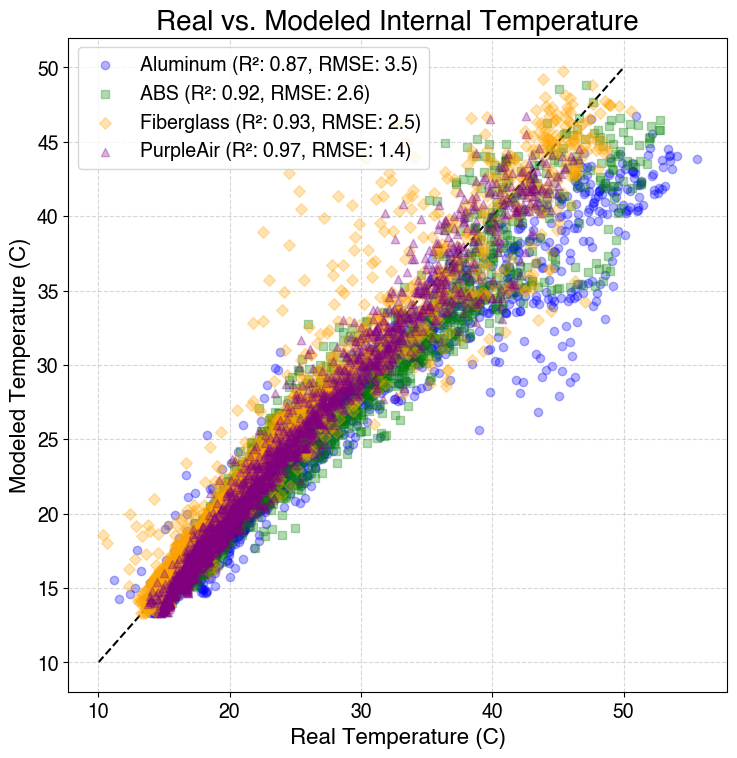

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define RMSE function
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 1)

# Define R² function assuming slope=1 and intercept=0
def r_squared_slope1_intercept0(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return round(1 - (ss_res / ss_tot), 2)

# Calculate RMSE for each test
rmse_values = {
    'pvc': rmse(real_pvc_10, model_df_pvc_10['internal']),
    'ABS': rmse(real_ABS_10, model_df_ABS_10['internal']),
    'fiberglass': rmse(real_fiberglass_10, model_df_fiberglass_10['internal']),
    'aluminum': rmse(real_aluminum_10, model_df_aluminum_10['internal'])
}

# Calculate R² assuming slope = 1 and intercept = 0
r2_values = {
    'pvc': r_squared_slope1_intercept0(real_pvc_10, model_df_pvc_10['internal']),
    'ABS': r_squared_slope1_intercept0(real_ABS_10, model_df_ABS_10['internal']),
    'fiberglass': r_squared_slope1_intercept0(real_fiberglass_10, model_df_fiberglass_10['internal']),
    'aluminum': r_squared_slope1_intercept0(real_aluminum_10, model_df_aluminum_10['internal'])
}

# Define marker styles for colorblind-friendly differentiation
markers = {
    'aluminum': "o",   # Circle
    'ABS': "s",        # Square
    'fiberglass': "D", # Diamond
    'pvc': "^"         # Triangle
}

# Create scatter plot
plt.figure(figsize=(8.5, 8.5))

battery_failure = 40
alpha = 0.3  # Retained original alpha

# Grid in the background
plt.grid(True, linestyle="--", alpha=0.5, zorder=0)

# Scatter plots with distinct markers
plt.scatter(real_aluminum_10, model_df_aluminum_10['internal'], color="blue", alpha=alpha, marker=markers['aluminum'],
            label=f"Aluminum (R²: {r2_values['aluminum']}, RMSE: {rmse_values['aluminum']})", zorder=2)
plt.scatter(real_ABS_10, model_df_ABS_10['internal'], color="green", alpha=alpha, marker=markers['ABS'],
            label=f"ABS (R²: {r2_values['ABS']}, RMSE: {rmse_values['ABS']})", zorder=2)
plt.scatter(real_fiberglass_10, model_df_fiberglass_10['internal'], color="orange", alpha=alpha, marker=markers['fiberglass'],
            label=f"Fiberglass (R²: {r2_values['fiberglass']}, RMSE: {rmse_values['fiberglass']})", zorder=2)
plt.scatter(real_pvc_10, model_df_pvc_10['internal'], color="purple", alpha=alpha, marker=markers['pvc'],
            label=f"PurpleAir (R²: {r2_values['pvc']}, RMSE: {rmse_values['pvc']})", zorder=2)

# Identity line (perfect correlation)
plt.plot(np.linspace(10, 50), np.linspace(10, 50), color='black', linestyle="--", linewidth=1.5, zorder=1)

# Labels and formatting
plt.xlabel('Real Temperature (C)', fontsize=16)
plt.ylabel('Modeled Temperature (C)', fontsize=16)
plt.title('Real vs. Modeled Internal Temperature', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)  # No change as per request
plt.legend(fontsize=14, loc="upper left")
plt.show()


### Running NASA vs. Weather Station Figure50

In [109]:
# Confirming NASA data can be run recent enough

from numerical_modelling import get_data, get_timezone
from datetime import datetime as datetime

import logging
filename = 'validation.log'
logging.basicConfig(filename=filename, level=logging.INFO, format='%(asctime)s - %(message)s')
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)

latitude=40.5853
longitude=-105.0844

timezone = get_timezone(latitude, longitude)

start_date_time = '2023-07-26 13:00:00'
end_date_time = '2023-07-29 10:30:00'


start_date_time = datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S')
end_date_time = datetime.strptime(end_date_time, '%Y-%m-%d %H:%M:%S')

df_mean = get_data(latitude=latitude, 
				   longitude=longitude, 
                   start_date_time = start_date_time,
                   end_date_time = end_date_time,
                   timezone = timezone,
                   logging = logging,
                   stop_event = None
)

df_mean

Datetime  DNI  Temperature  Wind Speed            datetime   seconds
0   2023072600  0.0        21.23        4.03 2023-07-26 00:00:00       0.0
1   2023072601  0.0        20.79        4.54 2023-07-26 01:00:00    3600.0
2   2023072602  0.0        20.27        4.54 2023-07-26 02:00:00    7200.0
3   2023072603  0.0        19.80        4.17 2023-07-26 03:00:00   10800.0
4   2023072604  0.0        19.68        4.11 2023-07-26 04:00:00   14400.0
..         ...  ...          ...         ...                 ...       ...
91  2023072919  0.0        24.26        4.20 2023-07-29 19:00:00  327600.0
92  2023072920  0.0        22.58        3.93 2023-07-29 20:00:00  331200.0
93  2023072921  0.0        21.40        3.06 2023-07-29 21:00:00  334800.0
94  2023072922  0.0        20.76        2.40 2023-07-29 22:00:00  338400.0
95  2023072923  0.0        20.12        2.31 2023-07-29 23:00:00  342000.0

[96 rows x 6 columns]

Fan speed: 0.0
start date 2024-07-26
end date 2024-07-29
wind_speed_factor 1
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:262: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



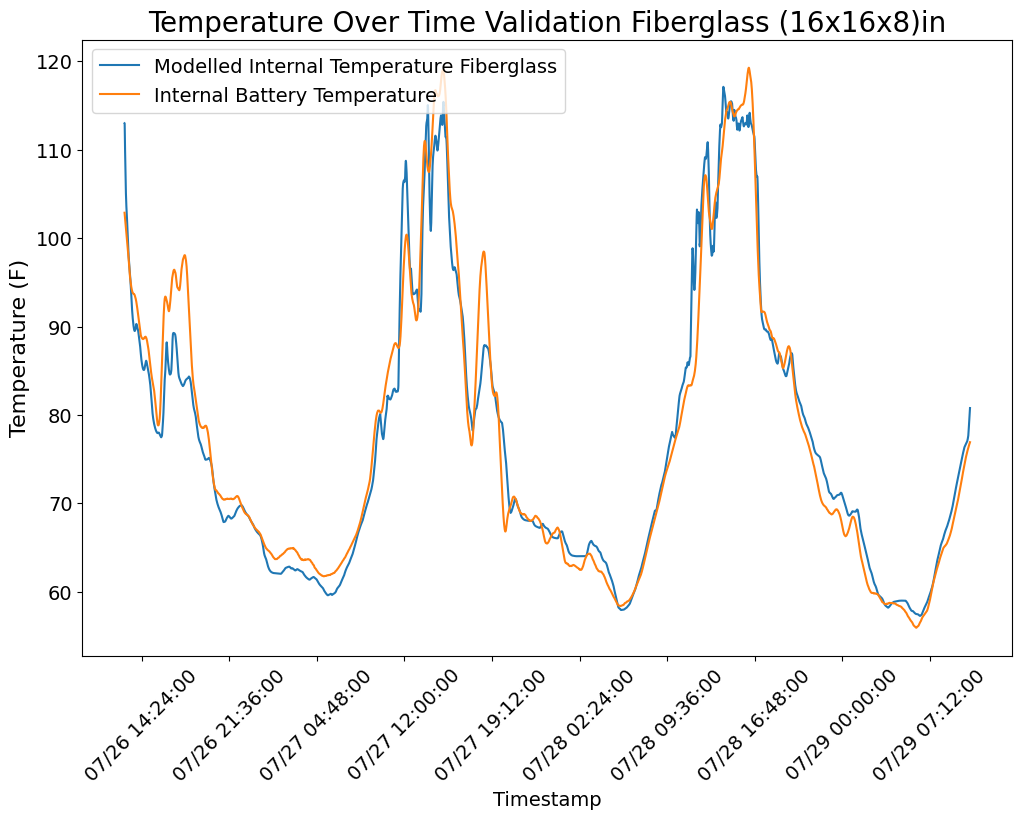

In [130]:
import pandas as pd
import numpy as np
from datetime import * 
import matplotlib.pyplot as plt
from run_foco import run_foco
from validation import * 

start_date_time = '2024-07-26 13:00:00'
end_date_time = '2024-07-29 10:30:00'


sensor_df, smoothed_df = import_data("../real_data/sensor_readings_2024_07_26_12_49.csv",  logging, 59, 2, columns_to_drop = [
       'sensor_5', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15'])
logging.info("*** Retrieved Raspi Data ***")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# data from the various enclosures
others_df, smoothed_others_df = import_data("../real_data/sensor_readings_2024_07_26_12_49.csv",  logging, 59, 2, columns_to_drop = [
       'sensor_0', 'sensor_1', 'sensor_2',
       'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7','sensor_13', 'sensor_15'])

# run foco model
results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 8, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
						k=0.216,
						rho=1370,
						Cp=1300,
						emissivity=0.92,
                        L = 0.4,
                        H = 0.2,
                        W = 0.4,
                        thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
						shading_ranges = [('10:00:00', '11:30:00')],)

logging.info("Directories: " + results_dir)
model_df_fiberglass = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

plot_comparison(smoothed_others_df, [{'data':model_df_fiberglass, 'label': "Modelled Internal Temperature Fiberglass"}],
				start_date_time, end_date_time, col1 = '4_smooth', col2 = '4_smooth',
				title = "Temperature Over Time Validation Fiberglass (16x16x8)in")

In [111]:
smoothed_others_df['4_smooth'].max()

np.float64(48.4892294643269)

In [140]:
from run_anywhere import run_anywhere

start_date_time = '2024-07-26 10:00:00'
end_date_time = '2024-07-29 14:30:00'


latitude=40.5853
longitude=-105.0844

lower_dir, upper_dir, results_dir = run_anywhere(logging = logging, latitude = latitude, longitude = longitude,
												 start_date_time = start_date_time, end_date_time = end_date_time, N = 4,  h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=15 + 273.15,fan_threshold = 50,
						k=0.216,
						rho=1370,
						Cp=1300,
						emissivity=0.92,
						absorptivity = 0.92,
                        L = 0.4,
                        H = 0.2,
                        W = 0.4,
                        thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
						#shading_ranges = [('10:00:00', '11:30:00')],
						bounded = True,
                        quantiles =[0.1, 0.9])

In [141]:
model_df_NASA_fiberglass = load_data(results_dir, base_time = datetime(2024, 7, 26, 10, 0, 0))
model_df_NASA_fiberglass_upper = load_data(upper_dir, base_time = datetime(2024, 7, 26, 10, 0, 0))
model_df_NASA_fiberglass_lower = load_data(lower_dir, base_time = datetime(2024, 7, 26, 10, 0, 0))


In [142]:
model_df_NASA_fiberglass_lower.index += pd.Timedelta(hours = 2)
model_df_NASA_fiberglass_upper.index += pd.Timedelta(hours = 2)
model_df_NASA_fiberglass.index += pd.Timedelta(hours = 2)


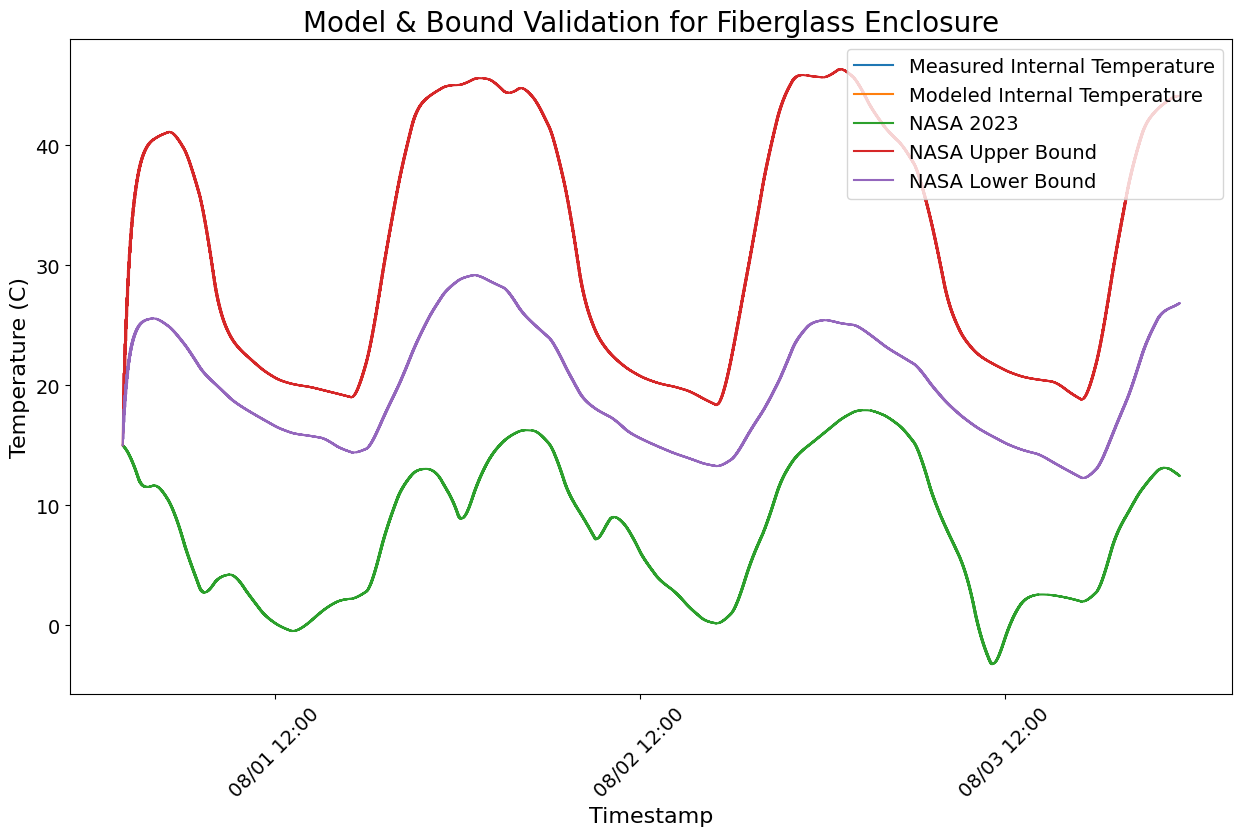

In [135]:
def plot_comparison(smoothed_df, model_dfs, start_date_time, end_date_time, col1 = '2_smooth', col2 = '3_smooth', title = "Temperature Over Time"):
	"""
	Plot a comparison of real-world smoothed sensor data and modeled temperature data.

	Parameters:
	smoothed_df (pd.DataFrame): DataFrame with smoothed sensor readings.
	model_dfs (list): List of dictionaries with model data and their labels.
	start_date_time (datetime): Start time for the comparison plot.
	end_date_time (datetime): End time for the comparison plot.
	col1 (str): Column name for the first sensor reading for battery temperature averaging.
	col2 (str): Column name for the second sensor reading for battery temperature averaging.
	title (str): Title of the plot.

	Returns:
	None

	Notes:
	The Celsius data is converted to Fahrenheit, and the plot is saved as a PNG file.
	"""

	def to_F(num):
		return num
	
	import matplotlib.dates as mdates
	#smoothed_df = smoothed_df.loc[(smoothed_df.index >= start_date_time) & (smoothed_df.index <= end_date_time)]

	smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])

	fig, ax = plt.subplots(figsize = (15,8.5))
	plt.plot(to_F(smoothed_df['batt_avg']), label = "Measured Internal Temperature")

	#plt.plot(smoothed_df['2_smooth'], label = "battery2 temperature with smoothing", color = "red")
	#plt.plot(smoothed_df['3_smooth'], label = "battery3 temperature with smoothing", color = "red")

	for model_dict in model_dfs:
		plt.plot(to_F((model_dict['data'])['internal']-273.15), label = model_dict['label'])
		#plt.plot((model_dict['data'])['battery_temp']-273.15, label = "modelled battery temp")

	ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[12]))
	#ax.xaxis.set_major_locator(plt.MaxNLocator(12))  # Limit to 12 date labels
	ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))

	plt.xticks(rotation=45, fontsize = 14)  # Rotate x-axis labels for better readability
	plt.yticks(fontsize = 14)
	plt.ylabel('Temperature (C)', fontsize = 16)
	plt.xlabel("Timestamp", fontsize = 16)
	plt.title(title, fontsize = 20)
	plt.legend(fontsize = 14, loc="upper right")
	plt.show()


plot_comparison(smoothed_others_df[(smoothed_others_df.index >= "2024-08-1 02:00:00") & (smoothed_others_df.index <= "2024-08-14 06:00:00")], [
	{'data':model_df_fiberglass[(model_df_fiberglass.index >= "2024-08-1 02:00:00") & (model_df_fiberglass.index <= "2024-08-14 06:00:00")], 'label': "Modeled Internal Temperature"},
	{'data':model_df_NASA_fiberglass, 'label': "NASA 2023"},
	{'data':model_df_NASA_fiberglass_upper, 'label': "NASA Upper Bound"},
	{'data':model_df_NASA_fiberglass_lower, 'label': "NASA Lower Bound"}
	],
				start_date_time, end_date_time, col1 = '4_smooth', col2 = '4_smooth',
				title = "Model & Bound Validation for Fiberglass Enclosure")


In [136]:
smoothed_others_df

8_smooth   9_smooth   0_smooth   1_smooth   2_smooth  \
timestamp                                                                    
2024-07-26 12:49:00  39.891488  38.062801  35.291761  42.664474  42.414446   
2024-07-26 12:50:00  39.799494  37.898213  35.370071  42.415598  42.206798   
2024-07-26 12:51:00  39.705608  37.734636  35.446550  42.170232  42.001253   
2024-07-26 12:52:00  39.609829  37.572071  35.521197  41.928374  41.797812   
2024-07-26 12:53:00  39.512157  37.410517  35.594012  41.690026  41.596475   
...                        ...        ...        ...        ...        ...   
2024-07-29 10:26:00  27.789827  25.033191  24.987718  25.671662  25.202167   
2024-07-29 10:27:00  27.837818  25.089213  25.043312  25.728551  25.260230   
2024-07-29 10:28:00  27.885370  25.145071  25.098932  25.785437  25.318138   
2024-07-29 10:29:00  27.932482  25.200766  25.154579  25.842322  25.375890   
2024-07-29 10:30:00  27.979154  25.256298  25.210251  25.899204  25.433487   

                      4_smooth  
timestamp                       
2024-07-26 12:49:00  41.058224  
2024-07-26 12:50:00  40.901469  
2024-07-26 12:51:00  40.745469  
2024-07-26 12:52:00  40.590223  
2024-07-26 12:53:00  40.435731  
...                        ...  
2024-07-29 10:26:00  24.792844  
2024-07-29 10:27:00  24.833495  
2024-07-29 10:28:00  24.873196  
2024-07-29 10:29:00  24.911947  
2024-07-29 10:30:00  24.949748  

[4182 rows x 6 columns]

In [119]:
# others_df, smoothed_others_df = import_data("../real_data/sensor_readings_2024_07_31_12_09.csv",  logging, 59, 2, columns_to_drop = [
#        'sensor_0', 'sensor_1', 'sensor_2',
#        'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7','sensor_13', 'sensor_15'])


/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_66694/1856244398.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



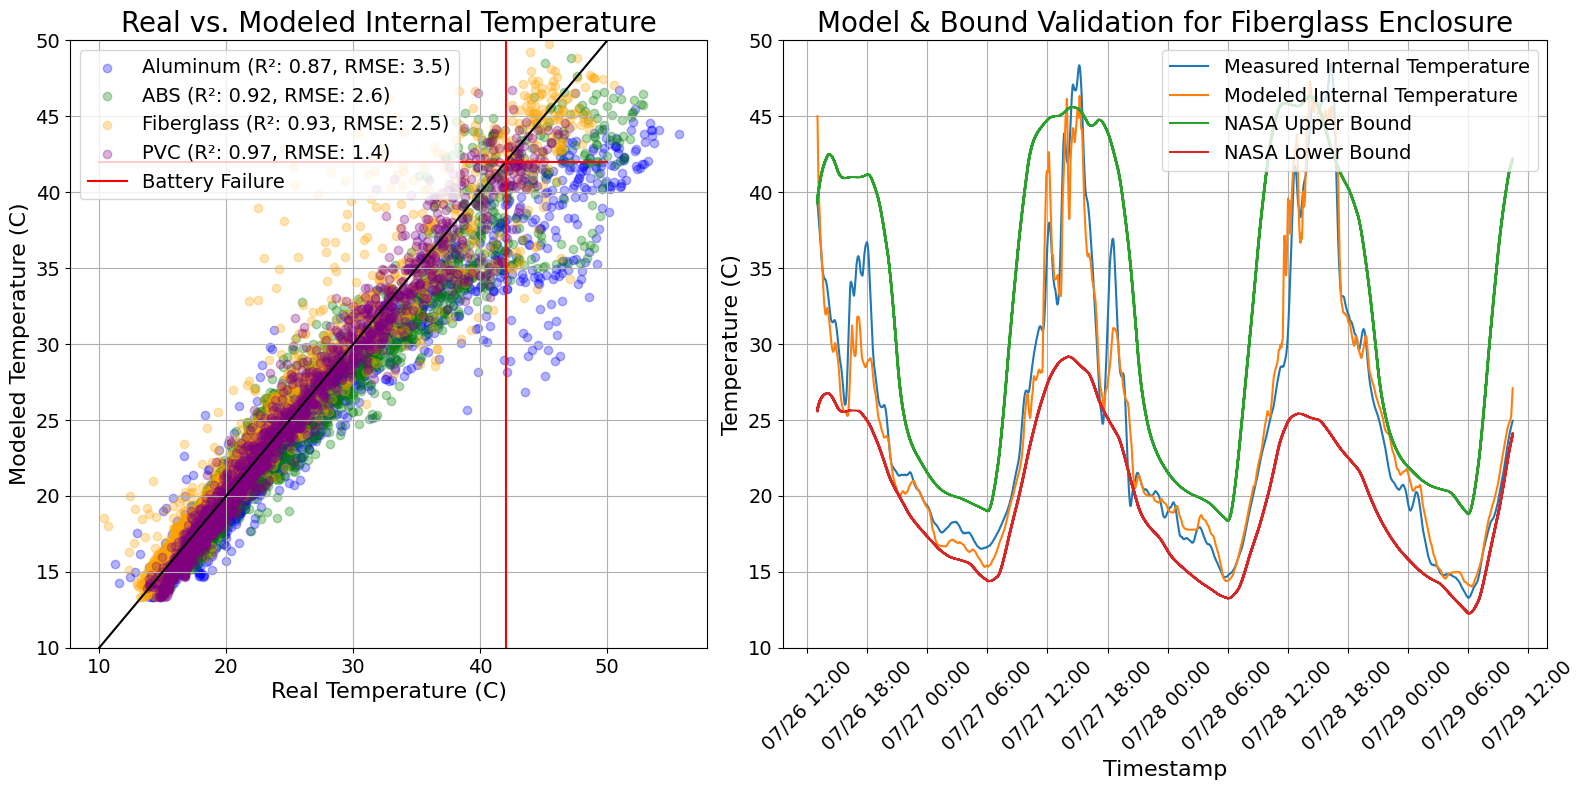

<Figure size 640x480 with 0 Axes>

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates

start_date_time = '2024-07-26 13:00:00'
end_date_time = '2024-07-29 10:30:00'

# Define RMSE function
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 1)

# Define R² function
def r_squared(y_true, y_pred):
    return round(r2_score(y_true, y_pred), 2)

# Define to_F function to convert values
def to_F(num):
    return num  # Adjust if you need Fahrenheit conversion

# Create a function for the time series comparison plot
def plot_comparison(smoothed_df, model_dfs, start_date_time, end_date_time, col1='2_smooth', col2='3_smooth', title="Temperature Over Time"):
    """
    Plot a comparison of real-world smoothed sensor data and modeled temperature data.
    """
    smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])

    fig, axs = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1.2]})  # Create a figure with 2 plots side by side

    # First subplot: Scatter Plot
    battery_failure = 42
    alpha = 0.3
    # Plot the scatter points with RMSE and R² in labels
    axs[0].scatter(real_aluminum_10, model_df_aluminum_10['internal'], color="blue", alpha=alpha, 
                    label=f"Aluminum (R²: {r2_values['aluminum']}, RMSE: {rmse_values['aluminum']})")
    axs[0].scatter(real_ABS_10, model_df_ABS_10['internal'], color="green", alpha=alpha, 
                    label=f"ABS (R²: {r2_values['ABS']}, RMSE: {rmse_values['ABS']})")
    axs[0].scatter(real_fiberglass_10, model_df_fiberglass_10['internal'], color="orange", alpha=alpha, 
                    label=f"Fiberglass (R²: {r2_values['fiberglass']}, RMSE: {rmse_values['fiberglass']})")
    axs[0].scatter(real_pvc_10, model_df_pvc_10['internal'], color="purple", alpha=alpha, 
                    label=f"PVC (R²: {r2_values['pvc']}, RMSE: {rmse_values['pvc']})")

    axs[0].plot(np.linspace(10, 50), np.linspace(10, 50), color='black')
    axs[0].plot(np.full(50, battery_failure), np.linspace(10, 50), color='red', label='Common Lithium-Ion Battery Failure')
    axs[0].plot(np.linspace(10, 50), np.full(50, battery_failure), color='red')
    axs[0].set_xlabel('Real Temperature (C)', fontsize=16)
    axs[0].set_ylabel('Modeled Temperature (C)', fontsize=16)
    axs[0].set_title('Real vs. Modeled Internal Temperature', fontsize=20)
    axs[0].legend(fontsize=14, loc="upper left")
    axs[0].tick_params(axis='x', labelsize=14)
    axs[0].tick_params(axis='y', labelsize=14)
    axs[0].grid(True)

    # Second subplot: Time Series Plot
    axs[1].plot(to_F(smoothed_df['batt_avg']), label="Measured Internal Temperature")
    for model_dict in model_dfs:
        axs[1].plot(to_F(model_dict['data']['internal'] - 273.15), label=model_dict['label'])
    axs[1].xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    axs[1].set_xlabel("Timestamp", fontsize=16)
    axs[1].set_ylabel('Temperature (C)', fontsize=16)
    axs[1].set_title(title, fontsize=20)
    axs[1].legend(fontsize=14, loc="upper right")
    axs[1].grid(True)
    axs[1].tick_params(axis='x', rotation=45, labelsize=14)
    axs[1].tick_params(axis='y', labelsize=14)


    # Show combined figure
    plt.tight_layout()
    min_y = 10
    max_y = 50

    axs[0].set_ylim(min_y, max_y)
    axs[1].set_ylim(min_y, max_y)
    plt.show()

    plt.savefig("combined_fig.jpg")

# Plot the combined figure using the function
plot_comparison(
    smoothed_others_df[(smoothed_others_df.index >= start_date_time) & (smoothed_others_df.index <= end_date_time)],
    [
        {'data': model_df_fiberglass[(model_df_fiberglass.index >= start_date_time) & (model_df_fiberglass.index <= end_date_time)], 'label': "Modeled Internal Temperature"},
        {'data': model_df_NASA_fiberglass_upper[(model_df_NASA_fiberglass_upper.index >= start_date_time) & (model_df_NASA_fiberglass_upper.index <= end_date_time)], 'label': "NASA Upper Bound"},
        {'data': model_df_NASA_fiberglass_lower[(model_df_NASA_fiberglass_lower.index >= start_date_time) & (model_df_NASA_fiberglass_lower.index <= end_date_time)], 'label': "NASA Lower Bound"}
    ],
    start_date_time,
    end_date_time,
    col1='4_smooth',
    col2='4_smooth',
    title="Model & Bound Validation for Fiberglass Enclosure"
)


In [139]:
model_df_NASA_fiberglass_lower

seconds_past    internal  battery_temp  \
datetime                                                              
2024-08-01 02:00:00.000000       0.000000  288.149994    288.149994   
2024-08-01 02:00:05.133782       5.133782  288.166656    288.166656   
2024-08-01 02:00:10.267564      10.267564  288.206390    288.206390   
2024-08-01 02:00:15.401346      15.401346  288.268188    288.268188   
2024-08-01 02:00:20.535128      20.535128  288.348145    288.348145   
...                                   ...         ...           ...   
2024-08-03 23:29:39.468750  250179.468750  299.951721    299.951721   
2024-08-03 23:29:44.593750  250184.593750  299.955536    299.955536   
2024-08-03 23:29:49.734375  250189.734375  299.959381    299.959381   
2024-08-03 23:29:54.859375  250194.859375  299.963226    299.963226   
2024-08-03 23:30:00.000000  250200.000000  299.970795    299.970795   

                            outside_temp  
datetime                                  
2024-08-01 02:00:00.000000    297.480011  
2024-08-01 02:00:05.133782    297.480652  
2024-08-01 02:00:10.267564    297.480652  
2024-08-01 02:00:15.401346    297.480652  
2024-08-01 02:00:20.535128    297.480652  
...                                  ...  
2024-08-03 23:29:39.468750    298.534088  
2024-08-03 23:29:44.593750    298.534088  
2024-08-03 23:29:49.734375    298.534088  
2024-08-03 23:29:54.859375    298.534088  
2024-08-03 23:30:00.000000    298.544403  

[48737 rows x 4 columns]

In [124]:
model_df_fiberglass

seconds_past    internal  battery_temp  \
datetime                                                              
2024-07-26 13:00:00.000000       0.000000  318.149994    318.149994   
2024-07-26 13:00:01.258792       1.258792  318.149994    318.149994   
2024-07-26 13:00:02.517584       2.517584  318.149994    318.149994   
2024-07-26 13:00:03.776376       3.776376  318.149994    318.149994   
2024-07-26 13:00:05.035168       5.035168  318.149994    318.149994   
...                                   ...         ...           ...   
2024-07-29 10:29:54.968750  250194.968750  300.233734    300.233734   
2024-07-29 10:29:56.218750  250196.218750  300.237061    300.237061   
2024-07-29 10:29:57.484375  250197.484375  300.240387    300.240387   
2024-07-29 10:29:58.734375  250198.734375  300.243713    300.243713   
2024-07-29 10:30:00.000000  250200.000000  300.247101    300.247101   

                            outside_temp  
datetime                                  
2024-07-26 13:00:00.000000    305.372192  
2024-07-26 13:00:01.258792    305.372192  
2024-07-26 13:00:02.517584    305.372192  
2024-07-26 13:00:03.776376    305.372192  
2024-07-26 13:00:05.035168    305.372192  
...                                  ...  
2024-07-29 10:29:54.968750    299.260956  
2024-07-29 10:29:56.218750    299.260895  
2024-07-29 10:29:57.484375    299.260834  
2024-07-29 10:29:58.734375    299.260803  
2024-07-29 10:30:00.000000    299.261108  

[198763 rows x 4 columns]

### Solar Figure

In [104]:
# Import the autoreload extension
%load_ext autoreload

# Automatically reload modules when they change
%autoreload 2

# Now, import the module or function
from run_solar_panel_foco import run_solar_panel_foco
from validation import *

In [61]:
from run_solar_panel_foco import run_solar_panel_foco
from solar_foco_validation import *
from datetime import *

start_date_time = '2024-07-23 14:00:00'
end_date_time = '2024-07-26 12:00:00'
results_dir = run_solar_panel_foco(start_date_time=start_date_time,
                        end_date_time=end_date_time,
						solar_panel_area = 0.104516,
						solar_panel_tilt = 0,
						solar_panel_azimuth = 0,
						solar_panel_efficiency = 0.16,
						power_consumption=2,
						shading_ranges = [('10:15:00', '11:30:00'), ('14:00:00', '20:30:00')],
						dt = 60
						)

model_df = load_solar_data_FoCO(results_dir, datetime.strptime(start_date_time, "%Y-%m-%d %H:%M:%S"))
solar_df = load_real_data(path = "../real_data/solar_2024_07_23.csv", volts = 20.5)
solar_df.index += timedelta(hours = 1)
model_df = model_df.resample('min').mean()

solar_df = solar_df.loc[(solar_df.index >= model_df.index[0]) & (solar_df.index <= model_df.index[-1])]
model_df = model_df.loc[(model_df.index >= solar_df.index[0]) & (model_df.index <= solar_df.index[-1])]

*** Modelling Solar in Fort Collins ***
[('10:15:00', '11:30:00'), ('14:00:00', '20:30:00')]


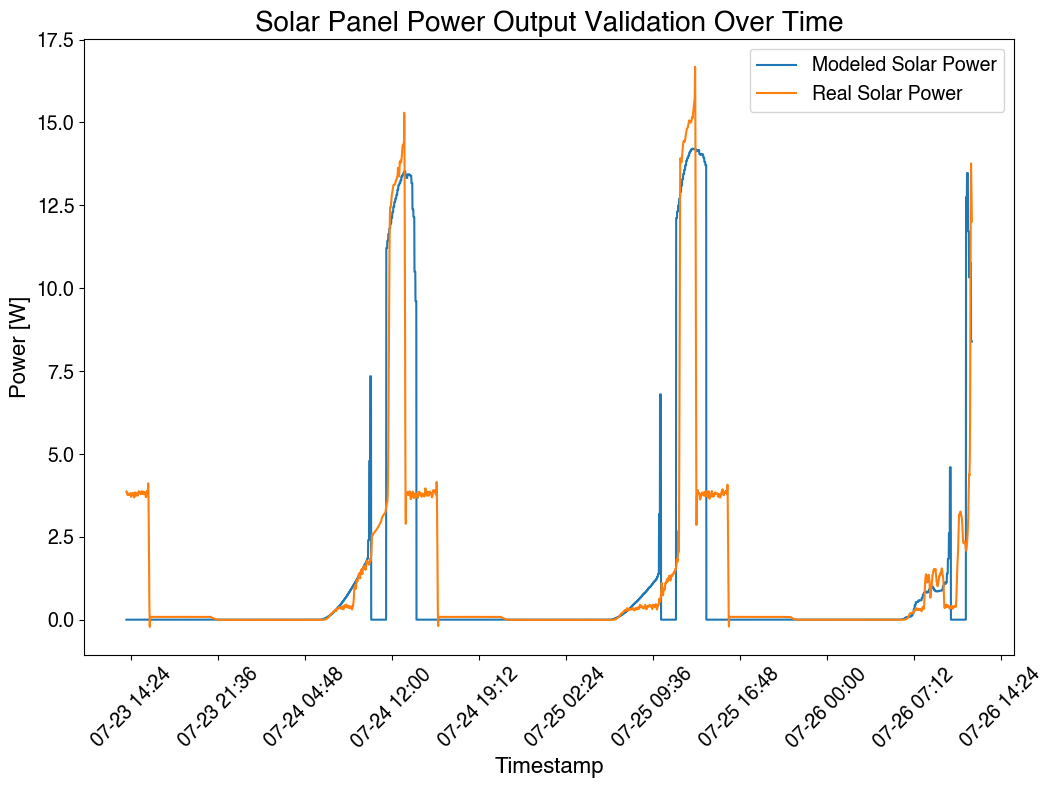

In [62]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,8))
plt.plot(model_df['power_in'], label = "Modeled Solar Power")
plt.plot(solar_df['smoothed_solar'] , label = "Real Solar Power")

ax.xaxis.set_major_locator(plt.MaxNLocator(12))  # Limit to 12 date labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

plt.xticks(rotation=45, fontsize=14)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)
plt.xlabel('Timestamp', fontsize=16)
plt.ylabel('Power [W]', fontsize=16)
plt.title("Solar Panel Power Output Validation Over Time", fontsize = 20)
plt.legend(fontsize=14)
plt.show()


/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83354/2164812357.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.8572507836174363' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  solar_df.loc[index, 'net_power'] = row['net_power']


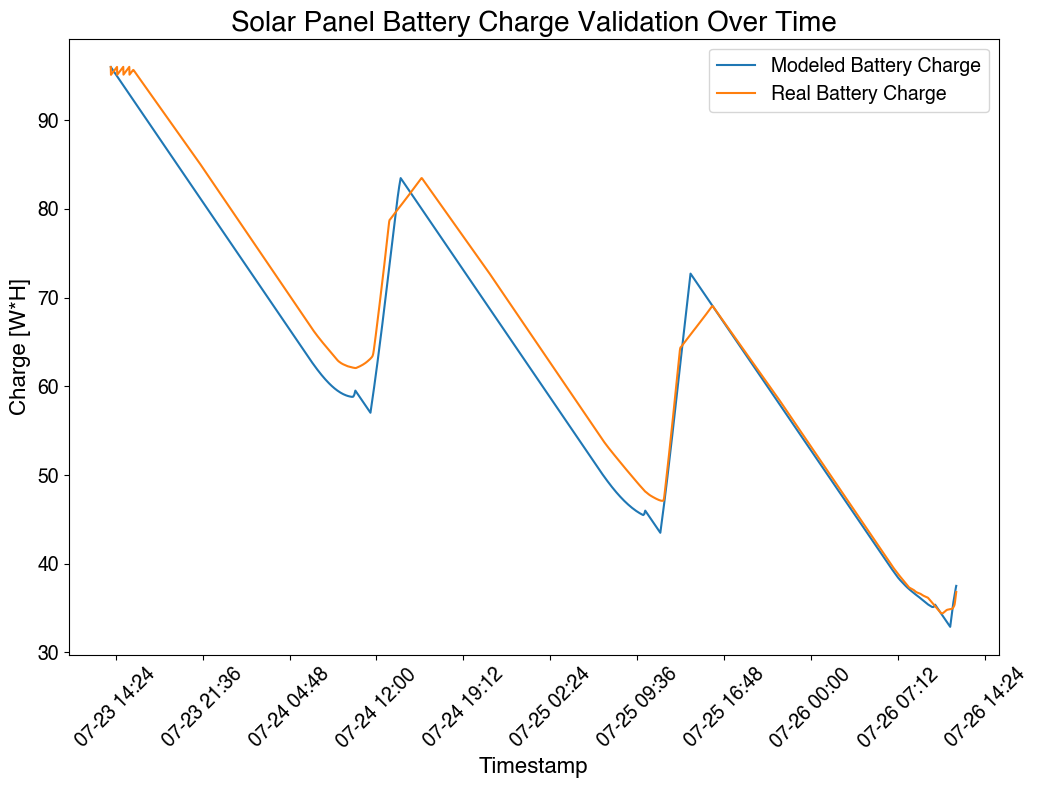

In [63]:
font = {
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

solar_df['net_power'] = 0
solar_df['charge'] = 120 * 60 * 0.8

for index, row in solar_df.iloc[1:].iterrows():
	# if charge is greater than or equal to capacity, no further charging
	if solar_df.loc[index - timedelta(minutes = 1), 'charge'] >= 120 * 60 * 0.8:
		row['net_power'] = row['smoothed_solar'] - 2
		if row['net_power'] > 0: 
			row['net_power'] = -53
	# if previous charge is greater than zero, power is consumed
	elif solar_df.loc[index - timedelta(minutes = 1), 'charge'] >= 0:
		row['net_power'] = row['smoothed_solar'] - 2
	else:
		row['net_power'] = row['smoothed_solar'] 

	solar_df.loc[index, 'net_power'] = row['net_power']
	
	solar_df.loc[index, 'charge'] = solar_df.loc[index - timedelta(minutes = 1), 'charge'] + row['net_power']


import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,8))
plt.plot(model_df['charge']/3600, label = "Modeled Battery Charge")
plt.plot(solar_df['charge']/60 , label = "Real Battery Charge")

ax.xaxis.set_major_locator(plt.MaxNLocator(12))  # Limit to 12 date labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

plt.xticks(rotation=45, fontsize=14)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)
plt.xlabel('Timestamp', fontsize=16)
plt.ylabel('Charge [W*H]', fontsize=16)
plt.title("Solar Panel Battery Charge Validation Over Time", fontsize = 20)
plt.legend(fontsize=14)
plt.show()

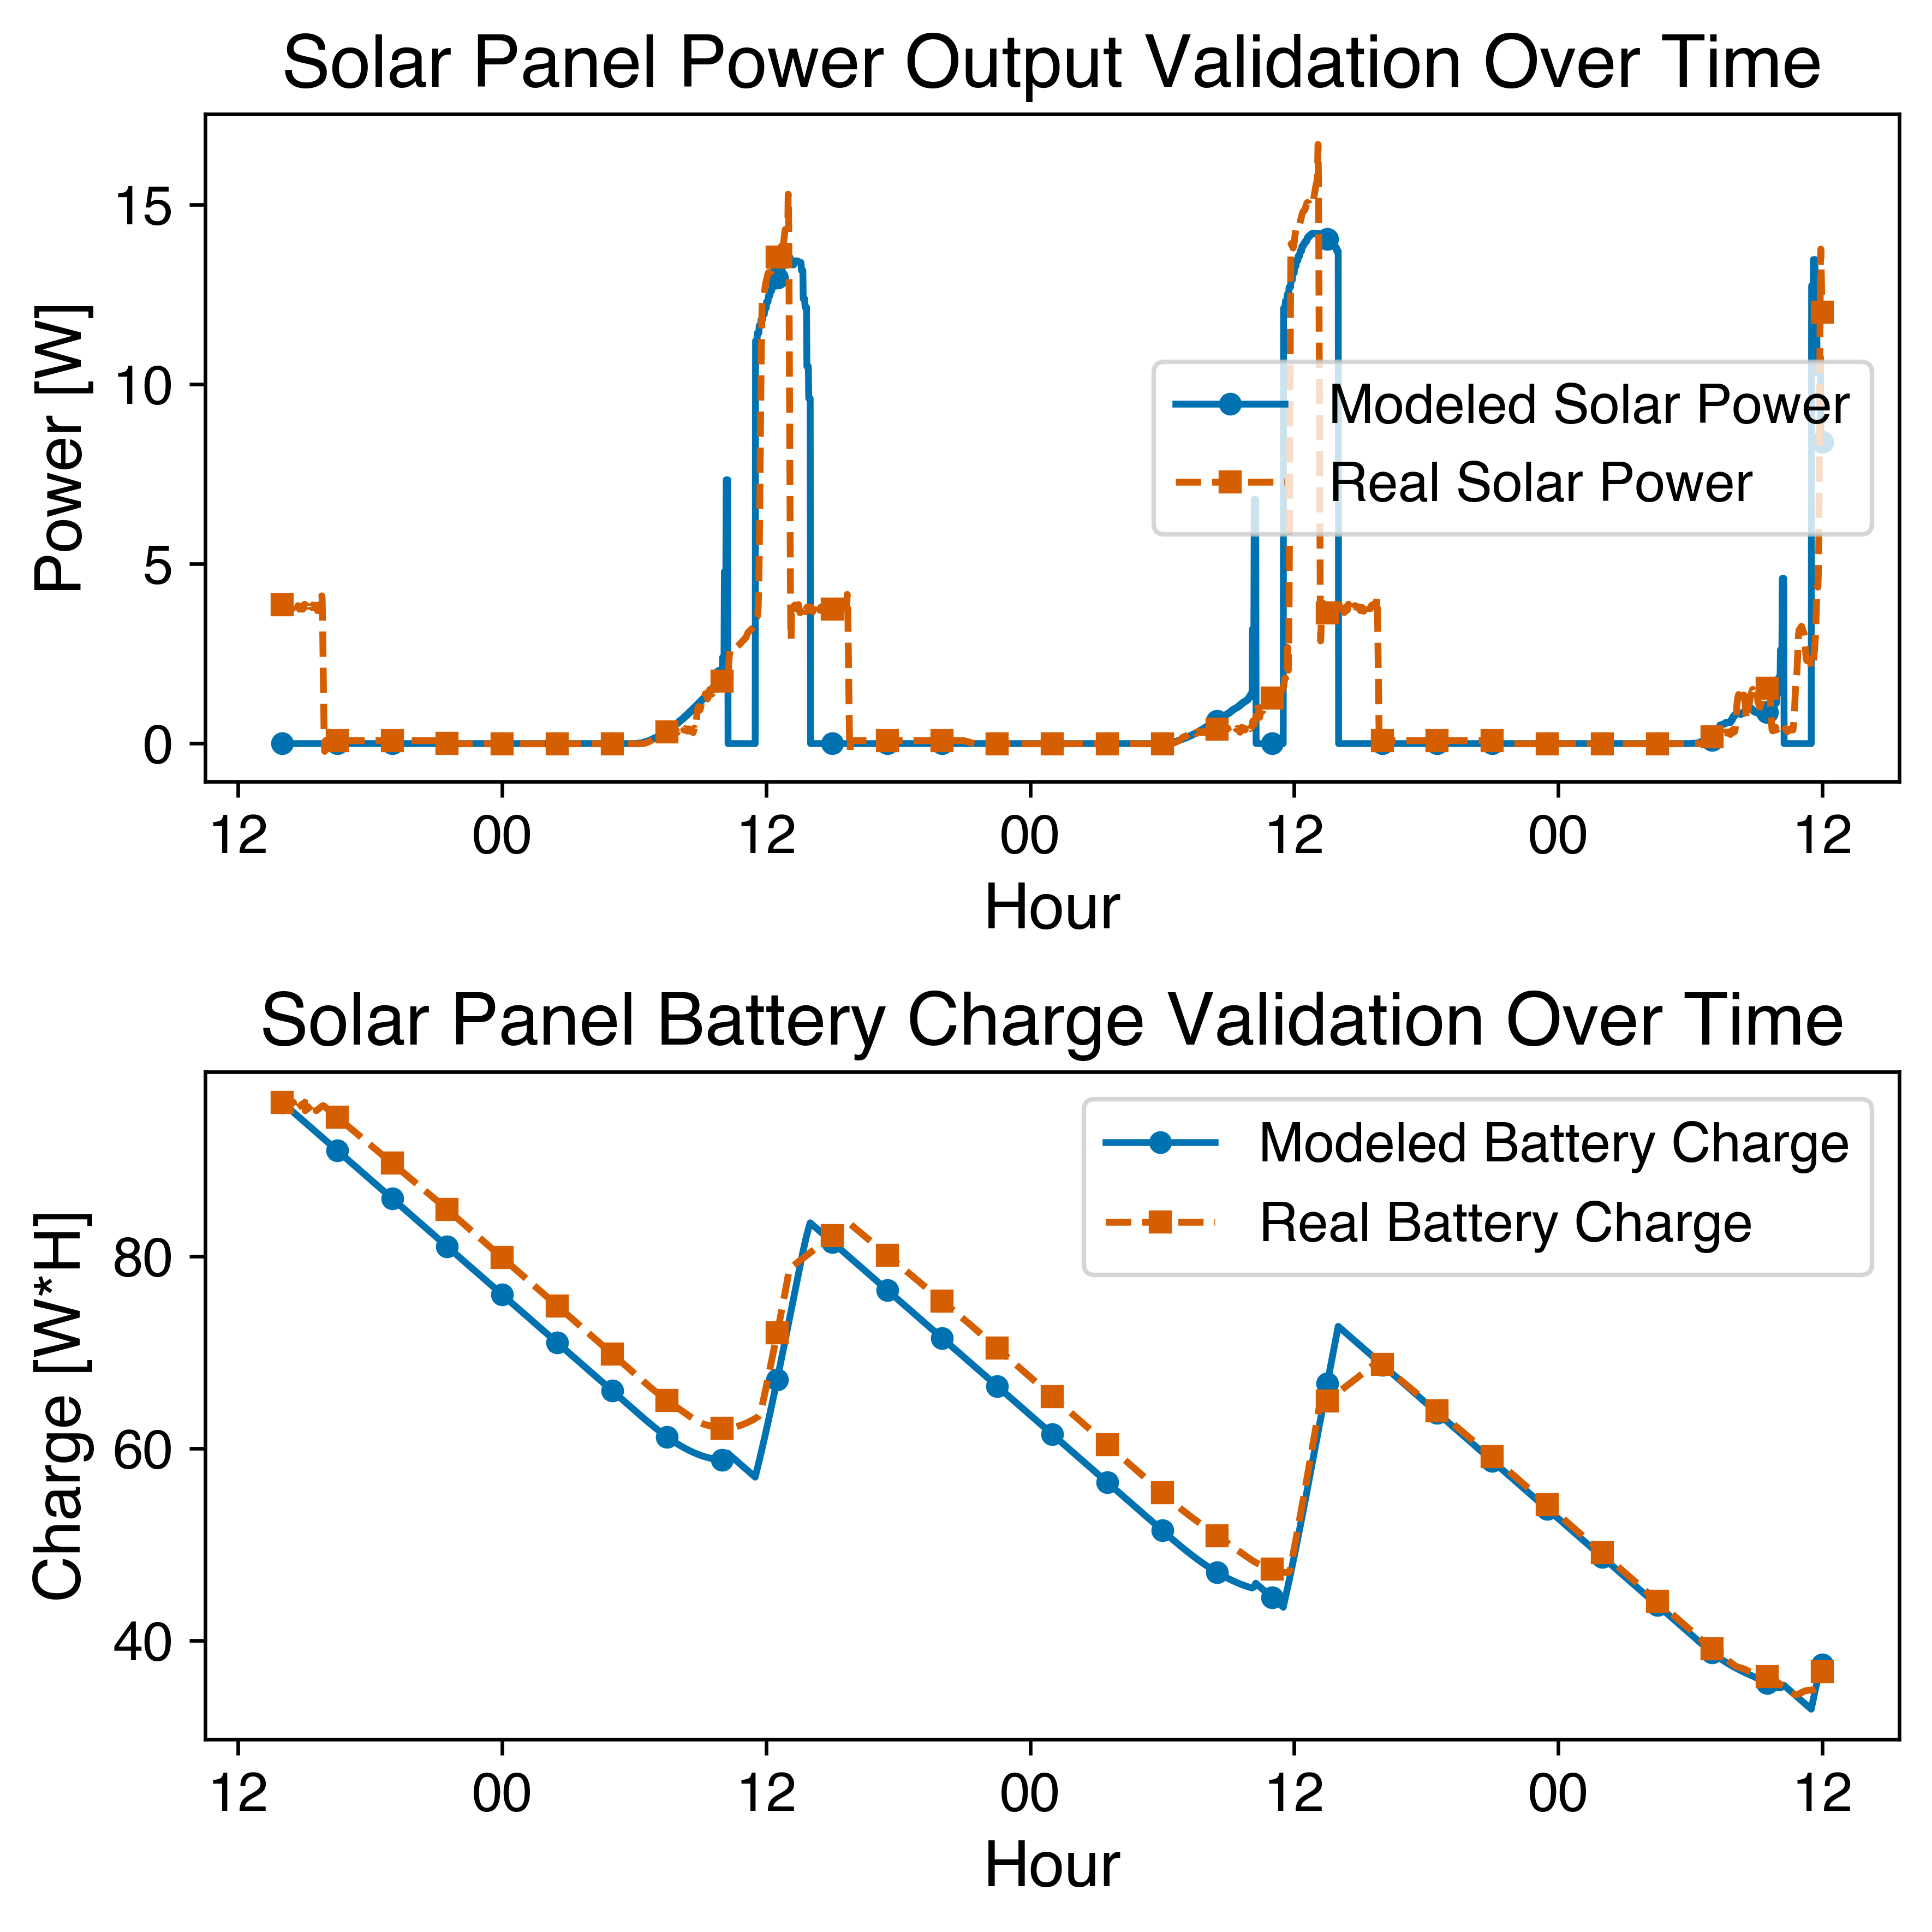

In [70]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Define a simple color palette (consistent for modeled vs real)
modeled_color = "#0072B2"  # Blue
real_color = "#D55E00"  # Orange

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), dpi=600)

# First subplot - Solar Power Output
ax1.plot(model_df['power_in'], label="Modeled Solar Power", linestyle='-', linewidth=1.5, marker='o', markersize=4, markevery = 150, color=modeled_color)
ax1.plot(solar_df['smoothed_solar'], label="Real Solar Power", linestyle='--', linewidth=1.5, marker='s', markersize=4, markevery = 150, color=real_color)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_xlabel('Hour', fontsize=14)
ax1.set_ylabel('Power [W]', fontsize=14)
ax1.set_title("Solar Panel Power Output Validation Over Time", fontsize=16)
ax1.legend(fontsize=12)

# Second subplot - Battery Charge
ax2.plot(model_df['charge']/3600, label="Modeled Battery Charge", linestyle='-', linewidth=1.5, marker='o', markersize=4,markevery = 150,  color=modeled_color)
ax2.plot(solar_df['charge']/60, label="Real Battery Charge", linestyle='--', linewidth=1.5, marker='s', markersize=4, markevery = 150, color=real_color)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_xlabel('Hour', fontsize=14)
ax2.set_ylabel('Charge [W*H]', fontsize=14)
ax2.set_title("Solar Panel Battery Charge Validation Over Time", fontsize=16)
ax2.legend(fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [198]:
from run_anywhere import run_combined_anywhere
_, solar_data = run_combined_anywhere(latitude=40.5853, longitude=-105.0844, logging = logging,
                             T_max=45 + 273.15, T_initial=20 + 273.15, 
                             k=0.04, rho=1070, Cp=2000, emissivity=0.66, absorptivity=0.66, 
                             battery_mass=1.25, battery_Cp=1000, battery_emissivity=0.62, 
                             battery_lengths=[0.151, 0.065, 0.096], 
                             B_air=0.00367, v_air=15.89e-6, k_air=0.024, alpha_air=22.5e-6, 
                             h_max=200, L=0.2032, W=0.152, H=0.10922, N=4, 
                             thicknesses=[0.004, 0.004, 0.004, 0.004, 0.004, 0.004], 
                             fan_flow=0, heat_generation=0, fan_heat_generation = 0, fan_threshold = 40, 
                             start_date_time='2023-01-01 00:00:00', 
                             end_date_time='2023-01-01 23:00:00',
                             solar_panel_area = 0.2, 
                            solar_panel_tilt = 0,
                            solar_panel_azimuth = 0,
                            solar_panel_efficiency = 0.18,
                            battery_rated_capacity = 120,
                            battery_efficiency = 0.8,
                            dt_solar = 600,
                            power_consumption = 4.5,
                             bounded = False,
                             quantiles =[0.1, 0.9],
                             stop_event = None,
                             box_shading = False,
                             shading_ranges = [])

*** Modelling Solar (40.5853, -105.0844) ***


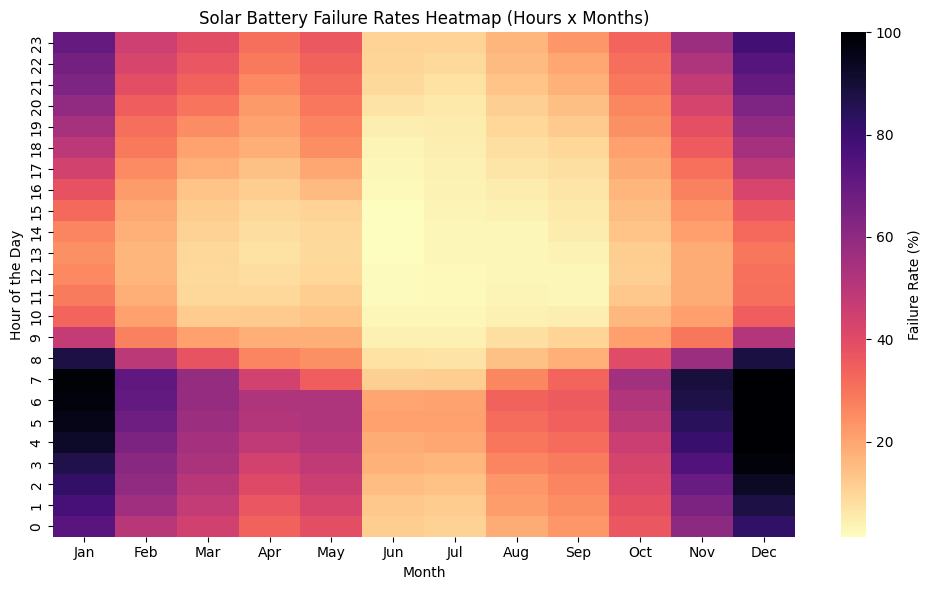

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def chart_solar_failure_matplotlib(solar_data):
    """
    Create a heatmap of solar battery failure for each hour of each month of the year (10 years of historical data 2014-2023 used)

    Parameters:
    solar_data - the solar model predictions of battery power and charge over time for 10 years

    Returns:
    fig - Matplotlib figure of monthly hourly solar energy failure
    """

    # Prepare data
    solar_data['month'] = solar_data.index.month
    solar_data['hour'] = solar_data.index.hour
    solar_data['failure'] = (solar_data['charges'] / 3600 <= 0.001) * 100

    # Aggregate the data
    agg_df = solar_data.groupby(['month', 'hour']).agg({'failure': 'mean'}).reset_index()

    # Pivot the data to create a matrix for the heatmap
    heatmap_data = agg_df.pivot(index='hour', columns='month', values='failure').sort_index(ascending=False)

    # Define month abbreviations
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap='magma_r', ax=ax, cbar_kws={'label': 'Failure Rate (%)'})

    # Customize the plot
    ax.set_title('Solar Battery Failure Rates Heatmap (Hours x Months)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Hour of the Day')

    # Set the x-axis to show month abbreviations
    ax.set_xticks(np.arange(0.5, len(month_abbr) + 0.5))
    ax.set_xticklabels(month_abbr)

    plt.tight_layout()

    return fig

fig = chart_solar_failure_matplotlib(solar_data)

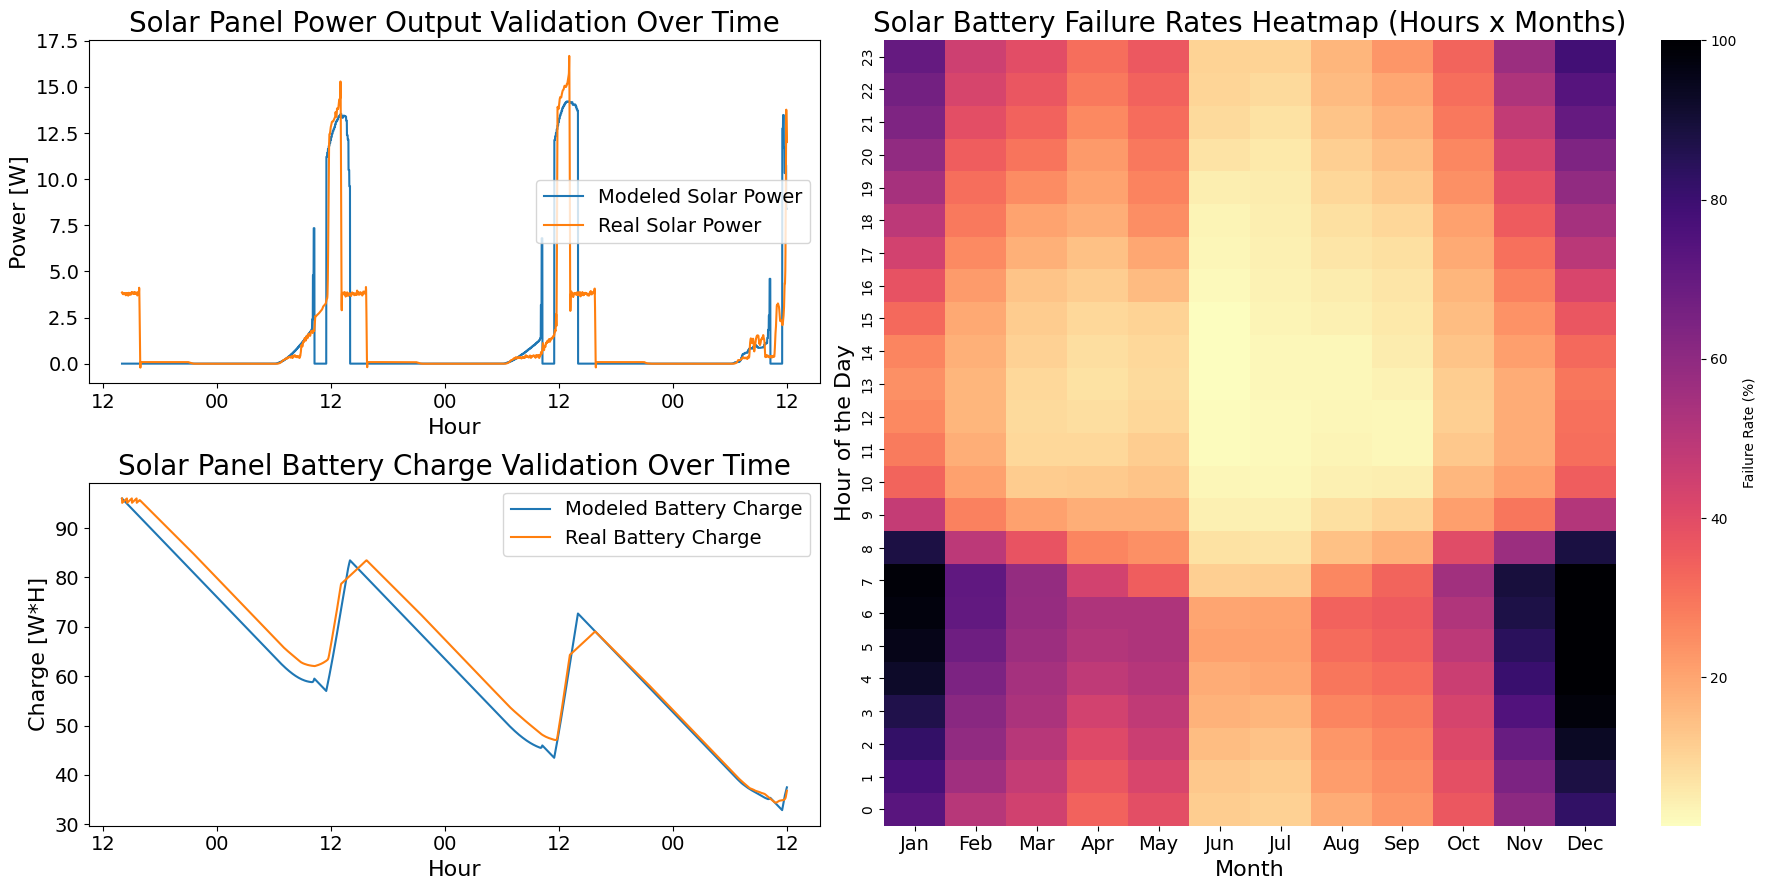

In [226]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace with your actual data)
# model_df = pd.DataFrame(...)
# solar_df = pd.DataFrame(...)
# solar_data = pd.DataFrame(...)

# Function for the heatmap
def chart_solar_failure_matplotlib(solar_data):
    # Prepare data
    solar_data['month'] = solar_data.index.month
    solar_data['hour'] = solar_data.index.hour
    solar_data['failure'] = (solar_data['charges'] / 3600 <= 0.001) * 100

    # Aggregate the data
    agg_df = solar_data.groupby(['month', 'hour']).agg({'failure': 'mean'}).reset_index()

    # Pivot the data to create a matrix for the heatmap
    heatmap_data = agg_df.pivot(index='hour', columns='month', values='failure').sort_index(ascending=False)

    # Define month abbreviations
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    return heatmap_data, month_abbr

heatmap_data, month_abbr = chart_solar_failure_matplotlib(solar_data)

# Set up the figure with GridSpec for 2 rows and 2 columns
fig = plt.figure(figsize=(18, 9))
gs = fig.add_gridspec(2, 2, width_ratios=[0.8, 1], height_ratios=[1, 1])
plt.subplots_adjust(hspace=0.35, wspace=0.2)  # Adjust hspace and wspace as needed

# First subplot (top left) - Solar Power
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(model_df['power_in'], label="Modeled Solar Power")
ax1.plot(solar_df['smoothed_solar'], label="Real Solar Power")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel('Hour', fontsize=16)
ax1.set_ylabel('Power [W]', fontsize=16)
ax1.set_title("Solar Panel Power Output Validation Over Time", fontsize=20)
ax1.legend(fontsize=14)

# Second subplot (bottom left) - Solar Charge
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(model_df['charge'] / 3600, label="Modeled Battery Charge")
ax2.plot(solar_df['charge'] / 60, label="Real Battery Charge")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel('Hour', fontsize=16)
ax2.set_ylabel('Charge [W*H]', fontsize=16)
ax2.set_title("Solar Panel Battery Charge Validation Over Time", fontsize=20)
ax2.legend(fontsize=14)

# Third subplot (right side) - Heatmap
ax3 = fig.add_subplot(gs[:, 1])  # Use both rows for the heatmap
sns.heatmap(heatmap_data, cmap='magma_r', ax=ax3, cbar_kws={'label': 'Failure Rate (%)'})

# Customize the heatmap
ax3.set_title('Solar Battery Failure Rates Heatmap (Hours x Months)', fontsize=20)
ax3.set_xlabel('Month', fontsize=16)
ax3.set_ylabel('Hour of the Day', fontsize=16)
ax3.set_xticks(np.arange(0.5, len(month_abbr) + 0.5))
ax3.set_xticklabels(month_abbr, fontsize=14)
#ax3.set_uticklabels(month_abbr, fontsize=14)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


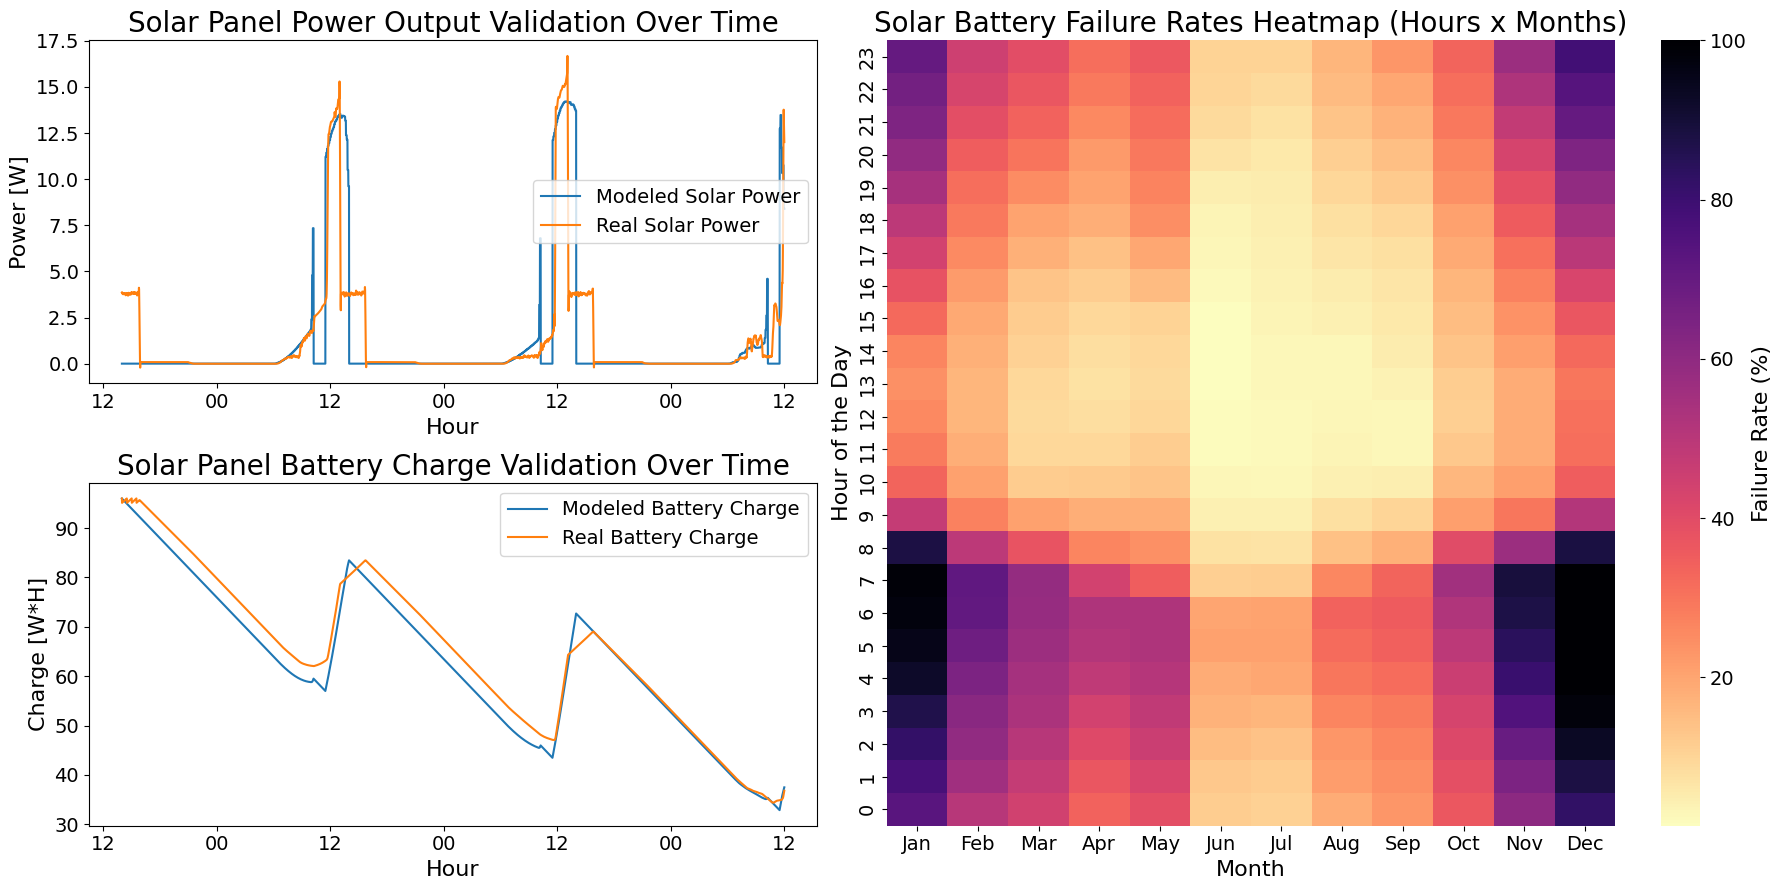

In [231]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace with your actual data)
# model_df = pd.DataFrame(...)
# solar_df = pd.DataFrame(...)
# solar_data = pd.DataFrame(...)

# Function for the heatmap
def chart_solar_failure_matplotlib(solar_data):
    # Prepare data
    solar_data['month'] = solar_data.index.month
    solar_data['hour'] = solar_data.index.hour
    solar_data['failure'] = (solar_data['charges'] / 3600 <= 0.001) * 100

    # Aggregate the data
    agg_df = solar_data.groupby(['month', 'hour']).agg({'failure': 'mean'}).reset_index()

    # Pivot the data to create a matrix for the heatmap
    heatmap_data = agg_df.pivot(index='hour', columns='month', values='failure').sort_index(ascending=False)

    # Define month abbreviations
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    return heatmap_data, month_abbr

heatmap_data, month_abbr = chart_solar_failure_matplotlib(solar_data)

# Set up the figure with GridSpec for 2 rows and 2 columns
fig = plt.figure(figsize=(18, 9))
gs = fig.add_gridspec(2, 2, width_ratios=[0.8, 1], height_ratios=[1, 1])
plt.subplots_adjust(hspace=0.35, wspace=0.2)  # Adjust hspace and wspace as needed

# First subplot (top left) - Solar Power
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(model_df['power_in'], label="Modeled Solar Power")
ax1.plot(solar_df['smoothed_solar'], label="Real Solar Power")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax1.tick_params(axis='x', labelsize=14)  # Set x-tick font size
ax1.tick_params(axis='y', labelsize=14)  # Set y-tick font size
ax1.set_xlabel('Hour', fontsize=16)
ax1.set_ylabel('Power [W]', fontsize=16)
ax1.set_title("Solar Panel Power Output Validation Over Time", fontsize=20)
ax1.legend(fontsize=14)

# Second subplot (bottom left) - Solar Charge
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(model_df['charge'] / 3600, label="Modeled Battery Charge")
ax2.plot(solar_df['charge'] / 60, label="Real Battery Charge")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax2.tick_params(axis='x', labelsize=14)  # Set x-tick font size
ax2.tick_params(axis='y', labelsize=14)  # Set y-tick font size
ax2.set_xlabel('Hour', fontsize=16)
ax2.set_ylabel('Charge [W*H]', fontsize=16)
ax2.set_title("Solar Panel Battery Charge Validation Over Time", fontsize=20)
ax2.legend(fontsize=14)

# Third subplot (right side) - Heatmap
ax3 = fig.add_subplot(gs[:, 1])  # Use both rows for the heatmap
heatmap = sns.heatmap(
    heatmap_data, 
    cmap='magma_r', 
    ax=ax3, 
    cbar=True, 
    cbar_kws={'label': 'Failure Rate (%)'}  # Color bar label
)

# Customize the color bar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Set font size for color bar ticks
cbar.ax.set_ylabel('Failure Rate (%)', fontsize=16)  # Set font size for color bar label

# Customize the heatmap
ax3.set_title('Solar Battery Failure Rates Heatmap (Hours x Months)', fontsize=20)
ax3.set_xlabel('Month', fontsize=16)
ax3.set_ylabel('Hour of the Day', fontsize=16)
ax3.set_xticks(np.arange(0.5, len(month_abbr) + 0.5))
ax3.set_xticklabels(month_abbr, fontsize=14)  # Set x-tick font size for month labels
ax3.tick_params(axis='y', labelsize=14)  # Set y-tick font size

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## supplemental

#### Solar Shading Validation 7/15

Fan speed: 0.0
start date 2024-07-15
end date 2024-07-16
wind_speed_factor 1
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


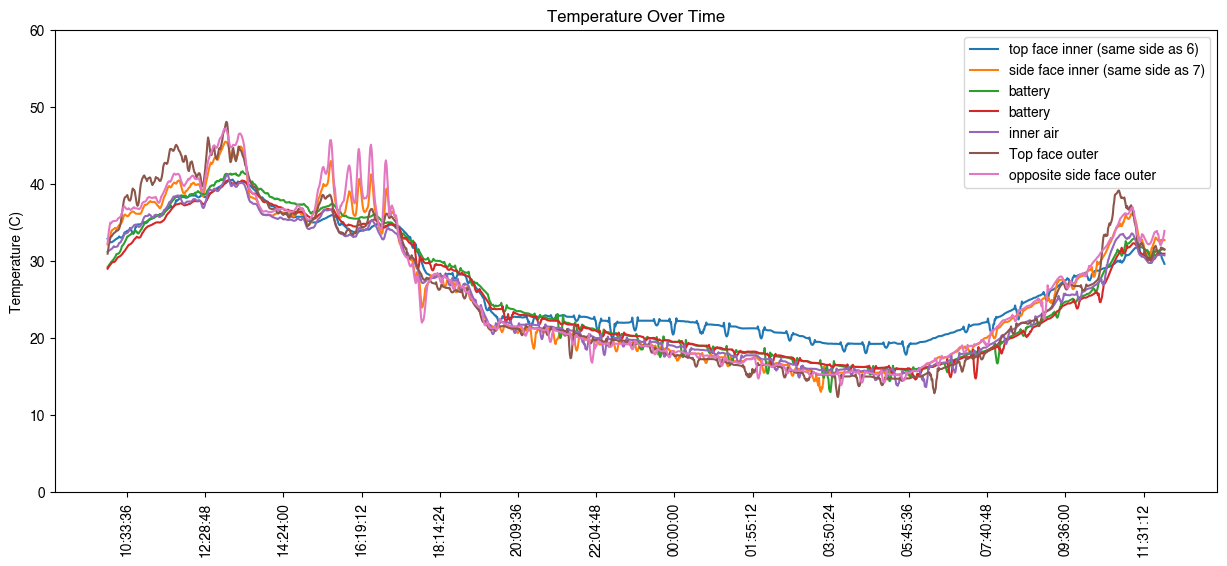

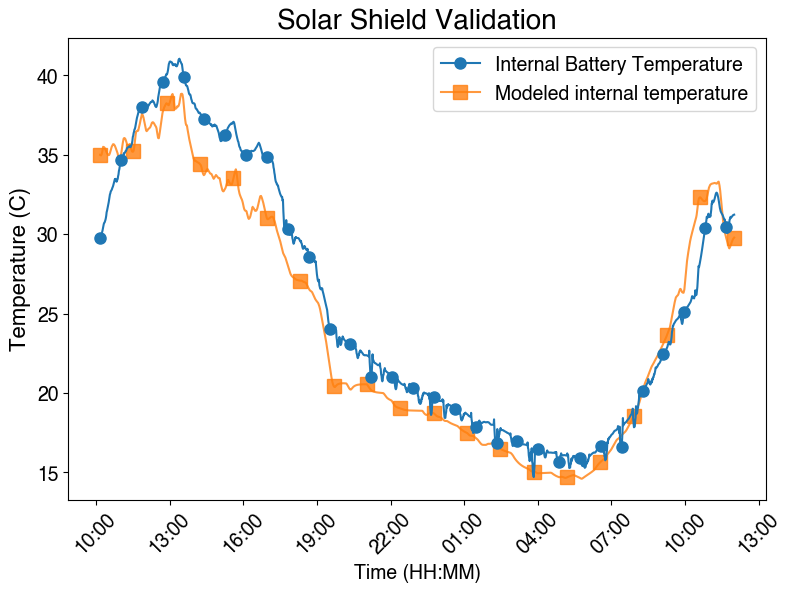

In [274]:
import pandas as pd
import numpy as np
from datetime import * 
import matplotlib.pyplot as plt
from run_foco import run_foco
from validation import * 

start_date_time = '2024-07-15 10:10:00'
end_date_time = '2024-07-16 12:00:00'

# set up logging
import logging
filename = 'validation.log'
logging.basicConfig(filename=filename, level=logging.INFO, format='%(asctime)s - %(message)s')
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)
# Clear the log file
with open(filename, 'w'):
    pass  # This opens and immediately closes the file, truncating it

sensor_df, smoothed_df = import_and_plot("../real_data/sensor_readings_2024_07_15_10_05.csv",  start_date_time, end_date_time, logging, 9, 2, columns_to_drop = [
       'sensor_5', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15'])
logging.info("*** Retrieved Raspi Data ***")

results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 4, internal_rad =  True, h_max = 100, 
						heat_generation = 0, fan_flow = 0, T_initial=35 + 273.15,fan_threshold = 50, shading = True)

logging.info("Directories: " + results_dir)
model_df = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))

plot_comparison(smoothed_df, [{'data':model_df, 'label': "Modeled internal temperature"}, 
							  ],
				start_date_time, end_date_time, title = "Solar Shield Validation")

#### Bounding Variation

In [106]:
df_2023 = load_data("../../model_results_numpy/1_year/", base_time  = datetime(2023, 1, 1, 0, 0, 0))


In [108]:
df_0_9 = load_data("../../model_results_numpy/variation_0.9/", base_time  = datetime(2023, 1, 1, 0, 0, 0))
df_0_9_daily_max = df_0_9.resample('D').max()

df_0_1 = load_data("../../model_results_numpy/variation_0.25/", base_time  = datetime(2023, 1, 1, 0, 0, 0))
df_0_1_daily_min = df_0_1.resample('D').min()

In [112]:
df_0_9_daily_max['internal'].max

seconds_past    internal  battery_temp  outside_temp
datetime                                                        
2023-01-01  8.639900e+04  293.758453    293.149994    280.610962
2023-01-02  1.727997e+05  271.580170    272.538361    271.588165
2023-01-03  2.591987e+05  271.676544    271.668701    271.684265
2023-01-04  3.455993e+05  271.772797    271.764923    271.780396
2023-01-05  4.319983e+05  271.868713    271.861145    271.876526
...                  ...         ...           ...           ...
2023-12-27  3.119040e+07  272.834839    272.840546    272.828552
2023-12-28  3.127680e+07  272.799896    272.805542    272.793579
2023-12-29  3.136320e+07  272.764832    272.770508    272.758545
2023-12-30  3.144960e+07  274.197266    273.034698    274.536377
2023-12-31  3.153240e+07  274.410095    274.370636    274.425018

[365 rows x 4 columns]

NameError: name 'df_2003_re' is not defined

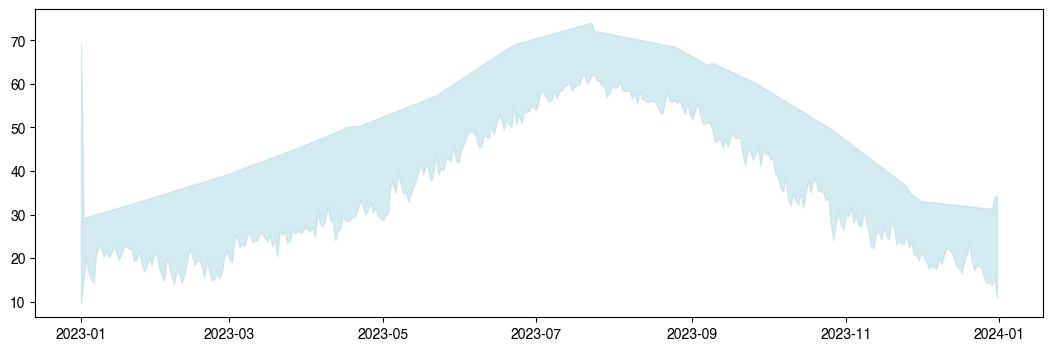

In [109]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

df_2023_re = df_2023.resample('1h').mean()



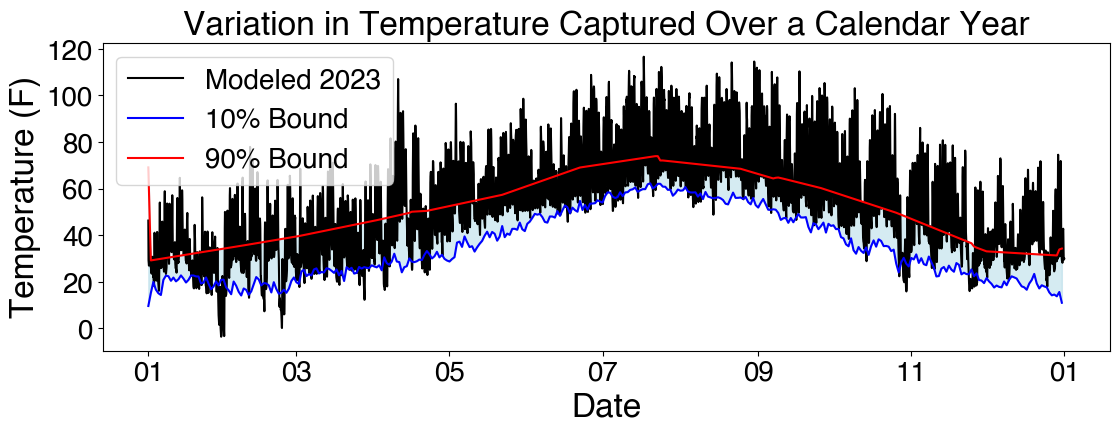

In [110]:
fig, ax = plt.subplots(figsize = (13,4))
plt.fill_between(df_0_1_daily_min['internal'].index, ((df_0_1_daily_min['internal'])-273.15) * 9/5 + 32, (df_0_9_daily_max['internal']-273.15) * 9/5 + 32, color='lightblue', alpha=0.5)

plt.plot(((df_2023_re['internal'])-273.15) * 9/5 + 32, label = "Modeled 2023", color = "black")
plt.plot(((df_0_1_daily_min['internal'])-273.15) * 9/5 + 32, label = "10% Bound", color = "blue")
plt.plot(((df_0_9_daily_max['internal'])-273.15) * 9/5 + 32, label = "90% Bound", color = "red")

#ax.xaxis.set_major_locator(plt.MaxNLocator(12))  # Limit to 12 date labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

plt.xticks(fontsize = 20)  # Rotate x-axis labels for better readability
plt.yticks(fontsize = 20)
plt.ylabel('Temperature (F)', fontsize = 24)
plt.xlabel('Date', fontsize = 24)
plt.title("Variation in Temperature Captured Over a Calendar Year", fontsize = 24)
plt.legend(fontsize = 20)
plt.show()

#### Shading type

In [265]:
start_date_time = '2024-07-31 12:10:00'
end_date_time = '2024-08-02 13:30:00'


dfs = []
for shading_type in ['No Shading', 'Solar Shield', 'Full Shade']:

	if shading_type == 'No Shading':
		results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad = True, h_max = 100, 
								heat_generation = 2, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
								k=0.216,
								rho=1370,
								Cp=1300,
								emissivity=0.92,
								L = 0.4,
								H = 0.2,
								W = 0.4,
								thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
								shading_ranges = [('10:00:00', '11:30:00')],
								interval = 120,
								run_interval = 30,
								wind_speed_factor = 1,
								shading=False,
								#shading_ranges = []
								)
		
	elif shading_type == "Solar Shield":
		results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad = True, h_max = 100, 
								heat_generation = 2, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
								k=0.216,
								rho=1370,
								Cp=1300,
								emissivity=0.92,
								L = 0.4,
								H = 0.2,
								W = 0.4,
								thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
								shading_ranges =  [('10:00:00', '11:30:00')],
								interval = 120,
								run_interval = 30,
								wind_speed_factor = 1,
								shading=True,
								#shading_ranges = []
								)
	else:
		results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad = True, h_max = 100, 
								heat_generation = 2, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
								k=0.216,
								rho=1370,
								Cp=1300,
								emissivity=0.92,
								L = 0.4,
								H = 0.2,
								W = 0.4,
								thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
								shading_ranges = [('00:00:00', '23:50:00')], #= [('10:00:00', '11:30:00')],
								interval = 120,
								run_interval = 30,
								wind_speed_factor = 1,
								shading=True,
								#shading_ranges = []
								)

	logging.info("Directories: " + results_dir)
	model_df_fiberglass_heat_gen = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))
	dfs.append({'wind_speed_factor': shading_type,
			 'df':model_df_fiberglass_heat_gen})



Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


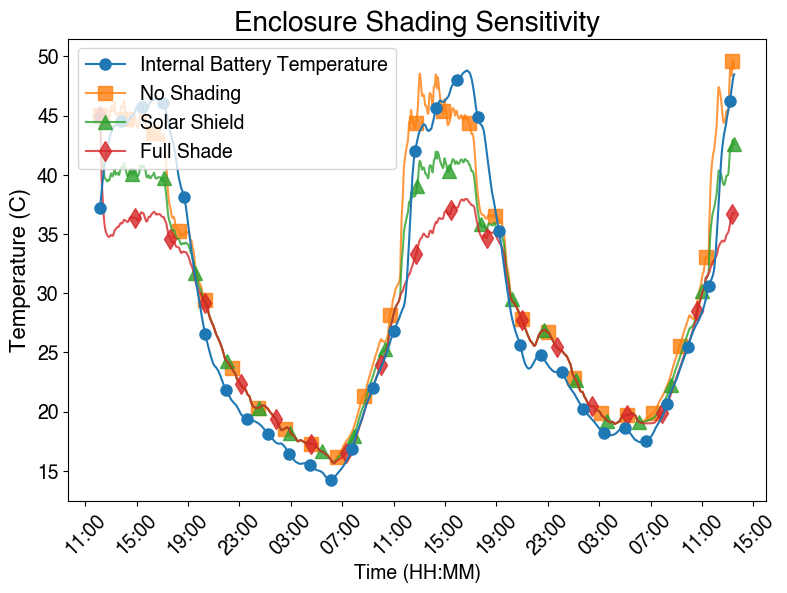

In [267]:
import validation
# Prepare a list of dictionaries for each dataframe with appropriate labels
comparison_data = []

for data_entry in dfs:
    shading_type = data_entry['wind_speed_factor']
    df = data_entry['df']
    df = df.resample('min').mean()
    
    # Create a label based on interval and run_interval
    label = f"{shading_type}"
    
    # Add this dataframe and label to the comparison data list
    comparison_data.append({'data': df, 'label': label})

# Call the plot function with all the dataframes at once
validation.plot_comparison(
    smoothed_others_df, 
    comparison_data,  # Pass the list of dicts with data and labels
    start_date_time, 
    end_date_time, 
    col1='4_smooth', 
    col2='4_smooth',
    title="Enclosure Shading Sensitivity",
    hour_interval=4
)


#### Emissivity Sensitivity

In [259]:
start_date_time = '2024-07-31 12:10:00'
end_date_time = '2024-08-02 13:30:00'


dfs = []
for emissivity in [0, 0.25, 0.5, 0.75, 1]:

	
	results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad = True, h_max = 100, 
							heat_generation = 2, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
							k=0.216,
							rho=1370,
							Cp=1300,
							emissivity=emissivity,
							L = 0.4,
							H = 0.2,
							W = 0.4,
							thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
							shading_ranges = [('10:00:00', '11:30:00')],
							interval = 120,
							run_interval = 30,
							wind_speed_factor = 1,
							#shading=False,
							#shading_ranges = []
							)

	logging.info("Directories: " + results_dir)
	model_df_fiberglass_heat_gen = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))
	dfs.append({'wind_speed_factor': emissivity,
			 'df':model_df_fiberglass_heat_gen})



Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


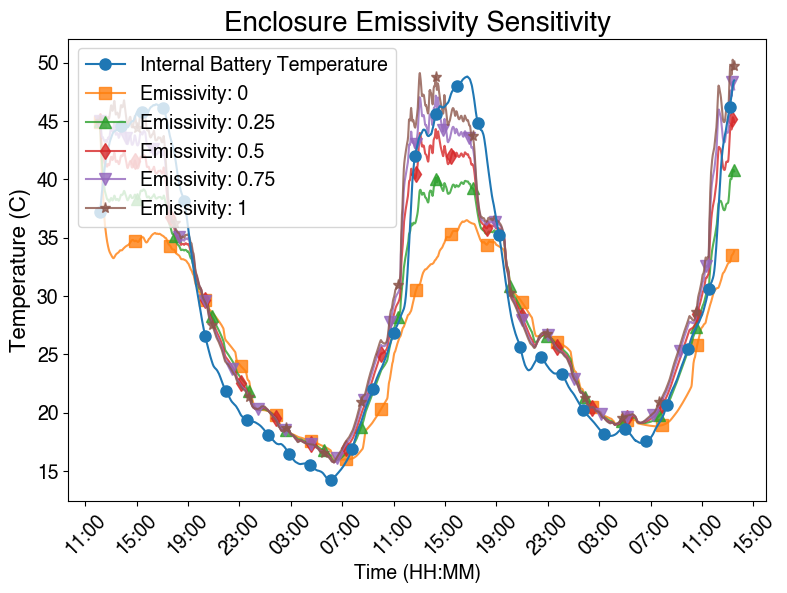

In [261]:
import validation
# Prepare a list of dictionaries for each dataframe with appropriate labels
comparison_data = []

for data_entry in dfs:
    emissivity = data_entry['wind_speed_factor']
    df = data_entry['df']
    df = df.resample('min').mean()
    
    # Create a label based on interval and run_interval
    label = f"Emissivity: {emissivity}"
    
    # Add this dataframe and label to the comparison data list
    comparison_data.append({'data': df, 'label': label})

# Call the plot function with all the dataframes at once
validation.plot_comparison(
    smoothed_others_df, 
    comparison_data,  # Pass the list of dicts with data and labels
    start_date_time, 
    end_date_time, 
    col1='4_smooth', 
    col2='4_smooth',
    title="Enclosure Emissivity Sensitivity",
    hour_interval=4
)


#### Node Count Sensitivity

In [226]:
start_date_time = '2024-07-31 12:10:00'
end_date_time = '2024-08-02 13:30:00'


dfs = []
for node_count in [2, 3, 4, 6, 10]:

	
	results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = node_count, internal_rad = True, h_max = 100, 
							heat_generation = 2, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
							k=0.216,
							rho=1370,
							Cp=1300,
							emissivity=0.92,
							L = 0.4,
							H = 0.2,
							W = 0.4,
							thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
							shading_ranges = [('10:00:00', '11:30:00')],
							interval = 120,
							run_interval = 30,
							wind_speed_factor = 1,
							#shading=False,
							#shading_ranges = []
							)

	logging.info("Directories: " + results_dir)
	model_df_fiberglass_heat_gen = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))
	dfs.append({'wind_speed_factor': node_count,
			 'df':model_df_fiberglass_heat_gen})



Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0


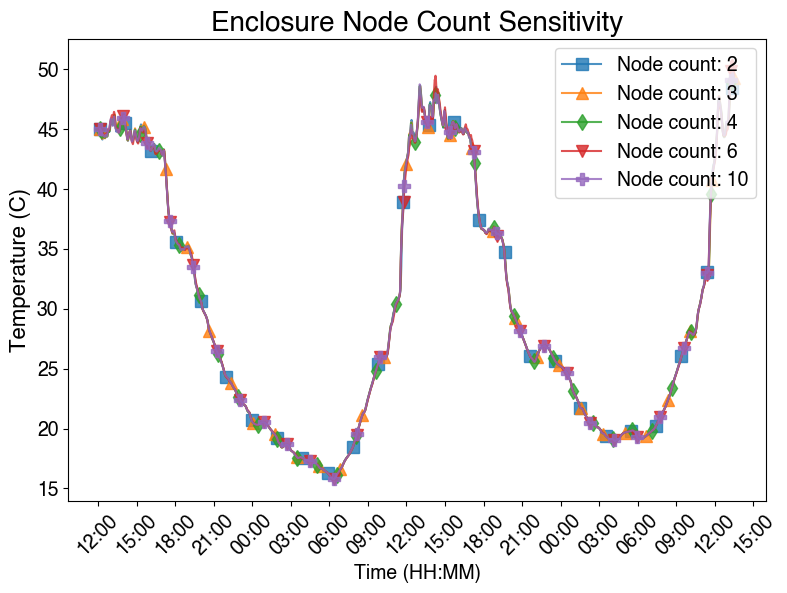

In [ ]:
import validation
# Prepare a list of dictionaries for each dataframe with appropriate labels
comparison_data = []

for data_entry in dfs:
    node = data_entry['wind_speed_factor']
    df = data_entry['df']
    df = df.resample('min').mean()
    
    # Create a label based on interval and run_interval
    label = f"Node count: {node}"
    
    # Add this dataframe and label to the comparison data list
    comparison_data.append({'data': df, 'label': label})

# Call the plot function with all the dataframes at once
validation.plot_comparison(
    smoothed_others_df, 
    comparison_data,  # Pass the list of dicts with data and labels
    start_date_time, 
    end_date_time, 
    col1='4_smooth', 
    col2='4_smooth',
    title="Enclosure Node Count Sensitivity",
	ignore_real = True
)


#### Initial Temperature Sensitiviity

In [230]:
start_date_time = '2024-07-31 12:00:00'
end_date_time = '2024-08-01 12:00:00'


dfs = []
for initial_temp in [0, 15, 30, 45, 60]:

	
	results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad = True, h_max = 100, 
							heat_generation = 2, fan_flow = 0, T_initial=initial_temp + 273.15,fan_threshold = 50,
							k=0.216,
							rho=1370,
							Cp=1300,
							emissivity=0.92,
							L = 0.4,
							H = 0.2,
							W = 0.4,
							thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
							shading_ranges = [('10:00:00', '11:30:00')],
							interval = 120,
							run_interval = 30,
							wind_speed_factor = 1,
							#shading=False,
							#shading_ranges = []
							)

	logging.info("Directories: " + results_dir)
	model_df_fiberglass_heat_gen = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))
	dfs.append({'wind_speed_factor': initial_temp,
			 'df':model_df_fiberglass_heat_gen})



Fan speed: 0.0
start date 2024-07-31
end date 2024-08-01
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-01
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-01
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-01
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-01
wind_speed_factor 1
mean temp not weighted
0.0


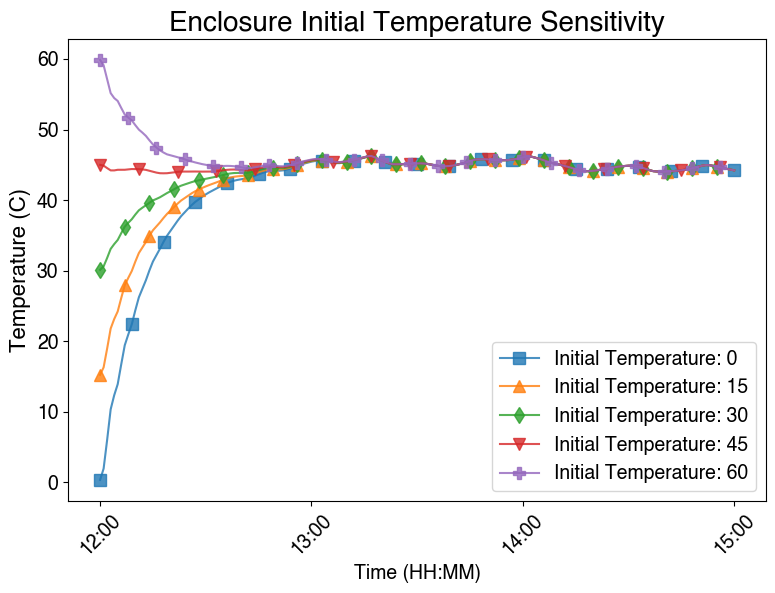

In [238]:
import validation
# Prepare a list of dictionaries for each dataframe with appropriate labels
comparison_data = []

for data_entry in dfs:
    initial_temp = data_entry['wind_speed_factor']
    df = data_entry['df']
    df = df.resample('min').mean()
    df = df.loc[df.index <= min(df.index) + timedelta(hours=3)]
    
    # Create a label based on interval and run_interval
    label = f"Initial Temperature: {initial_temp}"
    
    # Add this dataframe and label to the comparison data list
    comparison_data.append({'data': df, 'label': label})

# Call the plot function with all the dataframes at once
validation.plot_comparison(
    smoothed_others_df, 
    comparison_data,  # Pass the list of dicts with data and labels
    start_date_time, 
    end_date_time, 
    col1='4_smooth', 
    col2='4_smooth',
    title="Enclosure Initial Temperature Sensitivity",
    ignore_real = True,
    hour_interval = 1
)


#### Internal Heat Gen Sensitivity

In [253]:
start_date_time = '2024-07-31 12:10:00'
end_date_time = '2024-08-02 13:30:00'


dfs = []
for heat_generation in [0, 5, 10, 20, 50]:

	
	results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad = True, h_max = 100, 
							heat_generation = heat_generation, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
							k=0.216,
							rho=1370,
							Cp=1300,
							emissivity=0.92,
							L = 0.4,
							H = 0.2,
							W = 0.4,
							thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
							shading_ranges = [('10:00:00', '11:30:00')],
							interval = 120,
							run_interval = 30,
							wind_speed_factor = 1,
							#shading=False,
							#shading_ranges = []
							)

	logging.info("Directories: " + results_dir)
	model_df_fiberglass_heat_gen = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))
	dfs.append({'wind_speed_factor': heat_generation,
			 'df':model_df_fiberglass_heat_gen})



Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0


In [40]:
import importlib

# Assuming you have a module named 'your_module'
import validation

# Reload the module
importlib.reload(validation)


<module 'validation' from '/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py'>

/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


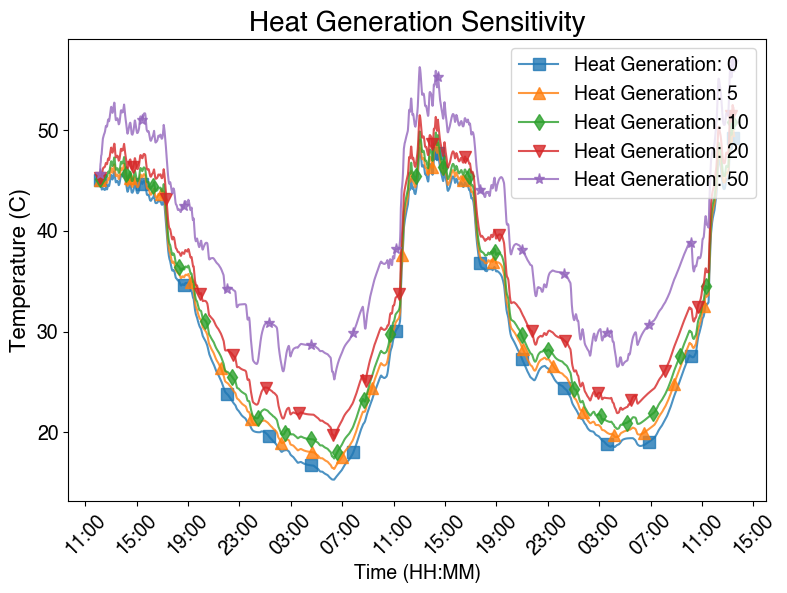

In [256]:
import validation
# Prepare a list of dictionaries for each dataframe with appropriate labels
comparison_data = []

for data_entry in dfs:
    heat_generation = data_entry['wind_speed_factor']
    df = data_entry['df']
    df = df.resample('min').mean()
    
    # Create a label based on interval and run_interval
    label = f"Heat Generation: {heat_generation}"
    
    # Add this dataframe and label to the comparison data list
    comparison_data.append({'data': df, 'label': label})

# Call the plot function with all the dataframes at once
validation.plot_comparison(
    smoothed_others_df, 
    comparison_data,  # Pass the list of dicts with data and labels
    start_date_time, 
    end_date_time, 
    col1='4_smooth', 
    col2='4_smooth',
    title="Heat Generation Sensitivity",
    ignore_real = True,
    hour_interval = 4
)


#### Battery Temp = Air Temp Validation

In [213]:
import pandas as pd
import numpy as np
from datetime import * 
import matplotlib.pyplot as plt
from run_foco import run_foco
from validation import * 

start_date_time = '2024-06-27 14:10:00'
end_date_time = '2024-06-28 12:00:00'

# set up logging
import logging
filename = 'validation.log'
logging.basicConfig(filename=filename, level=logging.INFO, format='%(asctime)s - %(message)s')
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)
# Clear the log file
with open(filename, 'w'):
    pass  # This opens and immediately closes the file, truncating it

sensor_df, smoothed_df = import_data("../real_data/sensor_readings_2024_07_01_15_12.csv", logging, 27, 2, columns_to_drop = ['sensor_5', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15'])


--- Logging error ---
Traceback (most recent call last):
  File "/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py", line 181, in import_data
    sensor_readings_df.drop(columns=[col], inplace=True)
  File "/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/.venv/lib/python3.9/site-packages/pandas/core/frame.py", line 5581, in drop
    return super().drop(
  File "/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/.venv/lib/python3.9/site-packages/pandas/core/generic.py", line 4788, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/.venv/lib/python3.9/site-packages/pandas/core/generic.py", line 4830, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
  File "/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/.venv/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 7070, in drop
    raise KeyError(f"{labels[mask].tolist()} not found in axis")
KeyError: "['sensor

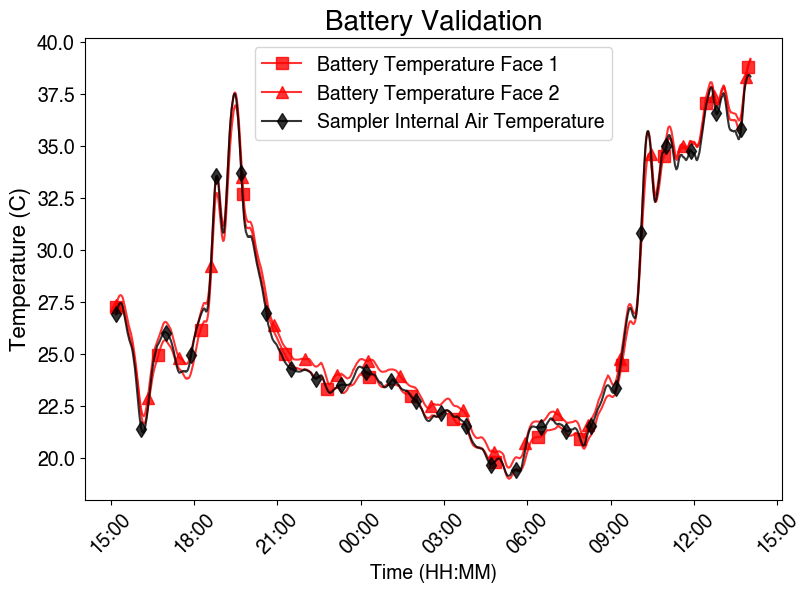

In [219]:

start_date_time = '2024-05-26 12:10:00'
end_date_time = '2024-08-28 18:00:00'

def to_F(num):
	return num  # Assuming Celsius is intended; update if Fahrenheit conversion is needed

# Filter the data based on the provided time range
smoothed_df = smoothed_df.loc[(smoothed_df.index >= start_date_time) & (smoothed_df.index <= end_date_time)]

fig, ax = plt.subplots(figsize=(9, 6))

# Determine marker spacing (~30 markers per line)
total_points = len(smoothed_df)
marker_spacing = max(1, total_points // 15)  # Ensure at least 1 to avoid div by zero


markers = ['s', '^', 'd', 'v', 'P', '*', 'X']

ax.plot(smoothed_df.index, smoothed_df['2_smooth'], label='Battery Temperature Face 1', marker='s', color = 'red', markevery=marker_spacing, markersize=8, alpha = 0.8)
marker_spacing = max(1, total_points // 20)  # Ensure at least 1 to avoid div by zero
ax.plot(smoothed_df.index, smoothed_df['3_smooth'], label='Battery Temperature Face 2', marker='^', color = 'red', markevery=marker_spacing, markersize=8, alpha = 0.8)
marker_spacing = max(1, total_points // 25)  # Ensure at least 1 to avoid div by zero
ax.plot(smoothed_df.index, smoothed_df['4_smooth'], label='Sampler Internal Air Temperature', marker='d', color = 'black', markevery=marker_spacing, markersize=8, alpha = 0.8)

# Format x-axis ticks to display only hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Set tick interval to 1 hour
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM

# Axis labels, title, and legend
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Temperature (C)', fontsize=16)
plt.xlabel("Time (HH:MM)", fontsize=14)
plt.title("Battery Validation", fontsize=20)
plt.legend(fontsize=14)

plt.show()


#### windspeed sensitivity

In [243]:
others_df, smoothed_others_df = import_data("../real_data/sensor_readings_2024_07_31_12_09.csv",  logging, 59, 2, columns_to_drop = [
       'sensor_0', 'sensor_1', #'sensor_2', 'sensor_3', 
	'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_15'])

In [241]:
start_date_time = '2024-07-31 12:10:00'
end_date_time = '2024-08-02 13:30:00'


dfs = []
for windspeed_factor in [0, 0.5, 1, 2.0, 5.0]:

	
	results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad =  True, h_max = 100, 
							heat_generation = 0, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
							k=0.216,
							rho=1370,
							Cp=1300,
							emissivity=0.92,
							L = 0.4,
							H = 0.2,
							W = 0.4,
							thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
							shading_ranges = [('10:00:00', '11:30:00')],
							interval = 120,
							run_interval = 30,
							wind_speed_factor = windspeed_factor,
							#shading=False,
							#shading_ranges = []
							)

	logging.info("Directories: " + results_dir)
	model_df_fiberglass_windspeed = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))
	dfs.append({'wind_speed_factor': windspeed_factor,
			 'df':model_df_fiberglass_windspeed})



Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 0
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 0.5
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 2.0
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-02
wind_speed_factor 5.0
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


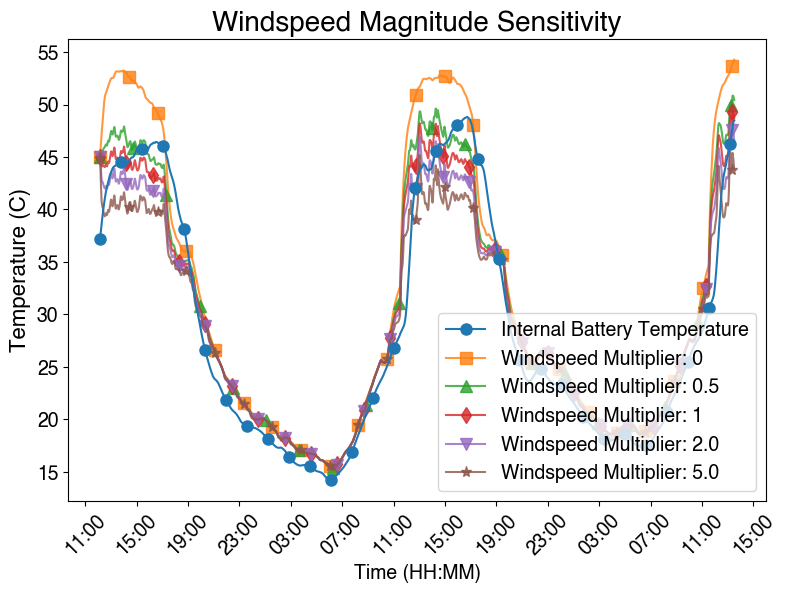

In [251]:
# Prepare a list of dictionaries for each dataframe with appropriate labels
comparison_data = []

for data_entry in dfs:
    wind_speed_factor = data_entry['wind_speed_factor']
    df = data_entry['df']
    df = df.resample('min').mean()
    
    # Create a label based on interval and run_interval
    label = f"Windspeed Multiplier: {wind_speed_factor}"
    
    # Add this dataframe and label to the comparison data list
    comparison_data.append({'data': df, 'label': label})

# Call the plot function with all the dataframes at once
validation.plot_comparison(
    smoothed_others_df, 
    comparison_data,  # Pass the list of dicts with data and labels
    start_date_time, 
    end_date_time, 
    col1='4_smooth', 
    col2='4_smooth',
    title="Windspeed Magnitude Sensitivity",
    hour_interval = 4
)


##### Average Internal Validation

In [177]:


# just consider battery for now

# Define paremeters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

dir = '../real_data/'

import pandas as pd
sensor_readings_df = pd.read_csv(dir + 'sensor_readings_2024_06_26_16_45.csv')
sensor_readings_df = sensor_readings_df.set_index('timestamp')
sensor_readings_df.index = pd.to_datetime(sensor_readings_df.index)
sensor_readings_df.index = sensor_readings_df.index.round('S')
sensor_readings_df = sensor_readings_df.resample('T').mean()
sensor_readings_df.drop(columns=['sensor_8', 'sensor_9', 'sensor_10', 'sensor_11'], inplace=True)

sensor_readings_df = sensor_readings_df.dropna()

# create function to get angle of incidence from time and gps as input variables
L = 0.2032
W = 0.152
H = 0.10922
SA = 2 * (L*W + H*W + H*L)

sensor_readings_df['average_internal'] = (sensor_readings_df['sensor_0'] + 0.5*(sensor_readings_df['sensor_1'] + sensor_readings_df['sensor_2'])+ sensor_readings_df['sensor_3'])*1/3
sensor_readings_df['weighted_average_internal'] = (L*W*sensor_readings_df['sensor_0']  + W*H*0.5*(sensor_readings_df['sensor_1'] + sensor_readings_df['sensor_2'])+ L*H * sensor_readings_df['sensor_3'])* 2/SA

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83354/1887949246.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sensor_readings_df.index = sensor_readings_df.index.round('S')
/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83354/1887949246.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sensor_readings_df = sensor_readings_df.resample('T').mean()


In [178]:
from scipy.signal import savgol_filter
# Define the window length and polynomial order
window_length = 59  # should be an odd number
polyorder = 2
smoothed_df = pd.DataFrame()
smoothed_df.index = sensor_readings_df.index

# Apply the Savitzky-Golay filter to each column
for col in sensor_readings_df.columns:
  print(col)
  smoothed_df[col[-1] + '_smooth'] = savgol_filter(sensor_readings_df[col], window_length, polyorder)

smoothed_df["average_internal" + '_smooth'] = savgol_filter(sensor_readings_df["average_internal"], window_length, polyorder)
smoothed_df["weighted_average_internal" + '_smooth'] = savgol_filter(sensor_readings_df["weighted_average_internal"], window_length, polyorder)

sensor_0
sensor_1
sensor_2
sensor_3
sensor_4
sensor_5
sensor_6
sensor_7
fan
average_internal
weighted_average_internal


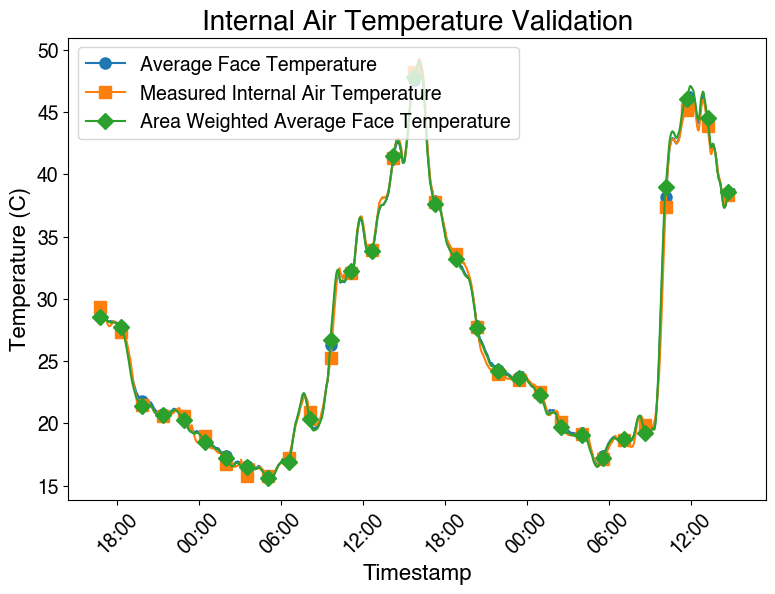

In [185]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

labels_dict = {
    0: 'top face inner (same side as 6)',
    1: 'side face inner (same side as 7)',
    2: 'side face inner (same side as 5)',
    3: 'weird face inner',
    "4": 'Measured Internal Air Temperature',
    5: 'side face outer',
    6: 'Top face outer',
    7: 'opposite side face outer',
    'a': 'Average Face Temperature',
    'w': 'Area Weighted Average Face Temperature'
}

# Example datetime bounds
xmin = pd.to_datetime('2024-01-01')
xmax = pd.to_datetime('2024-12-31')

fig, ax = plt.subplots(figsize=(9, 6))

# Define different markers for each line
markers = ['o', 's', 'D', '^', 'v', 'p', 'h', 'X', '*', '+']  # Add more if needed

# Plot each line with a unique marker
for i, col in enumerate(['average_internal_smooth', '4_smooth', 'weighted_average_internal_smooth']):
    try:
        ax.plot(
            smoothed_df[col], 
            label=labels_dict[col[0]], 
            marker=markers[i % len(markers)],  # Cycle through markers
            markersize=8, 
            markevery=max(1, len(smoothed_df[col]) // 30)  # Ensures 30 markers
        )
    except Exception:
        pass

ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Temperature (C)', fontsize=16)
plt.xlabel("Timestamp", fontsize=16)
plt.title("Internal Air Temperature Validation", fontsize=20 )
plt.legend(fontsize=14)#, loc="upper right")

plt.show()


In [ ]:
from sklearn.metrics import r2_score
r2_score(smoothed_df['weighted_average_internal_smooth'], smoothed_df['4_smooth'])


In [ ]:
r2_score(smoothed_df['average_internal_smooth'], smoothed_df['4_smooth'])

#### Fan Model Sensitivity (mixing ratio and speed)

In [141]:
import logging
filename = 'validation.log'
logging.basicConfig(filename=filename, level=logging.INFO, format='%(asctime)s - %(message)s')
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)
# Clear the log file
with open(filename, 'w'):
    pass  # This opens and immediately closes the file, truncating it

others_df, smoothed_others_df = import_data("../real_data/sensor_readings_2024_06_26_16_45.csv",  logging, 59, 2, columns_to_drop = [
       'sensor_0', 'sensor_1', #'sensor_2', 'sensor_3', 
	'sensor_5', 'sensor_6', 'sensor_7', 'sensor_15'])
	

--- Logging error ---
Traceback (most recent call last):
  File "/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py", line 181, in import_data
    sensor_readings_df.drop(columns=[col], inplace=True)
  File "/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/.venv/lib/python3.9/site-packages/pandas/core/frame.py", line 5581, in drop
    return super().drop(
  File "/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/.venv/lib/python3.9/site-packages/pandas/core/generic.py", line 4788, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/.venv/lib/python3.9/site-packages/pandas/core/generic.py", line 4830, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
  File "/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/.venv/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 7070, in drop
    raise KeyError(f"{labels[mask].tolist()} not found in axis")
KeyError: "['sensor

In [142]:
smoothed_others_df

2_smooth   3_smooth   4_smooth  8_smooth  9_smooth  \
timestamp                                                                  
2024-06-26 16:45:00  28.361022  28.475489  29.339007       NaN       NaN   
2024-06-26 16:46:00  28.366807  28.472899  29.284830       NaN       NaN   
2024-06-26 16:47:00  28.372291  28.470117  29.231683       NaN       NaN   
2024-06-26 16:48:00  28.377477  28.467142  29.179566       NaN       NaN   
2024-06-26 16:49:00  28.382362  28.463975  29.128479       NaN       NaN   
...                        ...        ...        ...       ...       ...   
2024-06-28 15:06:00  39.038373  39.130167  38.633534       NaN       NaN   
2024-06-28 15:07:00  39.057529  39.171106  38.644545       NaN       NaN   
2024-06-28 15:08:00  39.077031  39.213207  38.655358       NaN       NaN   
2024-06-28 15:09:00  39.096879  39.256470  38.665974       NaN       NaN   
2024-06-28 15:10:00  39.117073  39.300895  38.676391       NaN       NaN   

                     0_smooth  1_smooth  n_smooth  
timestamp                                          
2024-06-26 16:45:00       NaN       NaN       0.0  
2024-06-26 16:46:00       NaN       NaN       0.0  
2024-06-26 16:47:00       NaN       NaN       0.0  
2024-06-26 16:48:00       NaN       NaN       0.0  
2024-06-26 16:49:00       NaN       NaN       0.0  
...                       ...       ...       ...  
2024-06-28 15:06:00       NaN       NaN       1.0  
2024-06-28 15:07:00       NaN       NaN       1.0  
2024-06-28 15:08:00       NaN       NaN       1.0  
2024-06-28 15:09:00       NaN       NaN       1.0  
2024-06-28 15:10:00       NaN       NaN       1.0  

[2786 rows x 8 columns]

In [171]:
start_date_time = "2024-06-26 16:45:00"
end_date_time = "2024-06-28 15:10:00"

import run_foco

dfs = []
for mixing_ratio in [0, 0.1, 0.3]:

	results_dir = run_foco.run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 4, internal_rad =  True, h_max = 100, 
							heat_generation = 0, fan_flow = 50, T_initial=30 + 273.15,fan_threshold = 30, fan_heat_generation=9,
							shading_ranges = [('17:00:00', '18:30:00')],
							interval = 120,
							run_interval = 30,
							wind_speed_factor = 1,
							fan_mixing_ratio = mixing_ratio,
							#shading=False,
							#shading_ranges = []
							)

	logging.info("Directories: " + results_dir)
	model_df_ABS_fanspeed = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))
	dfs.append({'fan': mixing_ratio,
			 'df':model_df_ABS_fanspeed})



Fan speed: 1.0159
start date 2024-06-26
end date 2024-06-28
wind_speed_factor 1
mean temp not weighted
1.0159390725873487
Fan speed: 1.0159
start date 2024-06-26
end date 2024-06-28
wind_speed_factor 1
mean temp not weighted
1.0159390725873487
Fan speed: 1.0159
start date 2024-06-26
end date 2024-06-28
wind_speed_factor 1
mean temp not weighted
1.0159390725873487


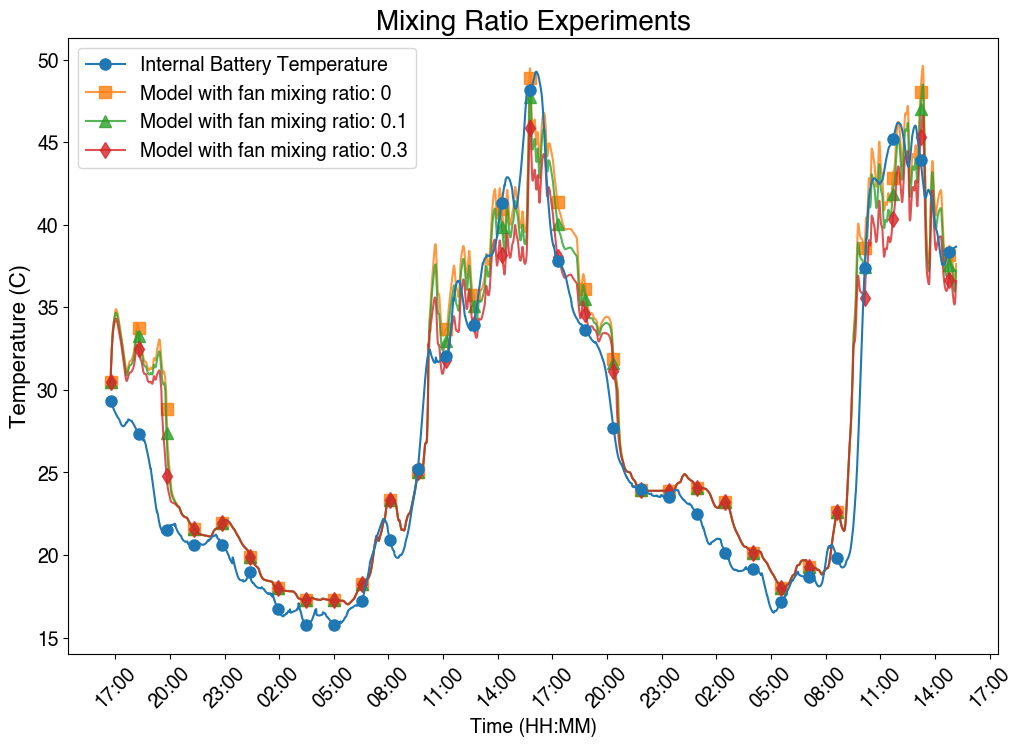

In [173]:
# Prepare a list of dictionaries for each dataframe with appropriate labels
comparison_data = []

for data_entry in dfs:
    wind_speed_factor = data_entry['fan']
    df = data_entry['df']
    df = df.resample('min').mean()
    
    # Create a label based on interval and run_interval
    label = f"Model with fan mixing ratio: {wind_speed_factor}"
    
    # Add this dataframe and label to the comparison data list
    comparison_data.append({'data': df, 'label': label})

# Call the plot function with all the dataframes at once
validation.plot_comparison(
    smoothed_others_df, 
    comparison_data,  # Pass the list of dicts with data and labels
    start_date_time, 
    end_date_time, 
    col1='4_smooth', 
    col2='4_smooth',
    title="Mixing Ratio Experiments",
    ignore_real = False
)


In [174]:
start_date_time = "2024-06-26 16:45:00"
end_date_time = "2024-06-28 15:10:00"

import run_foco

dfs = []
for fan_flow in [0, 50, 100, 200]:

	results_dir = run_foco.run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 4, internal_rad =  True, h_max = 100, 
							heat_generation = 0, fan_flow = fan_flow, T_initial=30 + 273.15,fan_threshold = 30, fan_heat_generation=9,
							shading_ranges = [('17:00:00', '18:30:00')],
							interval = 120,
							run_interval = 30,
							wind_speed_factor = 1,
							fan_mixing_ratio = 0.1,
							#shading=False,
							#shading_ranges = []
							)

	logging.info("Directories: " + results_dir)
	model_df_ABS_fanspeed = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))
	dfs.append({'fan': fan_flow,
			 'df':model_df_ABS_fanspeed})



Fan speed: 0.0
start date 2024-06-26
end date 2024-06-28
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 1.0159
start date 2024-06-26
end date 2024-06-28
wind_speed_factor 1
mean temp not weighted
1.0159390725873487
Fan speed: 2.0319
start date 2024-06-26
end date 2024-06-28
wind_speed_factor 1
mean temp not weighted
2.0318781451746974
Fan speed: 4.0638
start date 2024-06-26
end date 2024-06-28
wind_speed_factor 1
mean temp not weighted
4.063756290349395


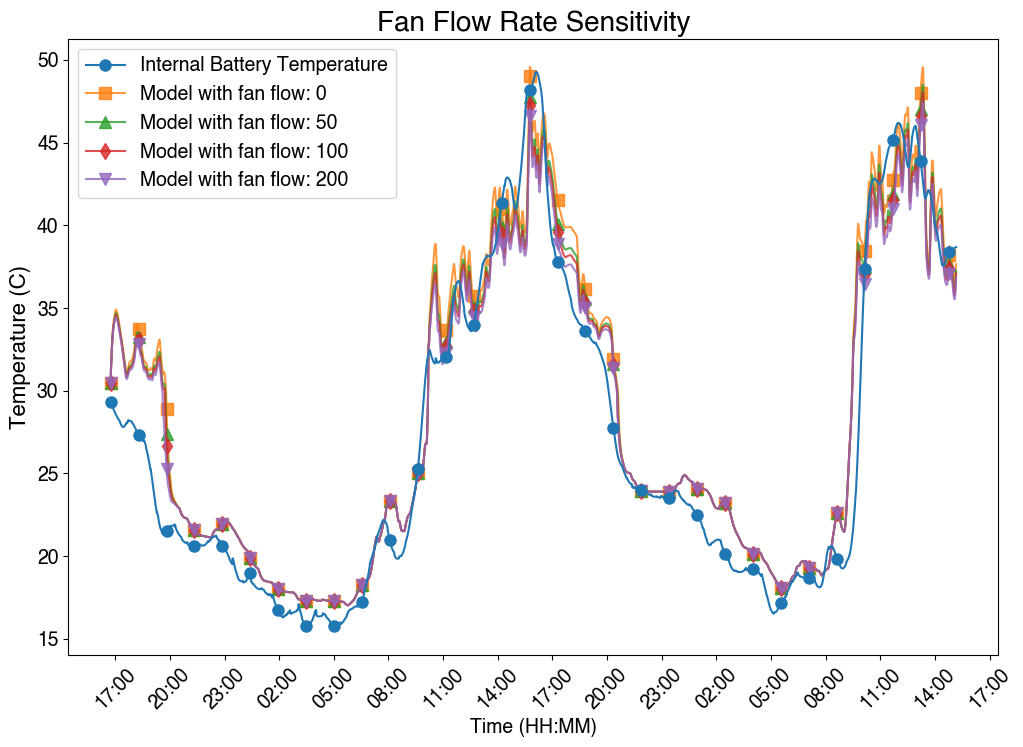

In [176]:
# Prepare a list of dictionaries for each dataframe with appropriate labels
comparison_data = []

for data_entry in dfs:
    wind_speed_factor = data_entry['fan']
    df = data_entry['df']
    df = df.resample('min').mean()
    
    # Create a label based on interval and run_interval
    label = f"Model with fan flow: {wind_speed_factor}"
    
    # Add this dataframe and label to the comparison data list
    comparison_data.append({'data': df, 'label': label})

# Call the plot function with all the dataframes at once
validation.plot_comparison(
    smoothed_others_df, 
    comparison_data,  # Pass the list of dicts with data and labels
    start_date_time, 
    end_date_time, 
    col1='4_smooth', 
    col2='4_smooth',
    title="Fan Flow Rate Sensitivity",
    ignore_real = False
)


#### duty cycle sensitivity

In [272]:
start_date_time = '2024-07-31 12:10:00'
end_date_time = '2024-08-03 13:30:00'

import validation


dfs = []
for pair in [[30,8],
			 [30,28],
			 [120,30],
			 [120,80],
			 ]:
	interval = pair[0]
	run_interval = pair[1]
	
	results_dir = run_foco(logging = logging, start_date_time = start_date_time, end_date_time = end_date_time, N = 5, internal_rad =  True, h_max = 100, 
							heat_generation = 0, fan_flow = 0, T_initial=45 + 273.15,fan_threshold = 50,
							k=0.216,
							rho=1370,
							Cp=1300,
							emissivity=0.92,
							L = 0.4,
							H = 0.2,
							W = 0.4,
							thicknesses=[0.005, 0.005, 0.005, 0.005, 0.005, 0.005],
							shading_ranges = [('10:00:00', '11:30:00')],
							interval = interval,
							run_interval = run_interval,
							#shading=False,
							#shading_ranges = []
							)

	logging.info("Directories: " + results_dir)
	model_df_fiberglass = load_data(results_dir, datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S'))
	dfs.append({'interval': interval,
			 'run_interval':run_interval,
			 'df':model_df_fiberglass})



Fan speed: 0.0
start date 2024-07-31
end date 2024-08-03
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-03
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-03
wind_speed_factor 1
mean temp not weighted
0.0
Fan speed: 0.0
start date 2024-07-31
end date 2024-08-03
wind_speed_factor 1
mean temp not weighted
0.0


/Users/kyan/Desktop/REU AIR/HT_monitor_model/python/validation.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothed_df['batt_avg'] = 0.5 * (smoothed_df[col1] + smoothed_df[col2])


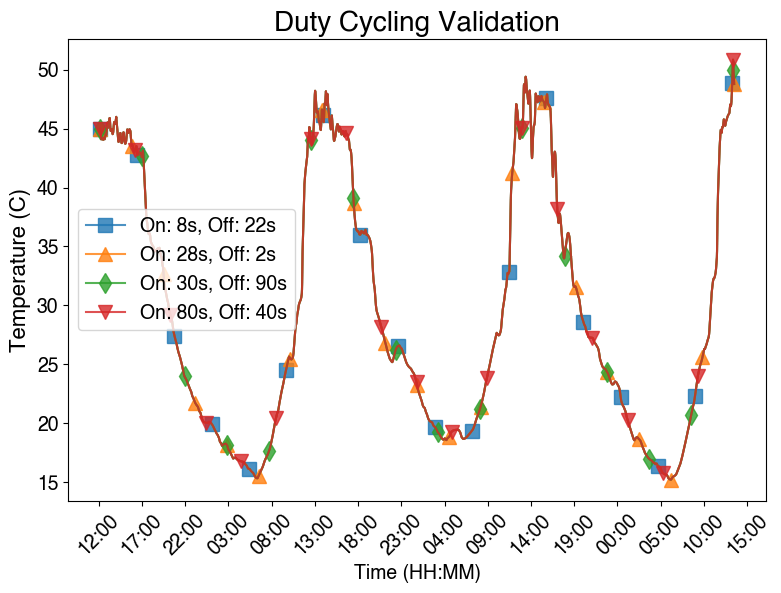

In [273]:
# Prepare a list of dictionaries for each dataframe with appropriate labels
comparison_data = []

for data_entry in dfs:
    interval = data_entry['interval']
    run_interval = data_entry['run_interval']
    df = data_entry['df']
    df = df.resample('min').mean()
    
    # Create a label based on interval and run_interval
    label = f"On: {run_interval}s, Off: {interval - run_interval}s"
    
    # Add this dataframe and label to the comparison data list
    comparison_data.append({'data': df, 'label': label})

# Call the plot function with all the dataframes at once
validation.plot_comparison(
    smoothed_others_df, 
    comparison_data,  # Pass the list of dicts with data and labels
    start_date_time, 
    end_date_time, 
    col1='4_smooth', 
    col2='4_smooth',
    title="Duty Cycling Validation",
    ignore_real = True,
    hour_interval=5
)


In [124]:
from sklearn.metrics import r2_score
import pandas as pd

# Prepare an empty list to store R^2 values and corresponding intervals
r2_data = []

# Loop through each entry in dfs
for data_entry in dfs:
    interval = data_entry['interval']
    run_interval = data_entry['run_interval']
    df = data_entry['df']
    df = df.resample('1min').mean()
    
    df_real = smoothed_others_df.loc[(smoothed_others_df.index >= df.index[0]) & (smoothed_others_df.index <= df.index[-1])]

    merged_df = pd.merge(df, df_real, left_index=True, right_index=True)
    merged_df = merged_df.dropna(subset=['4_smooth', 'internal'])
    # Calculate R^2 score between df['internal'] and smoothed_others_df['4_smooth']
    r2_value = r2_score(merged_df['internal']-273.15, merged_df['4_smooth'])
    
    # Store the interval, run_interval, and R^2 value in the list
    r2_data.append({'Interval': interval, 'Run Interval': run_interval, 'R^2': r2_value})

# Convert the list to a pandas DataFrame for better visualization
r2_df = pd.DataFrame(r2_data)

# Display the R^2 table
print(r2_df)


   Interval  Run Interval       R^2
0        30             8  0.926143
1        30            12  0.926143
2        30            20  0.926143
3       120            30  0.926143
4       120            48  0.926143
5       120            80  0.926143


In [128]:
from scipy.stats import ttest_rel
import pandas as pd
import numpy as np

# Prepare a list to store p-values
p_values = []

# Loop through all unique pairs of data entries
for i in range(len(dfs)):
    for j in range(i + 1, len(dfs)):  # Ensure unique pairs
        entry1 = dfs[i]
        entry2 = dfs[j]

        label1 = entry1['interval']
        label2 = entry2['interval']

        df1 = entry1['df'].resample('1min').mean()
        df2 = entry2['df'].resample('1min').mean()

        # Merge based on common timestamps
        merged_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=('_1', '_2'))
        merged_df = merged_df.dropna(subset=['internal_1', 'internal_2'])

        # Perform paired t-test
        if len(merged_df) > 1:  # Ensure enough data points
            t_stat, p_value = ttest_rel(merged_df['internal_1'] - 273.15, merged_df['internal_2'] - 273.15)

        # Store the result
        p_values.append({'Dataset 1': label1, 'Dataset 2': label2, 'p-value': p_value})

# Convert to DataFrame
p_value_df = pd.DataFrame(p_values)

# Display results
print(p_value_df)


    Dataset 1  Dataset 2  p-value
0          30         30      NaN
1          30         30      NaN
2          30        120      NaN
3          30        120      NaN
4          30        120      NaN
5          30         30      NaN
6          30        120      NaN
7          30        120      NaN
8          30        120      NaN
9          30        120      NaN
10         30        120      NaN
11         30        120      NaN
12        120        120      NaN
13        120        120      NaN
14        120        120      NaN
